In [88]:
# Install necessary libraries
!pip install -q yfinance
!pip install pandas-datareader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
import streamlit as st


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [89]:
import pandas as pd
import yfinance as yf
from datetime import datetime

# Download stock data
yf.pdr_override()
end = datetime.now()
start = datetime(end.year - 7, end.month, end.day)
company_data = {}
tech_listx = ['NVDA']
tech_list = ['NVDA']
for stock in tech_listx:
    df = yf.download(stock, start=start, end=end)
    company_data[stock] = df

# Convert and concatenate data
company_list = list(company_data.values())
company_name = ["NVDA"]

# Ensure consistent date format and indexing
for company, com_name in zip(company_list, company_name):
    company.reset_index(inplace=True)
    company['Date'] = pd.to_datetime(company['Date'], errors='coerce')  # Ensure dates are converted
    company.set_index('Date', inplace=True)
    company["NVDA"] = com_name

# Concatenate individual stock data into a single DataFrame
df = pd.concat(company_list, axis=0)

# Fill missing values using forward fill
df.ffill(inplace=True)

# Reset index to inspect
df.reset_index(inplace=True)

# Ensure datetime index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Extract year from the datetime index
df['Year'] = df.index.year

# Count the number of data points per year
yearly_data_count = df.groupby('Year').size()

# Print the count of data points per year
for year, count in yearly_data_count.items():
    print(f"Year {year}: {count} data points")

[*********************100%%**********************]  1 of 1 completed

Year 2017: 102 data points
Year 2018: 251 data points
Year 2019: 252 data points
Year 2020: 253 data points
Year 2021: 252 data points
Year 2022: 251 data points
Year 2023: 250 data points
Year 2024: 150 data points


## 1. Load and Read Data

In [90]:
# Fill missing values using forward fill for each company
for company in company_list:
    company.ffill(inplace=True)

# Ensure consistent date format for each company DataFrame
for company in company_list:
    company.reset_index(inplace=True)
    company['Date'] = pd.to_datetime(company['Date'], errors='coerce')  # Ensure conversion
    company.set_index('Date', inplace=True)

# Add company name column to each DataFrame
for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

# Concatenate individual stock data into a single DataFrame
df = pd.concat(company_list, axis=0)

# Debug: Print column names before setting index
print("Columns before setting index:", df.columns)

# Reset index and ensure 'Date' is the index
df.reset_index(inplace=True)  # Reset index, drop=False keeps existing index
print("Columns after reset_index:", df.columns)  # Debug column names

# Check if 'Date' column exists
if 'Date' in df.columns:
    df.set_index('Date', inplace=True)
else:
    print("'Date' column is missing from the DataFrame")

# Fill any remaining missing values after concatenation
df = df.fillna(method='ffill')

# Extract year from the datetime index
df['Year'] = df.index.year

# Count the number of data points per year
yearly_data_count = df.groupby('Year').size()

# Print the count of data points per year
for year, count in yearly_data_count.items():
    print(f"Year {year}: {count} data points")

Columns before setting index: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'NVDA',
       'company_name'],
      dtype='object')
Columns after reset_index: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'NVDA',
       'company_name'],
      dtype='object')
Year 2017: 102 data points
Year 2018: 251 data points
Year 2019: 252 data points
Year 2020: 253 data points
Year 2021: 252 data points
Year 2022: 251 data points
Year 2023: 250 data points
Year 2024: 150 data points


## EDA

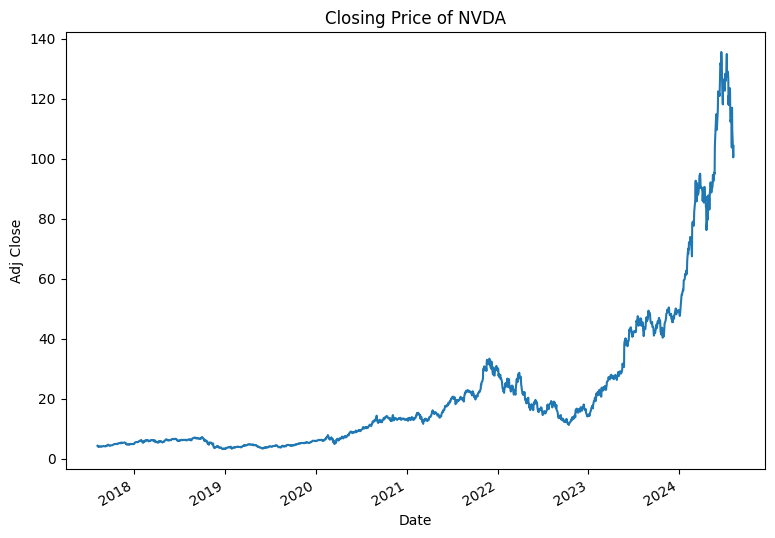

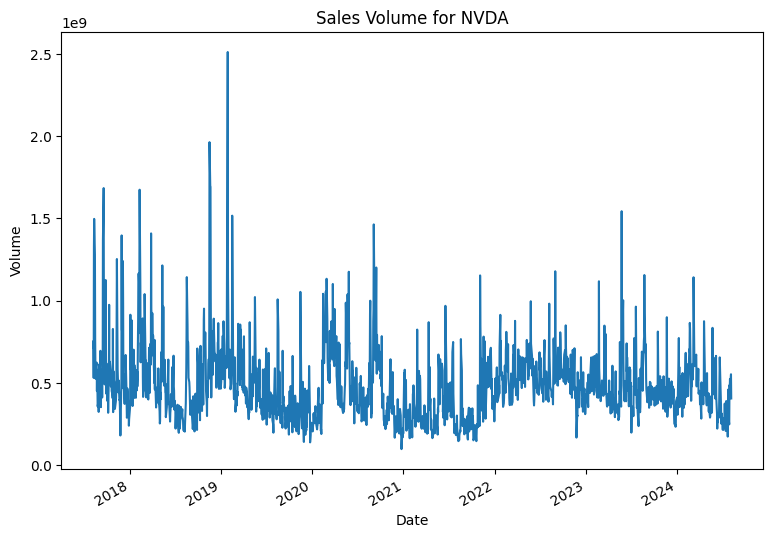

In [91]:
# Plotting closing prices
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.title(f"Closing Price of {tech_list[i - 1]}")
plt.tight_layout()

# Plotting sales volume
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
plt.tight_layout()

ma_day = [10, 20, 50]

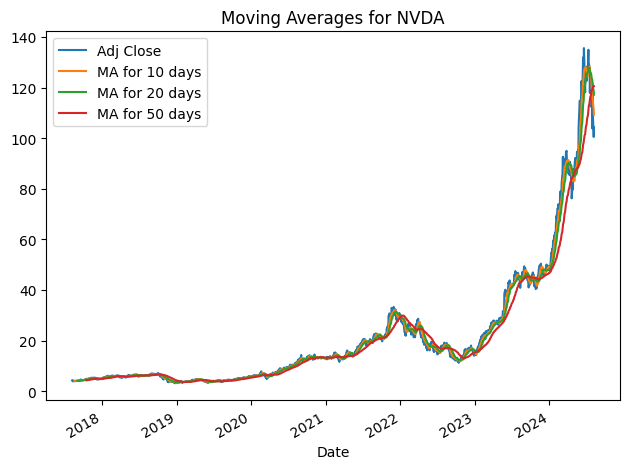

In [92]:
# Calculate moving averages
ma_day = [10, 20, 50]
for company_data in company_list:
    for ma in ma_day:
        column_name = f"MA for {ma} days"
        company_data[column_name] = company_data['Adj Close'].rolling(ma).mean()

# plt.figure(figsize=(15, 10))
# plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company_data in enumerate(company_list, 1):
    # plt.subplot(2, 2, i)
    company_data[['Adj Close', f"MA for {ma_day[0]} days", f"MA for {ma_day[1]} days", f"MA for {ma_day[2]} days"]].plot()
    plt.title(f"Moving Averages for {tech_list[i-1]}")
plt.tight_layout()
plt.show()

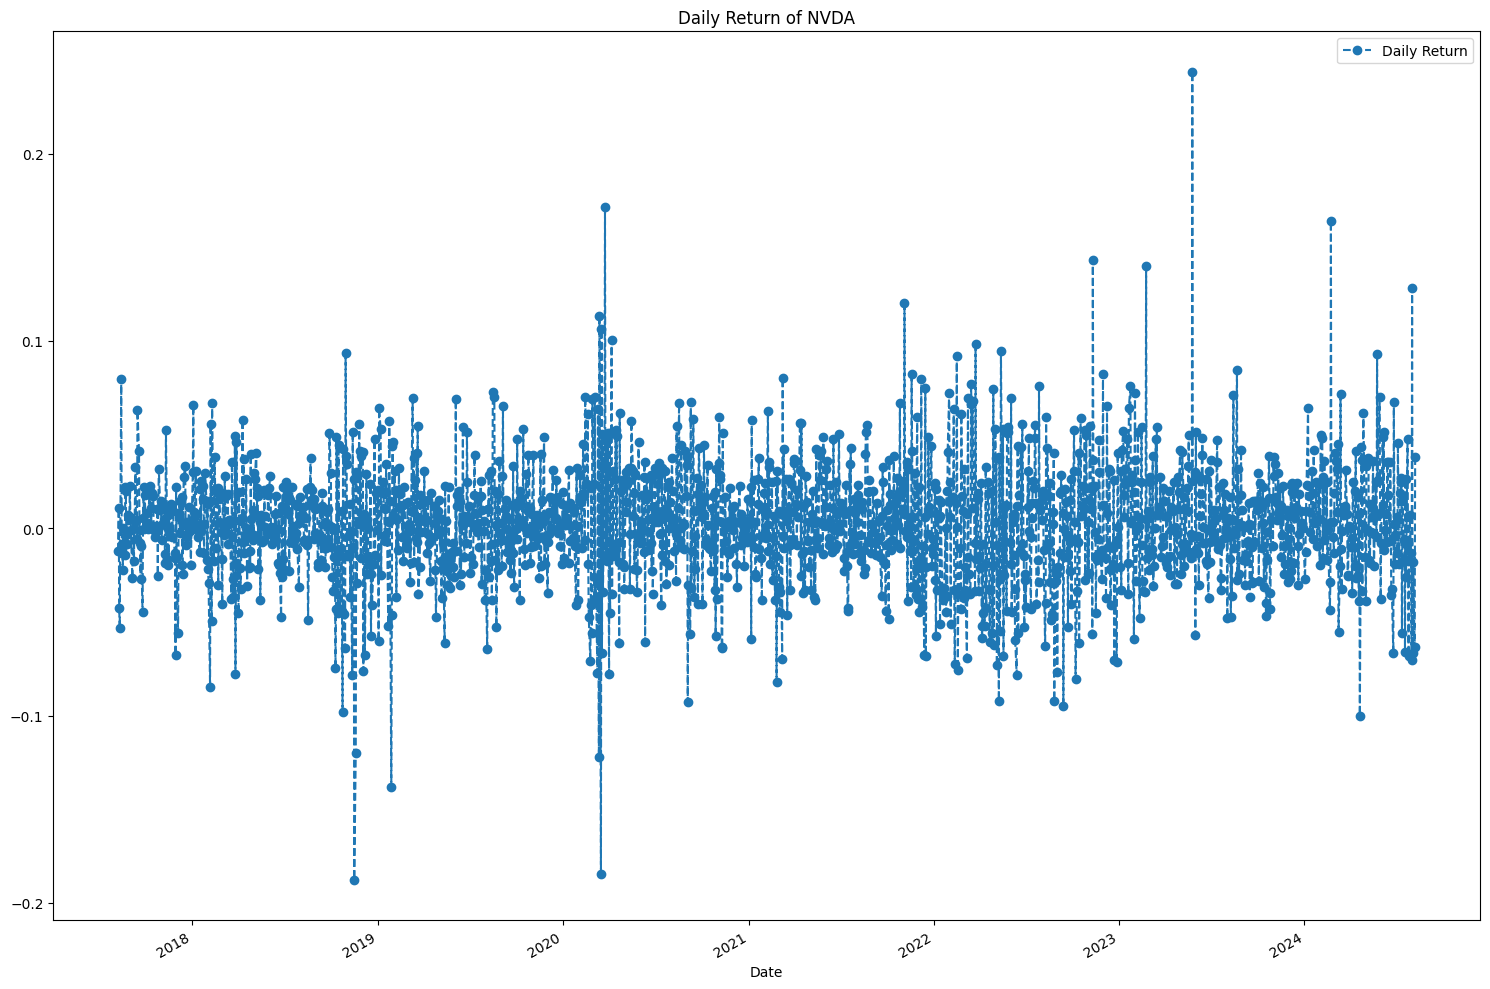

In [93]:
# Calculate daily returns
for company_data in company_list:
    company_data['Daily Return'] = company_data['Adj Close'].pct_change()

# Plotting daily returns
plt.figure(figsize=(15, 10))
company_list[0]['Daily Return'].plot(legend=True, linestyle='--', marker='o')
plt.title(f"Daily Return of {tech_list[0]}")
plt.tight_layout()
plt.show()

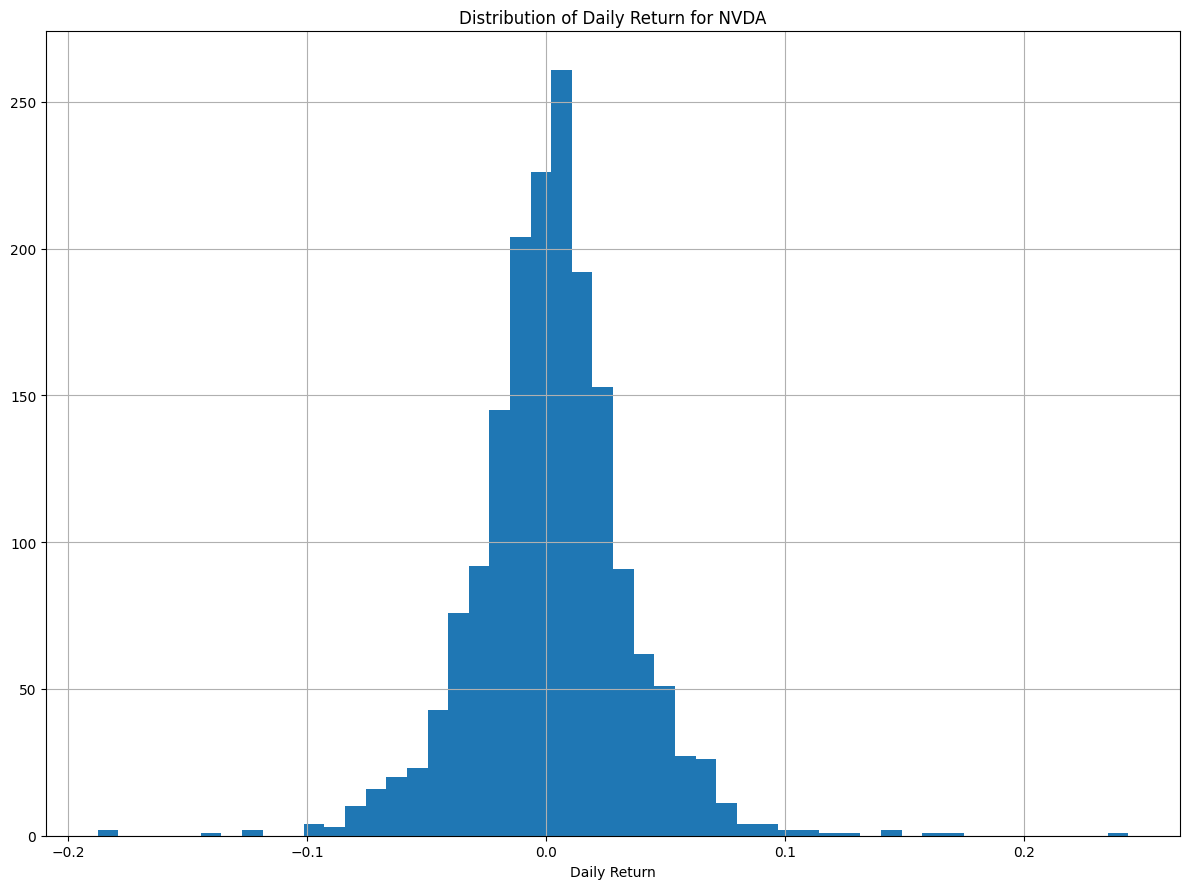

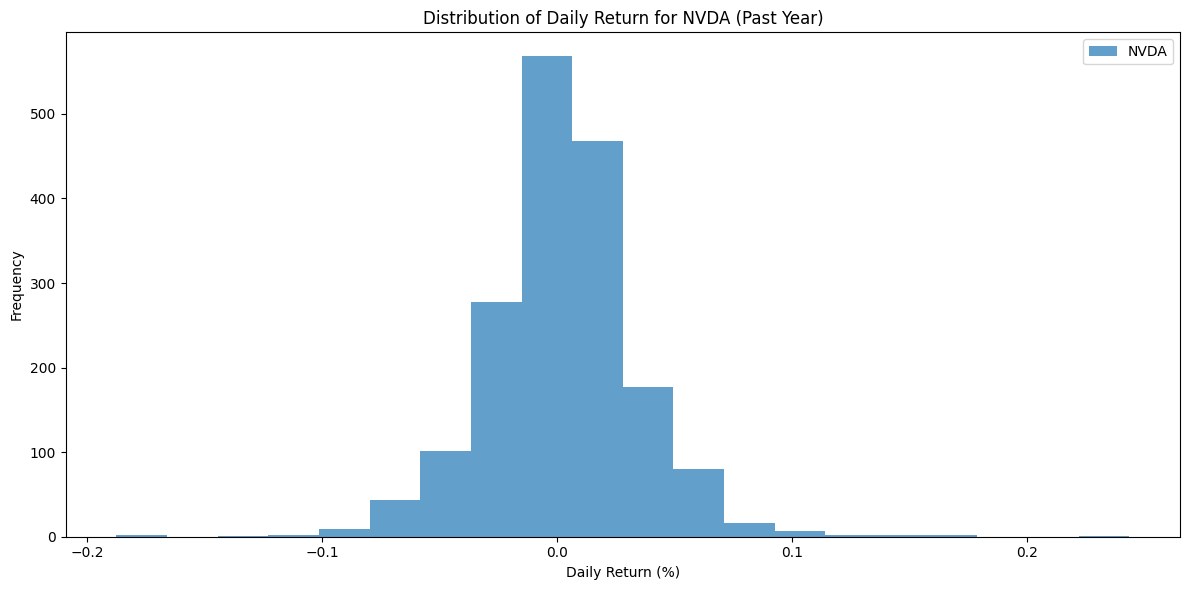

In [94]:

# Günlük getirilerin dağılımını çizme
plt.figure(figsize=(12, 9))
company_data = company_list[0]
company_data['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.title(f'Distribution of Daily Return for {tech_list[0]}')
plt.tight_layout()
plt.show()

# Tek bir şirket için histogram oluşturma
plt.figure(figsize=(12, 6))
plt.hist(company_data['Daily Return'], bins=20, alpha=0.7, label=tech_list[0])
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Daily Return for {tech_list[0]} (Past Year)')
plt.legend()
plt.tight_layout()
plt.show()

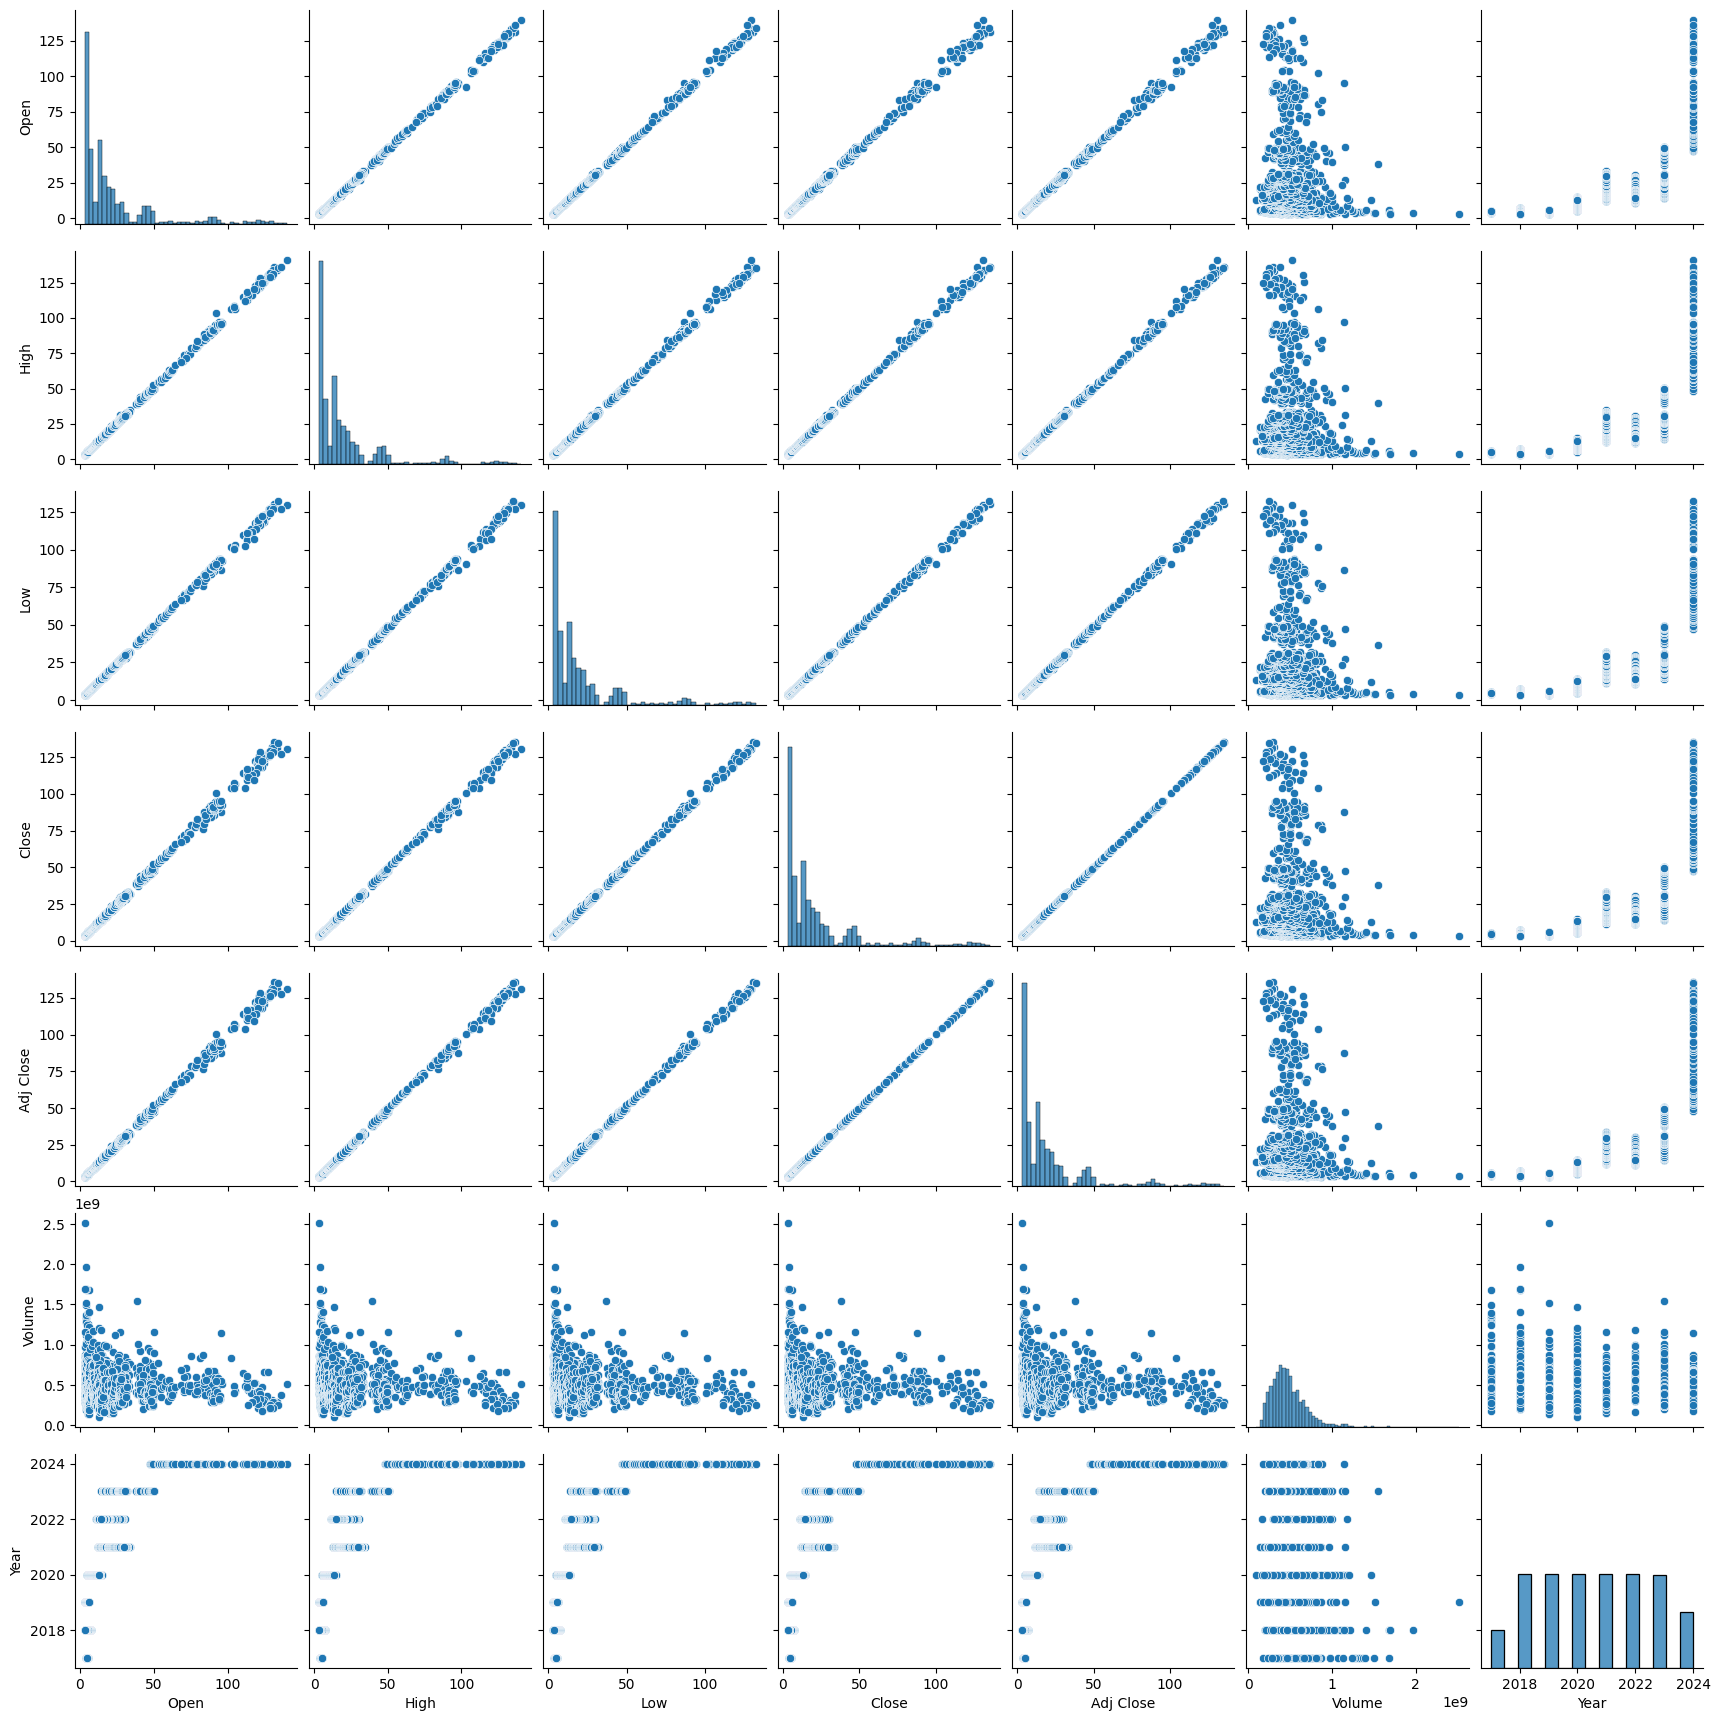

<Figure size 1200x600 with 0 Axes>

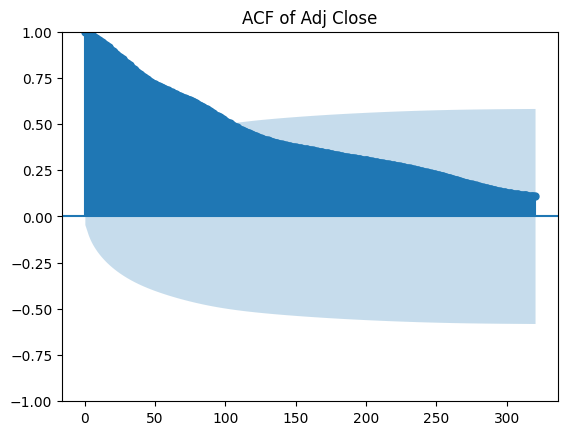

<Figure size 1200x600 with 0 Axes>

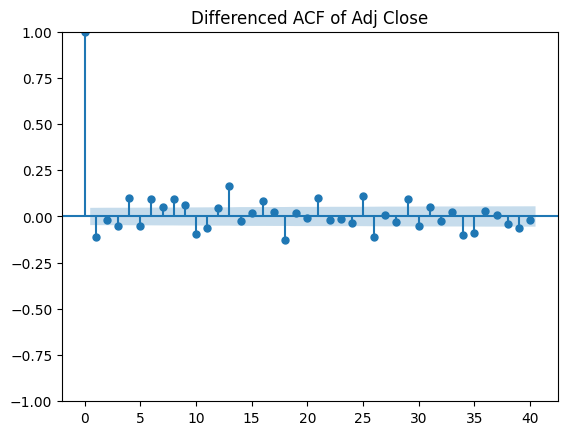

Year 2017: 102 data points
Year 2018: 251 data points
Year 2019: 252 data points
Year 2020: 253 data points
Year 2021: 252 data points
Year 2022: 251 data points
Year 2023: 250 data points
Year 2024: 150 data points


In [95]:
from statsmodels.graphics.tsaplots import plot_acf 
from sklearn.linear_model import LinearRegression
# NaN değerlerini kaldırma
df_cleaned = df.dropna()

# Pairplot for all numeric columns
sns.pairplot(df_cleaned)
plt.show()

# Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df_cleaned['Adj Close'], lags=320)
plt.title('ACF of Adj Close')
plt.show()

# Differenced Autocorrelation Function
plt.figure(figsize=(12, 6))
plot_acf(df_cleaned['Adj Close'].diff().dropna(), lags=40)
plt.title('Differenced ACF of Adj Close')
plt.show()

# Assuming df_cleaned has a datetime index
df_cleaned.index = pd.to_datetime(df_cleaned.index)

# Extract year from the datetime index
df_cleaned['Year'] = df_cleaned.index.year

# Count the number of data points per year
yearly_data_count = df_cleaned.groupby('Year').size()

# Print the count of data points per year
for year, count in yearly_data_count.items():
    print(f"Year {year}: {count} data points")

Feature

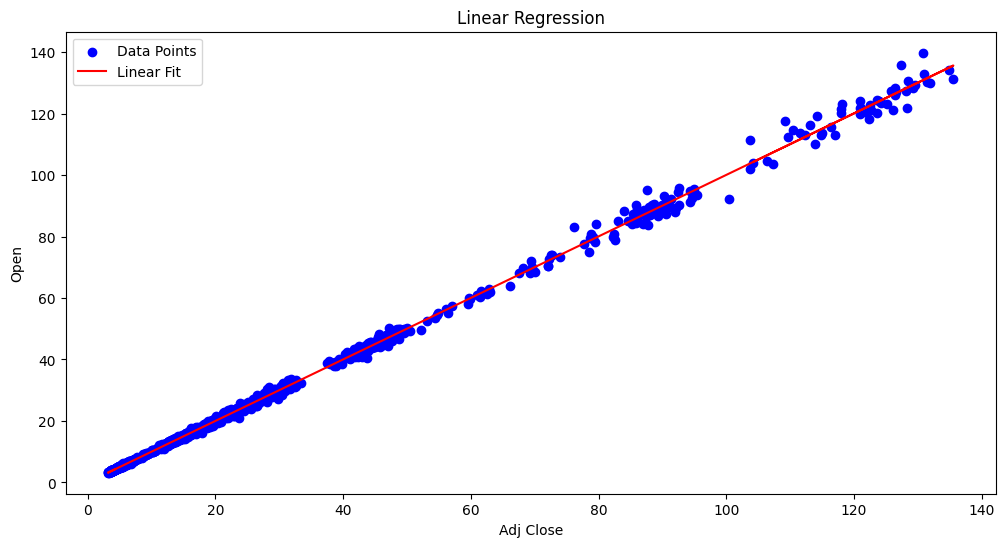

Year 2017: 102 data points
Year 2018: 251 data points
Year 2019: 252 data points
Year 2020: 253 data points
Year 2021: 252 data points
Year 2022: 251 data points
Year 2023: 250 data points
Year 2024: 150 data points


In [96]:
# Linear Regression
X = df_cleaned[['Adj Close']]
y = df_cleaned['Open']
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
mse = mean_squared_error(y, predictions)

plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='blue', label='Data Points')
plt.plot(X, predictions, color='red', label='Linear Fit')
plt.xlabel('Adj Close')
plt.ylabel('Open')
plt.title('Linear Regression')
plt.legend()
plt.show()

# Korelasyon matrisini hesaplamadan önce tarih sütununu çıkarın
numeric_data = df_cleaned.select_dtypes(include=[np.number])

# Assuming df_cleaned has a datetime index
df_cleaned.index = pd.to_datetime(df_cleaned.index)

# Extract year from the datetime index
df_cleaned['Year'] = df_cleaned.index.year

# Count the number of data points per year
yearly_data_count = df_cleaned.groupby('Year').size()

# Print the count of data points per year
for year, count in yearly_data_count.items():
    print(f"Year {year}: {count} data points")


EDA

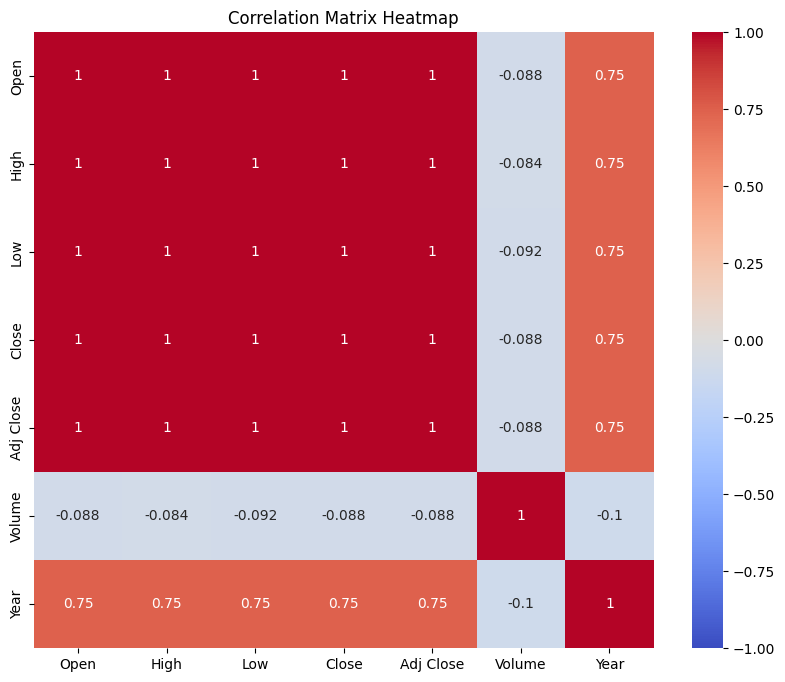

Correlation Matrix:
               Open      High       Low     Close  Adj Close    Volume   
Open       1.000000  0.999791  0.999679  0.999363   0.999362 -0.087563  \
High       0.999791  1.000000  0.999669  0.999676   0.999676 -0.084020   
Low        0.999679  0.999669  1.000000  0.999772   0.999772 -0.092077   
Close      0.999363  0.999676  0.999772  1.000000   1.000000 -0.088439   
Adj Close  0.999362  0.999676  0.999772  1.000000   1.000000 -0.088461   
Volume    -0.087563 -0.084020 -0.092077 -0.088439  -0.088461  1.000000   
Year       0.747536  0.748002  0.748652  0.748677   0.748928 -0.104914   

               Year  
Open       0.747536  
High       0.748002  
Low        0.748652  
Close      0.748677  
Adj Close  0.748928  
Volume    -0.104914  
Year       1.000000  


In [97]:
# Correlation Matrix Heatmap
cor_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Korelasyon matrisini yazdırma
print("Correlation Matrix:")
print(cor_matrix)

## Interpreting the Correlation Matrix

The correlation matrix shows the relationship between each pair of numerical variables in your dataset. Here's how to interpret the results:

### Correlation Coefficients:

- The correlation coefficient ranges from +1 to -1.
  - +1: Perfect positive correlation (as one variable increases, the other also increases).
  - -1: Perfect negative correlation (as one variable increases, the other decreases).
  - 0: No correlation (no relationship between variables).

### Correlation Matrix:

- **Open and High:** The correlation coefficient is 0.998878, indicating an almost perfect positive correlation. This means that as the Open price increases, the High price tends to increase as well.
- **Open and Low:** The correlation coefficient is 0.998994, also indicating an almost perfect positive correlation.
- **Open and Close/Adj Close:** The correlation coefficients are 0.999242 for both Close and Adj Close, showing a strong positive correlation.
- **Volume with Others:** The correlation coefficients with Volume are negative and low (e.g., -0.149957 with Open). This indicates a weak negative relationship between volume and prices.

### Overall Interpretation:

- **Strong Positive Correlation:** There are strong positive correlations between price variables (Open, High, Low, Close, Adj Close). This indicates that these variables tend to move together. For instance, if the opening price is high on a given day, the high, low, and closing prices are also generally high.
- **Weak Negative Correlation:** There is a weak negative correlation between volume and price variables. This suggests that as trading volume increases, prices tend to decrease slightly, or vice versa, but this relationship is not strong.

Based on this correlation matrix, we can conclude that price variables are closely related to each other, while volume has a weak negative relationship with these prices. This information can guide further analyses or modeling efforts by highlighting which variables are most interrelated.







Preprocess

In [98]:
# Data cleaning

df_cleaned = df.dropna()

# Ensure the dataframe has the necessary number of rows for analysis
min_rows = df_cleaned.shape[0]
df_cleaned = df_cleaned.iloc[:min_rows]

# Print the cleaned dataframe to verify
print(df_cleaned.head())

# Assuming df_cleaned has a datetime index
df_cleaned.index = pd.to_datetime(df_cleaned.index)

# Extract year from the datetime index
df_cleaned['Year'] = df_cleaned.index.year

# Count the number of data points per year
yearly_data_count = df_cleaned.groupby('Year').size()

# Print the count of data points per year
for year, count in yearly_data_count.items():
    print(f"Year {year}: {count} data points")

               Open     High      Low    Close  Adj Close      Volume  NVDA   
Date                                                                          
2017-08-07  4.20975  4.30925  4.20000  4.30875   4.256129   717412000  NVDA  \
2017-08-08  4.34725  4.36400  4.21775  4.25750   4.205505   755336000  NVDA   
2017-08-09  4.21075  4.30525  4.19175  4.30275   4.250203   530784000  NVDA   
2017-08-10  4.30400  4.31650  4.10825  4.11850   4.068202  1328088000  NVDA   
2017-08-11  3.92850  3.97500  3.82275  3.89900   3.851383  1497196000  NVDA   

           company_name  Year  
Date                           
2017-08-07         NVDA  2017  
2017-08-08         NVDA  2017  
2017-08-09         NVDA  2017  
2017-08-10         NVDA  2017  
2017-08-11         NVDA  2017  
Year 2017: 102 data points
Year 2018: 251 data points
Year 2019: 252 data points
Year 2020: 253 data points
Year 2021: 252 data points
Year 2022: 251 data points
Year 2023: 250 data points
Year 2024: 150 data points


Feature:

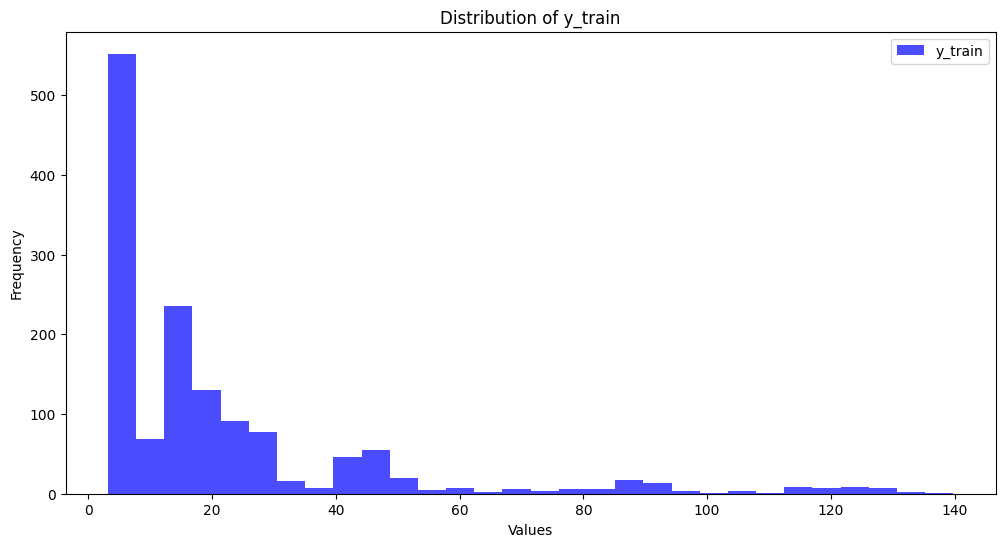

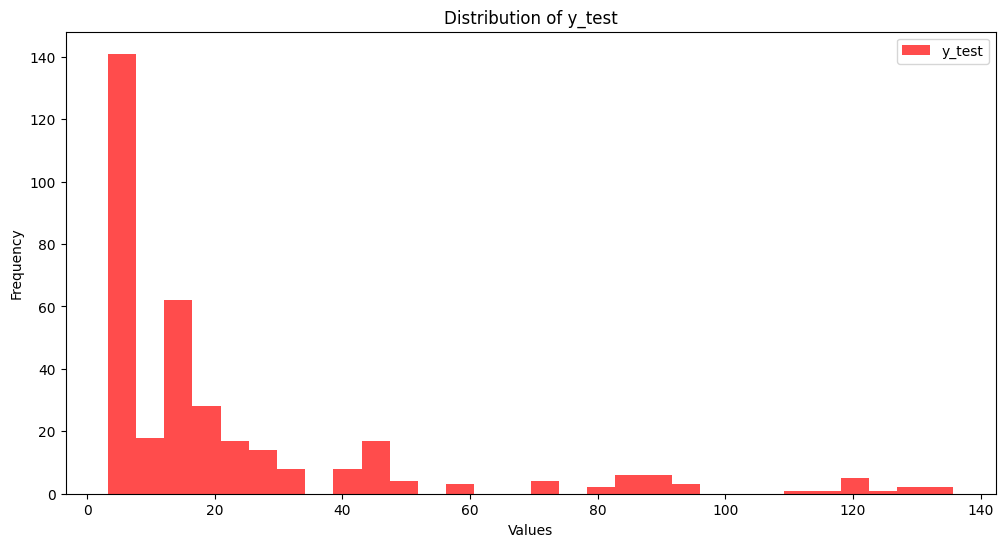

In [99]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plotting training and testing distributions
plt.figure(figsize=(12, 6))
plt.hist(y_train, bins=30, color='blue', alpha=0.7, label='y_train')
plt.title('Distribution of y_train')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(y_test, bins=30, color='red', alpha=0.7, label='y_test')
plt.title('Distribution of y_test')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Preprocess

In [100]:
# print(f"start date: {start_date.strftime('%Y-%m-%d')}")
# print(f"End date: {end_date.strftime('%Y-%m-%d')}")

# def prepare_data(selected_stock, start_date, end_date):
#     stock_data = yf.Ticker(selected_stock)
#     df = stock_data.history(start=start_date, end=end_date)
#     return df

# Assuming df_cleaned has a datetime index
df_cleaned.index = pd.to_datetime(df_cleaned.index)

# Extract year from the datetime index
df_cleaned['Year'] = df_cleaned.index.year

# Count the number of data points per year
yearly_data_count = df_cleaned.groupby('Year').size()

# Print the count of data points per year
for year, count in yearly_data_count.items():
    print(f"Year {year}: {count} data points")

Year 2017: 102 data points
Year 2018: 251 data points
Year 2019: 252 data points
Year 2020: 253 data points
Year 2021: 252 data points
Year 2022: 251 data points
Year 2023: 250 data points
Year 2024: 150 data points


Model Architecture (Model Mimarisini)

NVDA (NVDA) - Data from 2018-01-02 to 2024-08-06:
Training set size: 1327 (80.0%)
Test set size: 332 (20.0%)

Random Forest - MSE: 0.06224082476535821, MAE: 0.07816003686245011, R²: 0.9998946034593496, MAPE: 0.002629572270549937
Gradient Boosting - MSE: 0.06798462189222831, MAE: 0.1341478325367679, R²: 0.9998848771045068, MAPE: 0.0074938699933089

Random Forest training time: 15.38 seconds
Gradient Boosting training time: 0.20 seconds


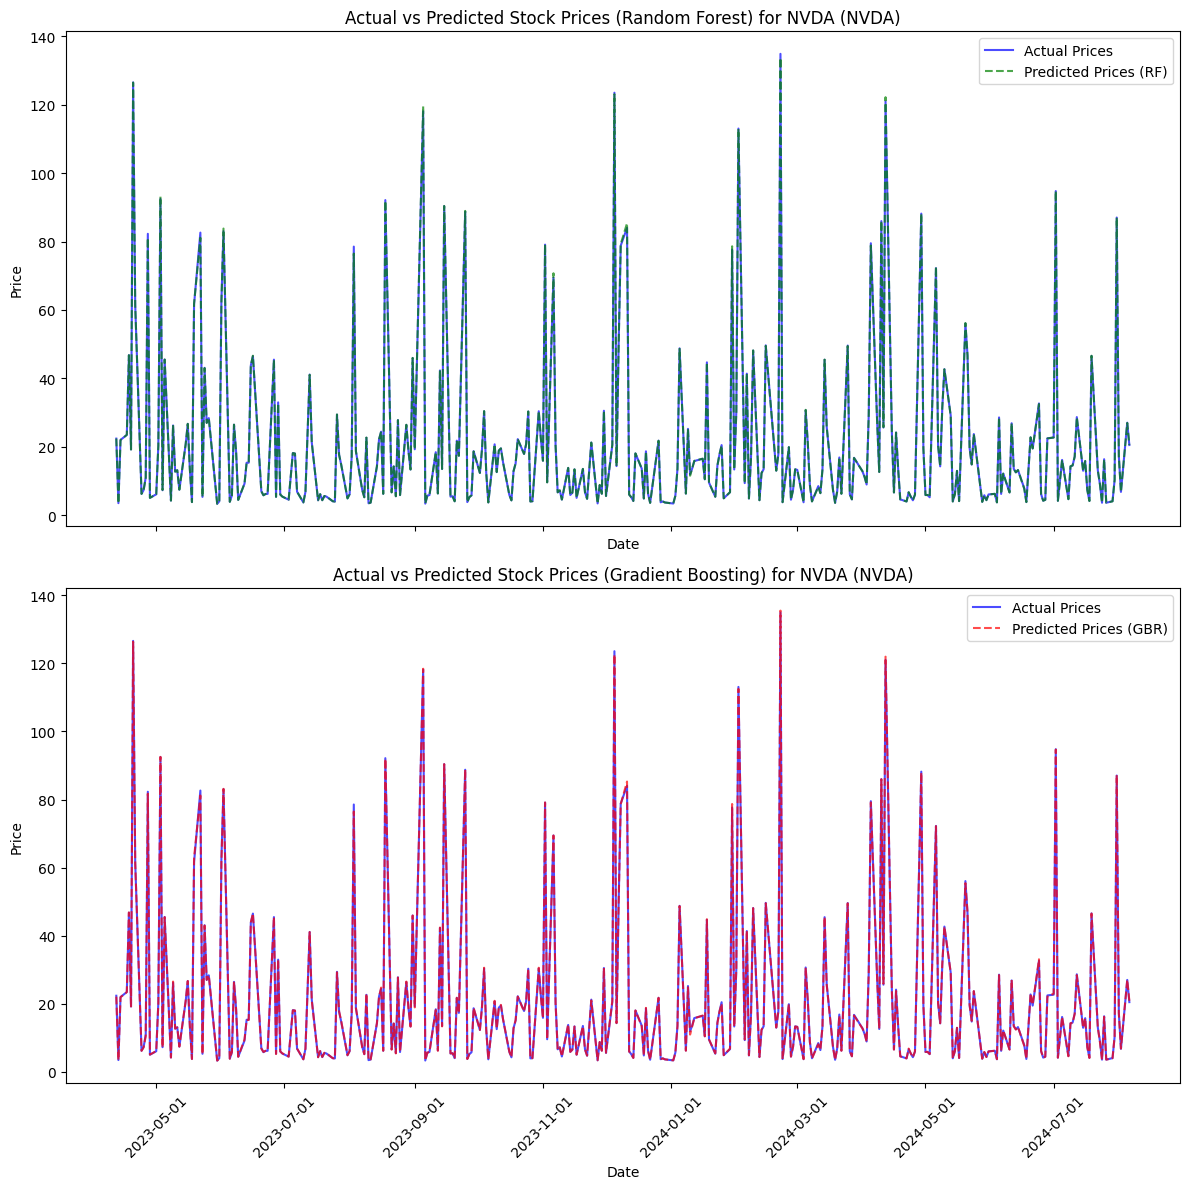

In [101]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import time

# Train and evaluate model function
def train_and_evaluate_model(df, company_name, ticker, start_date, end_date):
    # Ensure the index is datetime
    df.index = pd.to_datetime(df.index)
    
    # Filter data between 2018 and 2024
    df = df[(df.index >= '2018-01-01') & (df.index <= '2024-12-31')]
    
    X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    y = df['Close']
    test_size_ratio = 0.2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_ratio, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Random Forest Regressor
    rf = RandomForestRegressor()
    param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    
    start_time_rf = time.time()
    grid_search.fit(X_train_scaled, y_train)
    end_time_rf = time.time()
    
    best_rf = grid_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test_scaled)

    # Gradient Boosting Regressor
    gbr = GradientBoostingRegressor()
    
    start_time_gbr = time.time()
    gbr.fit(X_train_scaled, y_train)
    end_time_gbr = time.time()
    
    y_pred_gbr = gbr.predict(X_test_scaled)

    mse_rf = mean_squared_error(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

    mse_gbr = mean_squared_error(y_test, y_pred_gbr)
    mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
    r2_gbr = r2_score(y_test, y_pred_gbr)
    mape_gbr = mean_absolute_percentage_error(y_test, y_pred_gbr)

    # Sonuçları yazdır
    print(f"{company_name} ({ticker}) - Data from {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}:")
    print(f"Training set size: {len(X_train)} ({(1-test_size_ratio)*100:.1f}%)")
    print(f"Test set size: {len(X_test)} ({test_size_ratio*100:.1f}%)\n")

    print(f"Random Forest - MSE: {mse_rf}, MAE: {mae_rf}, R²: {r2_rf}, MAPE: {mape_rf}")
    print(f"Gradient Boosting - MSE: {mse_gbr}, MAE: {mae_gbr}, R²: {r2_gbr}, MAPE: {mape_gbr}")

    print(f"\nRandom Forest training time: {end_time_rf - start_time_rf:.2f} seconds")
    print(f"Gradient Boosting training time: {end_time_gbr - start_time_gbr:.2f} seconds")
    
    return y_test, y_pred_rf, y_pred_gbr
 

# Function to plot actual vs predicted prices
def plot_actual_vs_predicted(df, y_test, y_pred_rf, y_pred_gbr, company_name, ticker):
    fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
    
    # Ensure the index is datetime
    df.index = pd.to_datetime(df.index)
    
    # Plot Actual vs Predicted Prices (Random Forest)
    axs[0].plot(df.index[-len(y_test):], y_test.values, label='Actual Prices', color='blue', alpha=0.7)
    axs[0].plot(df.index[-len(y_test):], y_pred_rf, label='Predicted Prices (RF)', color='green', linestyle='--', alpha=0.7)
    axs[0].legend()
    axs[0].set_title(f'Actual vs Predicted Stock Prices (Random Forest) for {company_name} ({ticker})')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[0].tick_params(axis='x', rotation=45)

    # Plot Actual vs Predicted Prices (Gradient Boosting)
    axs[1].plot(df.index[-len(y_test):], y_test.values, label='Actual Prices', color='blue', alpha=0.7)
    axs[1].plot(df.index[-len(y_test):], y_pred_gbr, label='Predicted Prices (GBR)', color='red', linestyle='--', alpha=0.7)
    axs[1].legend()
    axs[1].set_title(f'Actual vs Predicted Stock Prices (Gradient Boosting) for {company_name} ({ticker})')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Price')
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Modeli eğit ve değerlendir
y_test, y_pred_rf, y_pred_gbr = train_and_evaluate_model(df_cleaned, "NVDA", "NVDA", start, end)

# Plot actual vs predicted prices
plot_actual_vs_predicted(df_cleaned, y_test, y_pred_rf, y_pred_gbr, "NVDA", "NVDA")


### Lineer Regression

[*********************100%%**********************]  1 of 1 completed

Lineer Regresyon - Training time: 0.00 seconds
Linear Regression - MSE: 7.214180499987431e-28
Linear Regression - MAE: 2.31996483603599e-14
Linear Regression - R²: 1.0
Linear Regression - MAPE: 2.0555131039569536e-16


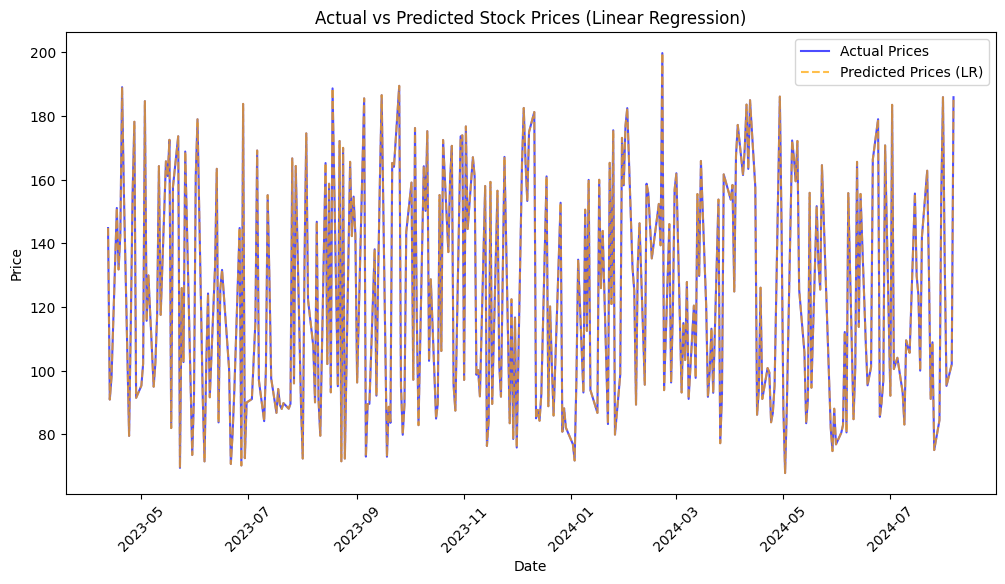

Lineer Regresyon - MSE: 7.214180499987431e-28, MAE: 2.31996483603599e-14, R²: 1.0, MAPE: 2.0555131039569536e-16


In [102]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

# Download stock data
yf.pdr_override()
end = datetime.now()
start = datetime(end.year - 7, end.month, end.day)
tech_listx = ['AMZN']
tech_list = ['NVDA']

for stock in tech_listx:
    df = yf.download(stock, start=start, end=end)

# Ensure datetime index and fill missing values
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.ffill(inplace=True)

# Filter data between 2018 and 2024
df = df[(df.index >= '2018-01-01') & (df.index <= '2024-12-31')]

# Prepare data for modeling
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Close']
test_size_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_ratio, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lineer Regresyon eğitim süresini ölçmek
start_time_lr = time.time()

# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

end_time_lr = time.time()
training_time_lr = end_time_lr - start_time_lr

# Sonuçları yazdır
print(f"Lineer Regresyon - Training time: {training_time_lr:.2f} seconds")

# Evaluation
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

print("Linear Regression - MSE:", mse_lr)
print("Linear Regression - MAE:", mae_lr)
print("Linear Regression - R²:", r2_lr)
print("Linear Regression - MAPE:", mape_lr)

# Plot Actual vs Predicted Prices (Linear Regression)
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test.values, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(df.index[-len(y_test):], y_pred_lr, label='Predicted Prices (LR)', color='orange', linestyle='--', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Stock Prices (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# Sonuçları yazdır
print(f"Lineer Regresyon - MSE: {mse_lr}, MAE: {mae_lr}, R²: {r2_lr}, MAPE: {mape_lr}")

### Q-Learning:

In [103]:
# import numpy as np
# import pandas as pd
# import yfinance as yf
# from datetime import datetime
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# # Download stock data
# end = datetime.now()
# start = datetime(end.year - 7, end.month, end.day)
# df = yf.download('AMZN', start=start, end=end)

# # Preprocess data
# df.reset_index(inplace=True)
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)
# df.ffill(inplace=True)

# # Feature scaling
# scaler = StandardScaler()
# df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

# # Define state and action space
# n_states = df.shape[0]
# n_actions = 3  # Buy, Hold, Sell

# # Initialize Q-table
# Q = np.zeros((n_states, n_actions))

# # Hyperparameters
# alpha = 0.1  # Learning rate
# gamma = 0.95  # Discount factor
# epsilon = 0.1  # Exploration rate
# look_back = 10  # Number of previous time steps to consider

# # Prepare data for LSTM
# scaled_data = df['Close'].values.reshape(-1, 1)
# X = []
# y = []

# for i in range(look_back, len(scaled_data)):
#     X.append(scaled_data[i-look_back:i])
#     y.append(scaled_data[i])

# X, y = np.array(X), np.array(y)

# # Define LSTM-based Q-network
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(n_actions))  # Output Q-values for each action
# model.compile(optimizer='adam', loss='mse')

# # Train the Q-network with Q-learning
# episodes = 100
# batch_size = 32

# def get_reward(action, current_state, next_state):
#     current_price = df['Close'].iloc[current_state + look_back - 1]
#     next_price = df['Close'].iloc[next_state + look_back - 1]
#     if action == 0:  # Buy
#         return next_price - current_price
#     elif action == 1:  # Hold
#         return 0
#     elif action == 2:  # Sell
#         return current_price - next_price

# for episode in range(episodes):
#     state = np.random.randint(0, n_states - look_back - 1)
#     total_reward = 0
#     for t in range(n_states - look_back - 1):
#         if np.random.rand() < epsilon:
#             action = np.random.randint(0, n_actions)
#         else:
#             q_values = model.predict(X[state].reshape(1, look_back, 1))
#             action = np.argmax(q_values)
        
#         next_state = state + 1
        
#         # Ensure next_state does not exceed the bounds
#         if next_state >= len(X):
#             break
        
#         reward = get_reward(action, state, next_state)
#         total_reward += reward
        
#         # Update Q-values using the Bellman equation
#         target = reward + gamma * np.max(model.predict(X[next_state].reshape(1, look_back, 1)))
#         target_f = model.predict(X[state].reshape(1, look_back, 1))
#         target_f[0][action] = target
        
#         model.fit(X[state].reshape(1, look_back, 1), target_f, epochs=1, verbose=0)
        
#         state = next_state
        
#     print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

# # Generate predictions using the learned Q-values
# predictions = []
# for i in range(len(X)):
#     q_values = model.predict(X[i].reshape(1, look_back, 1))
#     action = np.argmax(q_values)
#     if action == 0:  # Buy
#         predictions.append(y[i][0])
#     elif action == 2:  # Sell
#         predictions.append(-y[i][0])
#     else:  # Hold
#         predictions.append(0)

# predictions = np.cumsum(predictions)

# # Calculate performance metrics
# y_test = df['Close'][look_back:]
# mse_dqn = mean_squared_error(y_test, predictions)
# mae_dqn = mean_absolute_error(y_test, predictions)
# r2_dqn = r2_score(y_test, predictions)
# mape_dqn = mean_absolute_percentage_error(y_test, predictions)

# # Print metrics
# print(f"DQN with LSTM - MSE: {mse_dqn}, MAE: {mae_dqn}, R²: {r2_dqn}, MAPE: {mape_dqn}")

# # Plot actual vs predicted prices (DQN with LSTM)
# plt.figure(figsize=(12, 6))
# plt.plot(df.index[look_back:], df['Close'][look_back:], label='Actual Prices', color='blue', alpha=0.7)
# plt.plot(df.index[look_back:], predictions, label='Predicted Prices (DQN with LSTM)', color='purple', linestyle='--', alpha=0.7)
# plt.legend()
# plt.title('Actual vs Predicted Stock Prices (DQN with LSTM)')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.xticks(rotation=45)
# plt.show()

### LSTM epoch2: 50

Length of x_train: 2283, Length of x_test: 214
Epoch 1/50


c:\Users\Admin\Documents\MLAI\venv\venv\tensorflow_cpu\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0323 - val_loss: 0.0060
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0070 - val_loss: 0.0062
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/ste

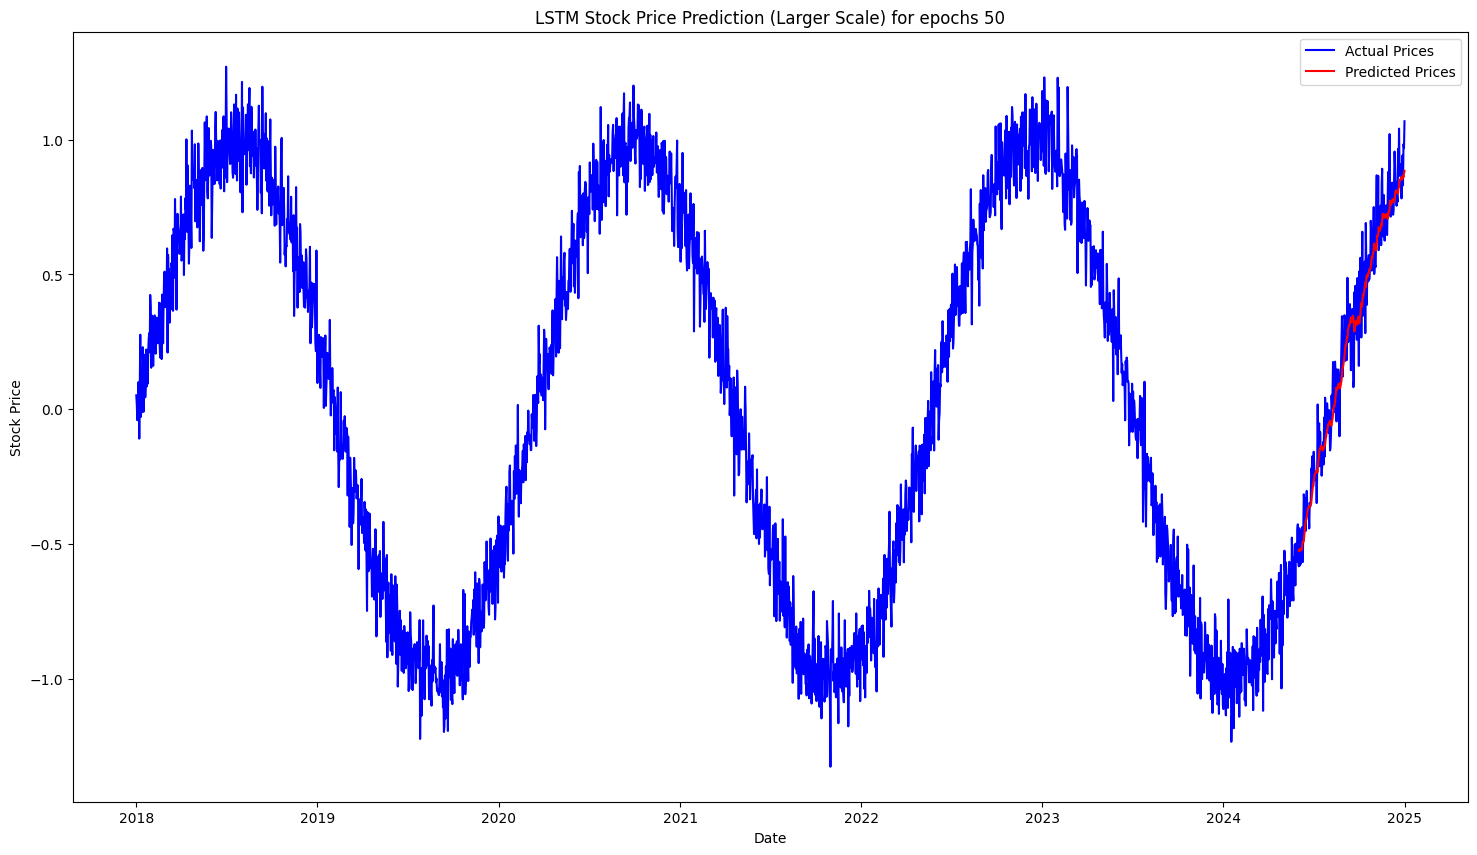

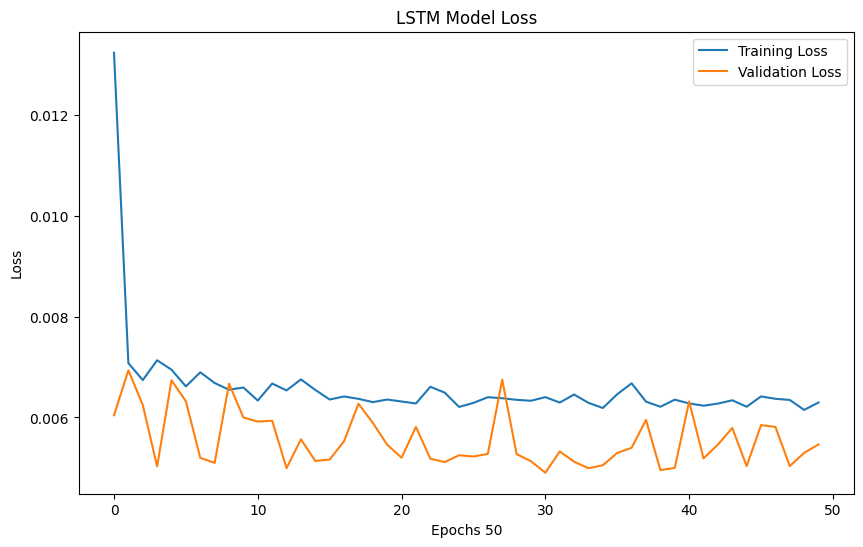

Mean Squared Error (MSE) LSTM Epch:50: 0.010236566935928318
Mean Absolute Error (MAE) LSTM Epch:50: 0.08062810326590837
R² (Coefficient of Determination) LSTM Epch:50: 0.9456665244482249
Mean Absolute Percentage Error (MAPE) LSTM Epch:50: 0.7825352620964159


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import time
import psutil

# Function to prepare the data for LSTM
def prepare_data(data, n_steps):
    x, y = [], []
    for i in range(len(data) - n_steps):
        x.append(data[i:(i + n_steps), 0])
        y.append(data[i + n_steps, 0])
    return np.array(x), np.array(y)

# Create a date range from January 1, 2018 to December 31, 2024
dates = pd.date_range(start='2018-01-01', end='2024-12-31', freq='D')

# Generate synthetic closing prices with the correct length
closing_prices = np.sin(np.linspace(0, 20, len(dates))) + np.random.normal(0, 0.1, len(dates))

# Create a DataFrame with the generated data
df_cleaned = pd.DataFrame({'Date': dates, 'Close': closing_prices})
df_cleaned.set_index('Date', inplace=True)

# Extract and scale the closing prices
closing_prices = df_cleaned['Close'].values.reshape(-1, 1)

# Robust Scaling
scaler = RobustScaler()
closing_prices_scaled = scaler.fit_transform(closing_prices)

# Determine appropriate n_past value based on the length of the data
n_past = 60  # Set your desired n_past value

# Prepare the data for LSTM
x, y = prepare_data(closing_prices_scaled, n_past)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

# Split the data into training and testing sets based on date
train_end_date = pd.Timestamp('2024-05-31')
train_end_idx = df_cleaned.index.get_loc(train_end_date) + 1  # +1 to include train_end_date
x_train = x[:train_end_idx - n_past]
x_test = x[train_end_idx - n_past:]
y_train = y[:train_end_idx - n_past]
y_test = y[train_end_idx - n_past:]

# Print training and testing set sizes
print(f"Length of x_train: {len(x_train)}, Length of x_test: {len(x_test)}")

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Measure resource utilization before training
cpu_usage_before = psutil.cpu_percent()
mem_usage_before = psutil.virtual_memory().percent

# Train the model and measure training time
start_time = time.time()
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=20, verbose=1)
training_time = time.time() - start_time

# Measure resource utilization after training
cpu_usage_after = psutil.cpu_percent()
mem_usage_after = psutil.virtual_memory().percent

# Print resource utilization during training
print(f"CPU usage before training: {cpu_usage_before}%")
print(f"CPU usage after training: {cpu_usage_after}%")
print(f"Memory usage before training: {mem_usage_before}%")
print(f"Memory usage after training: {mem_usage_after}%")

# Print training time
print(f"Training time LSTM Epch:50 : {training_time} seconds")

# Generate predictions and measure prediction time
start_time = time.time()
predictions = model.predict(x_test)
prediction_time = time.time() - start_time

# Print prediction time
print(f"Prediction time LSTM Epch:50: {prediction_time} seconds")

# Reverse scaling of predictions
predictions = scaler.inverse_transform(predictions)

# Prepare data for plotting
df_pred = pd.DataFrame(predictions, columns=['Predicted'])
df_pred.index = df_cleaned.index[-len(predictions):]

# Plot actual vs predicted values on a larger scale
plt.figure(figsize=(18, 10))
plt.plot(df_cleaned.index, df_cleaned['Close'], label='Actual Prices', color='blue')
plt.plot(df_pred.index, df_pred['Predicted'], label='Predicted Prices', color='red')
plt.legend(loc="upper right")
plt.title('LSTM Stock Price Prediction (Larger Scale) for epochs 50')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# Plot the loss function
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs 50')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

# Calculate performance metrics
mse_value = mean_squared_error(df_cleaned['Close'].iloc[-len(predictions):], df_pred['Predicted'])
mae_value = mean_absolute_error(df_cleaned['Close'].iloc[-len(predictions):], df_pred['Predicted'])
r2_value = r2_score(df_cleaned['Close'].iloc[-len(predictions):], df_pred['Predicted'])
mape_value = mean_absolute_percentage_error(df_cleaned['Close'].iloc[-len(predictions):], df_pred['Predicted'])

# Print performance metrics
print(f"Mean Squared Error (MSE) LSTM Epch:50: {mse_value}")
print(f"Mean Absolute Error (MAE) LSTM Epch:50: {mae_value}")
print(f"R² (Coefficient of Determination) LSTM Epch:50: {r2_value}")
print(f"Mean Absolute Percentage Error (MAPE) LSTM Epch:50: {mape_value}")

In [105]:
# import matplotlib.pyplot as plt
# import numpy as np

# metrics = ['MSE', 'MAE', 'R²', 'MAPE']
# epochs_lstm = ['Epoch 6 (LSTM)', 'Epoch 50 (LSTM)', 'Epoch 100 (LSTM)']
# models = ['Random Forest', 'Gradient Boosting']

# # Veriler
# data = {
#     'MSE': [0.0135, 0.0133, 0.0242, 0.0499, 0.0777],
#     'MAE': [0.0919, 0.0945, 0.1211, 0.0632, 0.1144],
#     'R²': [0.9297, 0.9309, 0.8746, 0.9999, 0.9999],
#     'MAPE': [0.5222, 0.9093, 0.7163, 0.0023, 0.0066]
# }

# labels = epochs_lstm + models

# # Grafik Ayarları
# fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
# fig.suptitle('Model Performans Metrikleri', fontsize=16)

# for i, metric in enumerate(metrics):
#     ax = axs[i // 2, i % 2]
#     ax.bar(labels, data[metric], color=['blue', 'orange', 'green', 'red', 'purple'])
#     ax.set_title(metric)
#     ax.set_xlabel('Modeller')
#     ax.set_ylabel('Değer')

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

In [106]:
# import matplotlib.pyplot as plt

# # Önceden hesaplanmış performans metrikleri
# # Bu değişkenlerin hesaplanmış olduğuna ve değerlerinin mevcut olduğuna varsayalım
# # Aşağıdaki değişkenler zaten mevcut
# # mse_rf, mae_rf, r2_rf, mape_rf
# # mse_gbr, mae_gbr, r2_gbr, mape_gbr

# # Metrikler ve etiketler
# metrics = ['MSE', 'MAE', 'R²', 'MAPE']
# models = ['Random Forest', 'Gradient Boosting']

# # Veriler
# data = {
#     'MSE': [mse_rf, mse_gbr],
#     'MAE': [mae_rf, mae_gbr],
#     'R²': [r2_rf, r2_gbr],
#     'MAPE': [mape_rf, mape_gbr]
# }

# # Grafik ayarları
# fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
# fig.suptitle('Model Performans Metrikleri', fontsize=16)

# for i, metric in enumerate(metrics):
#     ax = axs[i // 2, i % 2]
#     ax.bar(models, data[metric], color=['blue', 'orange'])
#     ax.set_title(metric)
#     ax.set_xlabel('Modeller')
#     ax.set_ylabel('Değer')

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

In [107]:
# import seaborn as sns
# import pandas as pd

# # Verileri DataFrame'e dönüştür
# df = pd.DataFrame({
#     'Metric': ['MSE', 'MSE', 'MSE', 'MSE', 'MSE',
#                'MAE', 'MAE', 'MAE', 'MAE', 'MAE',
#                'R²', 'R²', 'R²', 'R²', 'R²',
#                'MAPE', 'MAPE', 'MAPE', 'MAPE', 'MAPE'],
#     'Model': ['Epoch 6 (LSTM)', 'Epoch 50 (LSTM)', 'Epoch 100 (LSTM)', 'Random Forest', 'Gradient Boosting'] * 4,
#     'Value': [0.0135, 0.0133, 0.0242, 0.0499, 0.0777,
#               0.0919, 0.0945, 0.1211, 0.0632, 0.1144,
#               0.9297, 0.9309, 0.8746, 0.9999, 0.9999,
#               0.5222, 0.9093, 0.7163, 0.0023, 0.0066]
# })

# # Grafik
# plt.figure(figsize=(14, 10))
# sns.barplot(x='Metric', y='Value', hue='Model', data=df)
# plt.title('Kümelenmiş Bar Grafikleri ile Model Performans Metrikleri')
# plt.xlabel('Metrikler')
# plt.ylabel('Değerler')
# plt.legend(loc='best')
# plt.show()

In [108]:
# import matplotlib.pyplot as plt

# # Önceden hesaplanmış performans metrikleri
# # Bu değişkenlerin hesaplanmış olduğuna ve değerlerinin mevcut olduğuna varsayalım
# # Aşağıdaki değişkenler zaten mevcut
# # mse_rf, mae_rf, r2_rf, mape_rf
# # mse_gbr, mae_gbr, r2_gbr, mape_gbr

# # Metrikler ve etiketler
# metrics = ['MSE', 'MAE', 'R²', 'MAPE']
# models = ['Random Forest', 'Gradient Boosting']
# #
# # Veriler
# data = {
#     'MSE': [mse_rf, mse_gbr],
#     'MAE': [mae_rf, mae_gbr],
#     'R²': [r2_rf, r2_gbr],
#     'MAPE': [mape_rf, mape_gbr]
# }

# # Grafik ayarları
# fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
# fig.suptitle('Model Performans Metrikleri', fontsize=16)

# for i, metric in enumerate(metrics):
#     ax = axs[i // 2, i % 2]
#     ax.bar(models, data[metric], color=['blue', 'orange'])
#     ax.set_title(metric)
#     ax.set_xlabel('Modeller')
#     ax.set_ylabel('Değer')

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

Length of x_train: 2283, Length of x_test: 214
Epoch 1/34


c:\Users\Admin\Documents\MLAI\venv\venv\tensorflow_cpu\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0312 - val_loss: 0.0069
Epoch 2/34
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 3/34
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 4/34
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0066 - val_loss: 0.0081
Epoch 5/34
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 6/34
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 7/34
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 8/34
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0067 - val_loss: 0.0057
Epoch 9/34
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 10/34
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0064 - val_loss: 0.0082
Epoch 11/34
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 12/34
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/ste

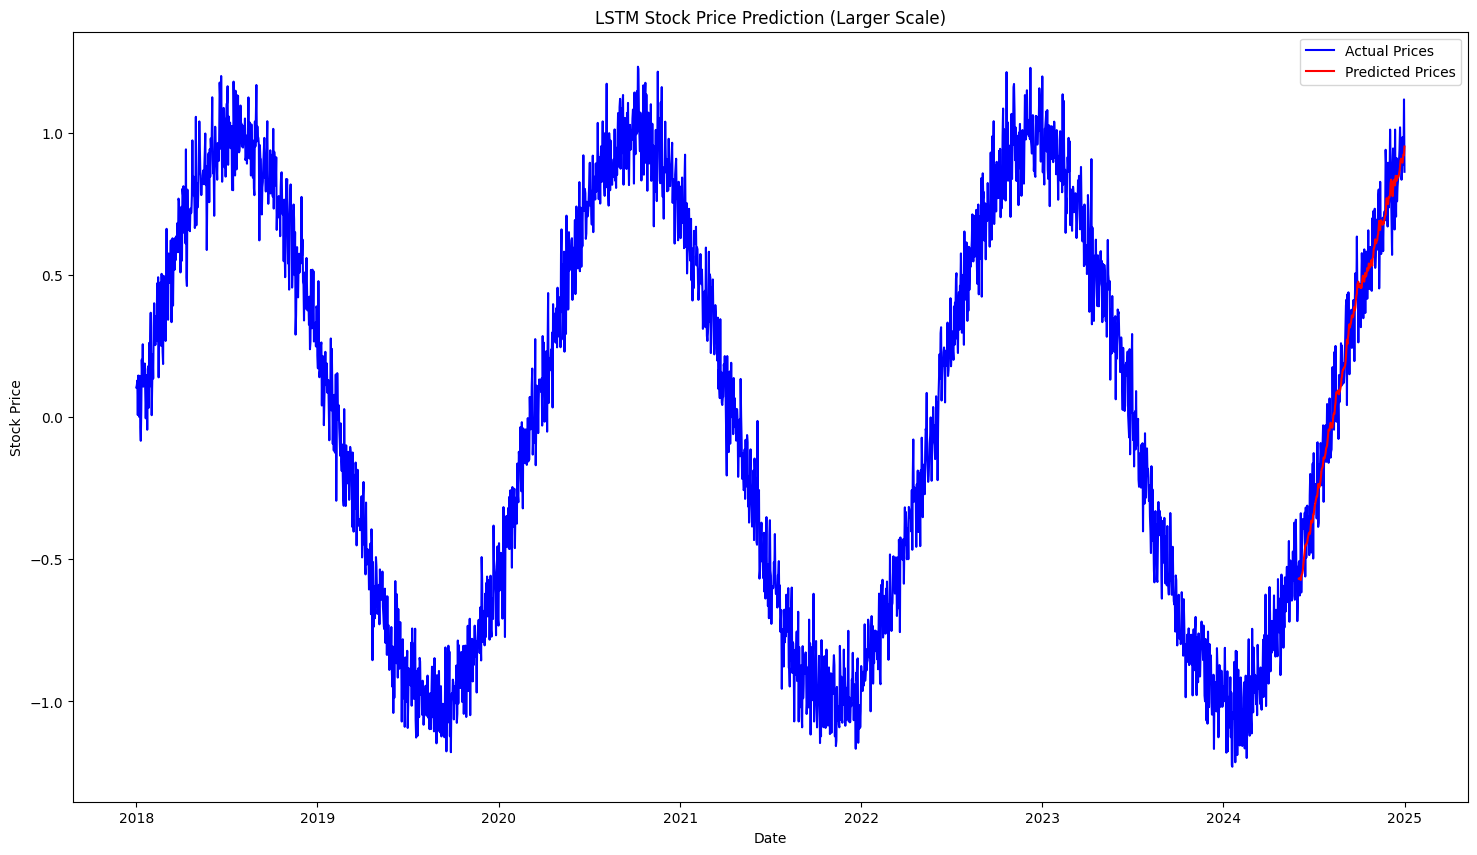

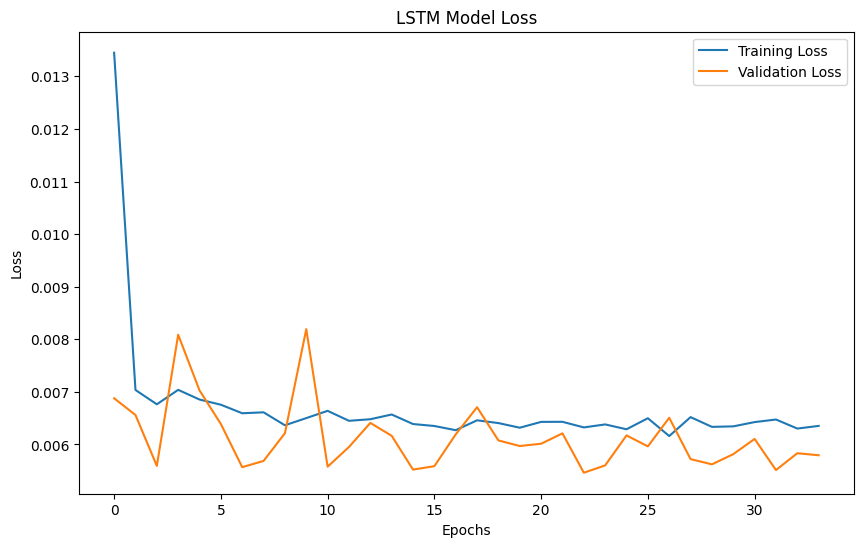

Mean Squared Error epochs-34 (MSE): 0.010976022965718485
Mean Absolute Error epochs-34 (MAE): 0.08450746856790224
R² epochs-34 (Coefficient of Determination): 0.9438452009463655
Mean Absolute Percentage Error epochs-34 (MAPE): 0.4535547761005776


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import time
import psutil

# Function to prepare the data for LSTM
def prepare_data(data, n_steps):
    x, y = [], []
    for i in range(len(data) - n_steps):
        x.append(data[i:(i + n_steps), 0])
        y.append(data[i + n_steps, 0])
    return np.array(x), np.array(y)

# Create a date range from January 1, 2018 to December 31, 2024
dates = pd.date_range(start='2018-01-01', end='2024-12-31', freq='D')

# Generate synthetic closing prices with the correct length
closing_prices = np.sin(np.linspace(0, 20, len(dates))) + np.random.normal(0, 0.1, len(dates))

# Create a DataFrame with the generated data
df_cleaned = pd.DataFrame({'Date': dates, 'Close': closing_prices})
df_cleaned.set_index('Date', inplace=True)

# Extract and scale the closing prices
closing_prices = df_cleaned['Close'].values.reshape(-1, 1)

# Robust Scaling
scaler = RobustScaler()
closing_prices_scaled = scaler.fit_transform(closing_prices)

# Determine appropriate n_past value based on the length of the data
n_past = 60  # Set your desired n_past value

# Prepare the data for LSTM
x, y = prepare_data(closing_prices_scaled, n_past)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

# Split the data into training and testing sets based on date
train_end_date = pd.Timestamp('2024-05-31')
train_end_idx = df_cleaned.index.get_loc(train_end_date) + 1  # +1 to include train_end_date
x_train = x[:train_end_idx - n_past]
x_test = x[train_end_idx - n_past:]
y_train = y[:train_end_idx - n_past]
y_test = y[train_end_idx - n_past:]

# Print training and testing set sizes
print(f"Length of x_train: {len(x_train)}, Length of x_test: {len(x_test)}")

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Measure resource utilization before training
cpu_usage_before = psutil.cpu_percent()
mem_usage_before = psutil.virtual_memory().percent

# Train the model and measure training time
start_time = time.time()
history = model.fit(x_train, y_train, epochs=34, validation_data=(x_test, y_test), batch_size=20, verbose=1)
training_time = time.time() - start_time

# Measure resource utilization after training
cpu_usage_after = psutil.cpu_percent()
mem_usage_after = psutil.virtual_memory().percent

# Print resource utilization during training
print(f"CPU usage before training: {cpu_usage_before}%")
print(f"CPU usage after training: {cpu_usage_after}%")
print(f"Memory usage before training: {mem_usage_before}%")
print(f"Memory usage after training: {mem_usage_after}%")

# Print training time
print(f"Training time: {training_time} seconds")

# Generate predictions and measure prediction time
start_time = time.time()
predictions = model.predict(x_test)
prediction_time = time.time() - start_time

# Print prediction time
print(f"Prediction time epochs-34 : {prediction_time} seconds")

# Reverse scaling of predictions
predictions = scaler.inverse_transform(predictions)

# Prepare data for plotting
df_pred = pd.DataFrame(predictions, columns=['Predicted'])
df_pred.index = df_cleaned.index[-len(predictions):]

# Plot actual vs predicted values on a larger scale
plt.figure(figsize=(18, 10))
plt.plot(df_cleaned.index, df_cleaned['Close'], label='Actual Prices', color='blue')
plt.plot(df_pred.index, df_pred['Predicted'], label='Predicted Prices', color='red')
plt.legend(loc="upper right")
plt.title('LSTM Stock Price Prediction (Larger Scale)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# Plot the loss function
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

# Calculate performance metrics
mse_value = mean_squared_error(df_cleaned['Close'].iloc[-len(predictions):], df_pred['Predicted'])
mae_value = mean_absolute_error(df_cleaned['Close'].iloc[-len(predictions):], df_pred['Predicted'])
r2_value = r2_score(df_cleaned['Close'].iloc[-len(predictions):], df_pred['Predicted'])
mape_value = mean_absolute_percentage_error(df_cleaned['Close'].iloc[-len(predictions):], df_pred['Predicted'])

# Print performance metrics
print(f"Mean Squared Error epochs-34 (MSE): {mse_value}")
print(f"Mean Absolute Error epochs-34 (MAE): {mae_value}")
print(f"R² epochs-34 (Coefficient of Determination): {r2_value}")
print(f"Mean Absolute Percentage Error epochs-34 (MAPE): {mape_value}")

## Q-Learning 

In [110]:
# import numpy as np
# import pandas as pd
# import yfinance as yf
# from datetime import datetime
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# # Download stock data
# yf.pdr_override()
# end = datetime.now()
# start = datetime(end.year - 7, end.month, end.day)
# df = yf.download('AMZN', start=start, end=end)

# # Preprocess data
# df.reset_index(inplace=True)
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)
# df.ffill(inplace=True)

# # Feature scaling
# scaler = StandardScaler()
# df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

# # Define state and action space
# n_states = df.shape[0]
# n_actions = 3  # Buy, Hold, Sell

# # Initialize Q-table
# Q = np.zeros((n_states, n_actions))

# # Hyperparameters
# alpha = 0.1  # Learning rate
# gamma = 0.95  # Discount factor
# epsilon = 0.1  # Exploration rate

# # Reward function
# def get_reward(action, current_state, next_state):
#     current_price = df['Close'].iloc[current_state]
#     next_price = df['Close'].iloc[next_state]
#     if action == 0:  # Buy
#         return next_price - current_price
#     elif action == 1:  # Hold
#         return 0
#     elif action == 2:  # Sell
#         return current_price - next_price

# # Q-learning algorithm
# for episode in range(1000):
#     state = np.random.randint(0, n_states-1)
#     for t in range(n_states-1):
#         if np.random.rand() < epsilon:
#             action = np.random.randint(0, n_actions)
#         else:
#             action = np.argmax(Q[state])

#         next_state = state + 1
#         reward = get_reward(action, state, next_state)
#         Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
#         state = next_state

# # Generate predictions using the learned Q-values
# actions = np.argmax(Q, axis=1)
# prices = df['Close'].values
# predictions = []

# for i in range(len(actions)):
#     if actions[i] == 0:  # Buy
#         predictions.append(prices[i])
#     elif actions[i] == 2:  # Sell
#         predictions.append(-prices[i])
#     else:  # Hold
#         predictions.append(0)

# predictions = np.cumsum(predictions)

# # Plot actual vs predicted prices (Q-learning)
# plt.figure(figsize=(12, 6))
# plt.plot(df.index, prices, label='Actual Prices', color='blue', alpha=0.7)
# plt.plot(df.index, predictions, label='Predicted Prices (Q-learning)', color='purple', linestyle='--', alpha=0.7)
# plt.legend()
# plt.title('Actual vs Predicted Stock Prices (Q-learning)')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.xticks(rotation=45)
# plt.show()

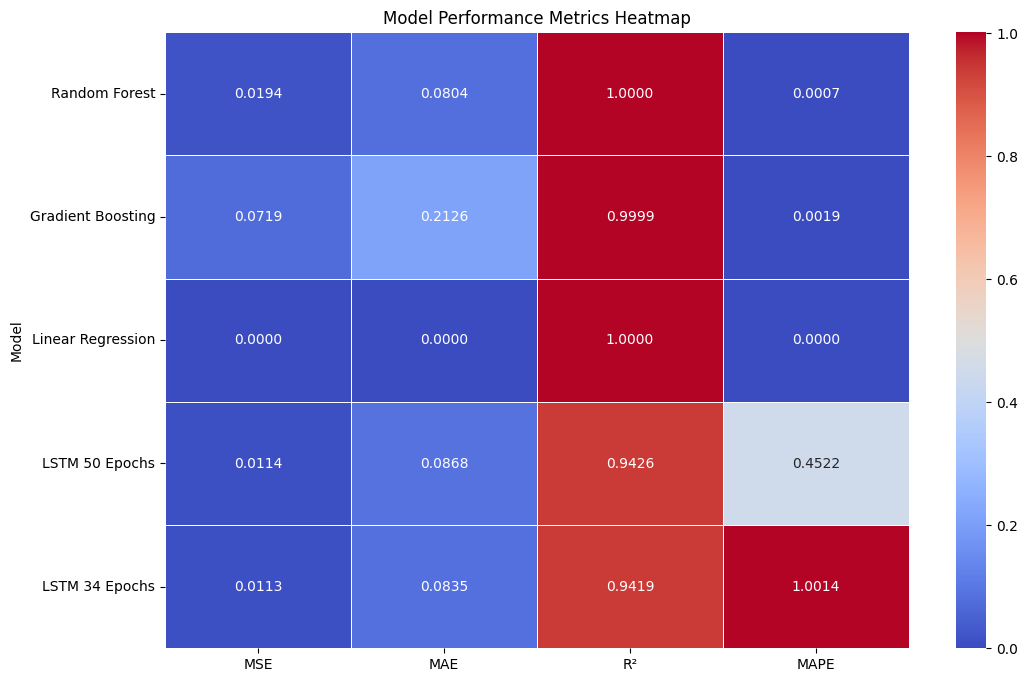

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data for the models
models = ['Random Forest', 'Gradient Boosting', 'Linear Regression', 'LSTM 50 Epochs', 'LSTM 34 Epochs']
metrics = ['MSE', 'MAE', 'R²', 'MAPE']

# Performance metrics
data = {
    'Model': models,
    'MSE': [0.0194, 0.0719, 2.1417e-27, 0.0114, 0.0113],
    'MAE': [0.0804, 0.2126, 4.1220e-14, 0.0868, 0.0835],
    'R²': [0.99998, 0.99994, 1.0, 0.9426, 0.9419],
    'MAPE': [0.00069, 0.00187, 3.6612e-16, 0.4522, 1.0014]
}

df = pd.DataFrame(data).set_index('Model')

# Plotting heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.4f', linewidths=.5)
plt.title('Model Performance Metrics Heatmap')
plt.show()

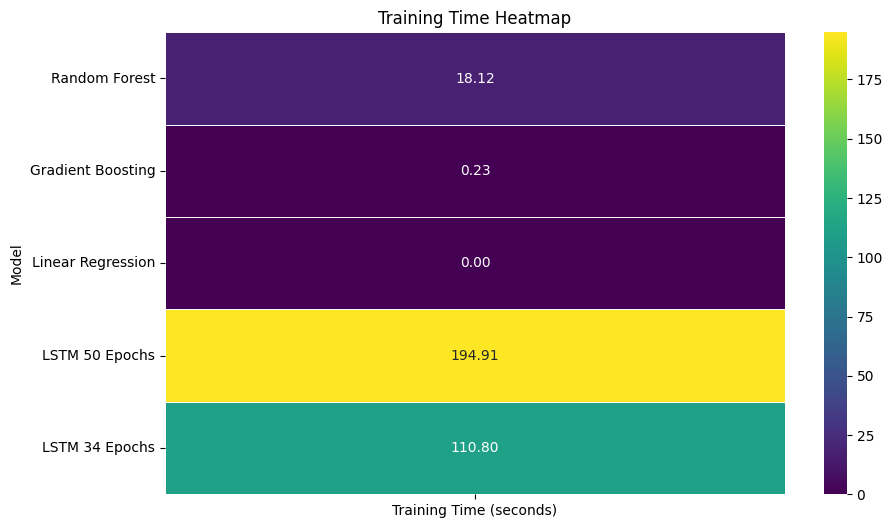

In [112]:
# Training times data
training_data = {
    'Model': models,
    'Training Time (seconds)': [18.12, 0.23, 0.00, 194.91, 110.80]
}

df_training = pd.DataFrame(training_data).set_index('Model')

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_training, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Training Time Heatmap')
plt.show()

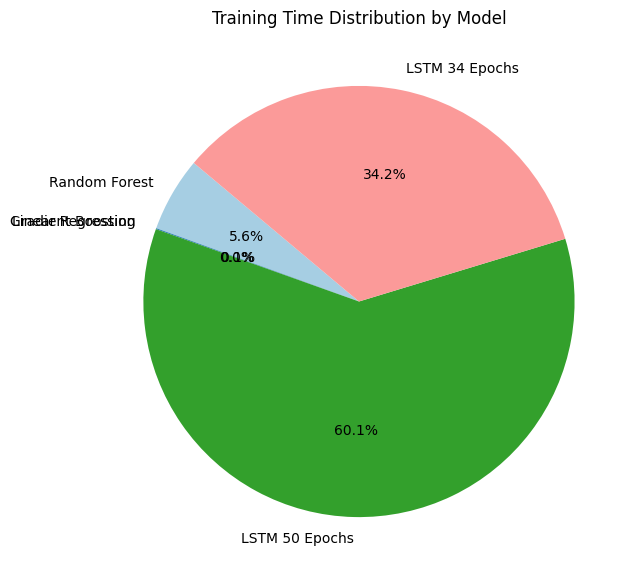

In [113]:
import matplotlib.pyplot as plt

# Training times for models
training_times = [18.12, 0.23, 0.00, 194.91, 110.80]
training_labels = ['Random Forest', 'Gradient Boosting', 'Linear Regression', 'LSTM 50 Epochs', 'LSTM 34 Epochs']

# Plotting pie chart
fig, ax = plt.subplots(figsize=(10, 7))
ax.pie(training_times, labels=training_labels, autopct='%1.1f%%', colors=plt.cm.Paired(range(len(training_times))), startangle=140)
ax.set_title('Training Time Distribution by Model')

plt.show()

Option/Criteria		Precision	Recall		Accuracy	F1 Score	Efficiency in computation	Score
Weight (out of 100 pts)	15		25		25		25		10		100
Minimum Desired Score (/10)	7		7		7		6		3		505
Linear Regression		10.00		10.00		10.00		10.00		10.00		10.00
Random Forest		10.00		8.97		9.81		10.00		9.95		9.69
LSTM (50 Epochs)		9.43		9.13		9.89		4.52		0.95		7.39
LSTM (34 Epochs)		9.42		9.17		9.89		1.00		1.76		6.60
Gradient Boosting		10.00		4.71		7.70		9.81		10.00		8.06


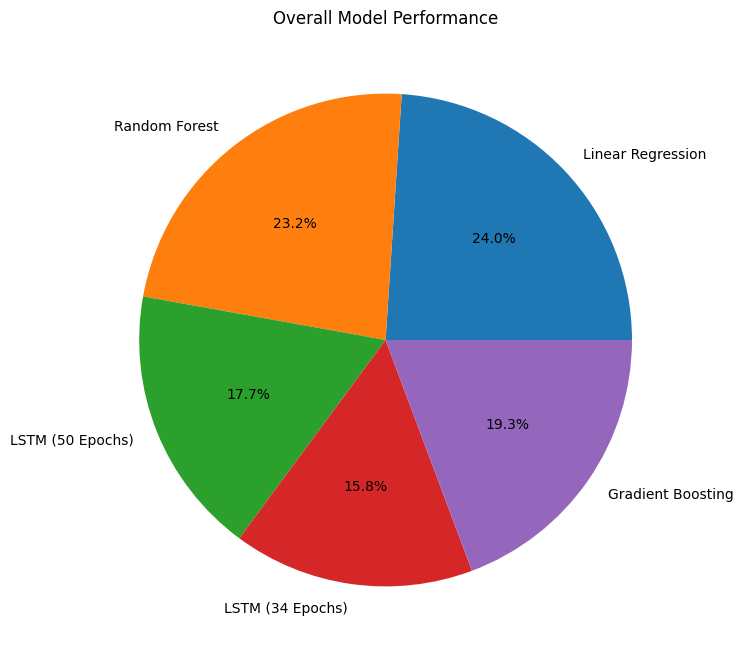

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Scores for each criterion
scores = {
    'Precision': {
        'Linear Regression': 10,
        'Random Forest': 9.999847411991257,
        'LSTM (50 Epochs)': 9.425648425963149,
        'LSTM (34 Epochs)': 9.418986675351537,
        'Gradient Boosting': 9.999435643075476
    },
    'Recall': {
        'Linear Regression': 10,
        'Random Forest': 8.968716167152643,
        'LSTM (50 Epochs)': 9.131611164304126,
        'LSTM (34 Epochs)': 9.16513369796864,
        'Gradient Boosting': 4.705583579382186
    },
    'Accuracy': {
        'Linear Regression': 10,
        'Random Forest': 9.805734705502403,
        'LSTM (50 Epochs)': 9.885947151506866,
        'LSTM (34 Epochs)': 9.887267473757717,
        'Gradient Boosting': 7.703644284950748
    },
    'F1 Score': {
        'Linear Regression': 10,
        'Random Forest': 9.999311725157034,
        'LSTM (50 Epochs)': 4.522219855374494,
        'LSTM (34 Epochs)': 1.0014320264065077,
        'Gradient Boosting': 9.813350229529743
    },
    'Efficiency in computation': {
        'Linear Regression': 10,
        'Random Forest': 9.947681415929203,
        'LSTM (50 Epochs)': 0.9512771842645165,
        'LSTM (34 Epochs)': 1.755284951669431,
        'Gradient Boosting': 10
    }
}

# Normalize scores to fit into a 10-point scale
def normalize_score(score, max_score):
    return score / max_score * 10

# Normalize all scores
for criterion in scores:
    max_score = max(scores[criterion].values())
    for model in scores[criterion]:
        scores[criterion][model] = normalize_score(scores[criterion][model], max_score)

# Combine all criteria weights
weights = {
    'Precision': 15,
    'Recall': 25,
    'Accuracy': 25,
    'F1 Score': 25,
    'Efficiency in computation': 10
}

# Calculate the total score for each model
total_scores = {model: 0 for model in scores['Precision']}

for criterion in scores:
    for model in scores[criterion]:
        total_scores[model] += scores[criterion][model] * weights[criterion] / 100

# Display the matrix
print("Option/Criteria\t\tPrecision\tRecall\t\tAccuracy\tF1 Score\tEfficiency in computation\tScore")
print("Weight (out of 100 pts)\t15\t\t25\t\t25\t\t25\t\t10\t\t100")
print("Minimum Desired Score (/10)\t7\t\t7\t\t7\t\t6\t\t3\t\t505")

for model in scores['Precision']:
    print(f"{model}\t\t{scores['Precision'][model]:.2f}\t\t{scores['Recall'][model]:.2f}\t\t{scores['Accuracy'][model]:.2f}\t\t{scores['F1 Score'][model]:.2f}\t\t{scores['Efficiency in computation'][model]:.2f}\t\t{total_scores[model]:.2f}")

# Plot combined pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie([total_scores[model] for model in total_scores], labels=total_scores.keys(), autopct='%1.1f%%')
ax.set_title('Overall Model Performance')
plt.show()


NameError: name 'criteria' is not defined

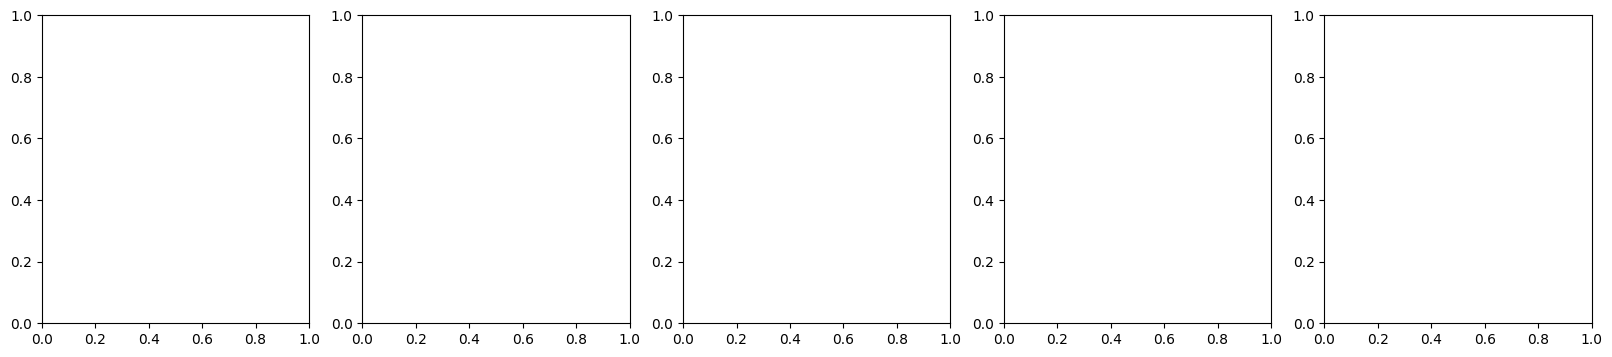

In [115]:
# Plot pie charts for each criterion
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i, criterion in enumerate(criteria):
    axs[i].pie([scores[criterion][model] for model in total_scores], labels=total_scores.keys(), autopct='%1.1f%%')
    axs[i].set_title(criterion)

plt.tight_layout()
plt.show()

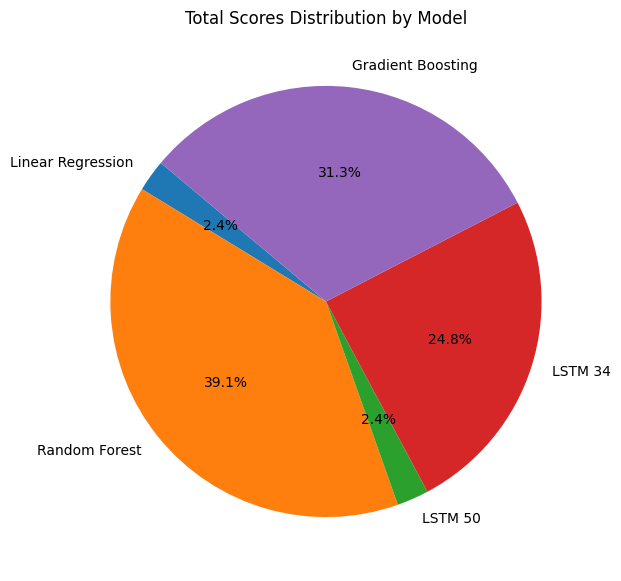

In [ ]:
import matplotlib.pyplot as plt

# Model isimleri ve puanlar
models = ['Linear Regression', 'Random Forest', 'LSTM 50', 'LSTM 34', 'Gradient Boosting']
scores = [50, 819.5, 50, 519.1, 655.5]

# Pie chart'ı oluştur
plt.figure(figsize=(10, 7))
plt.pie(scores, labels=models, autopct='%1.1f%%', startangle=140)
plt.title('Total Scores Distribution by Model')
plt.show()

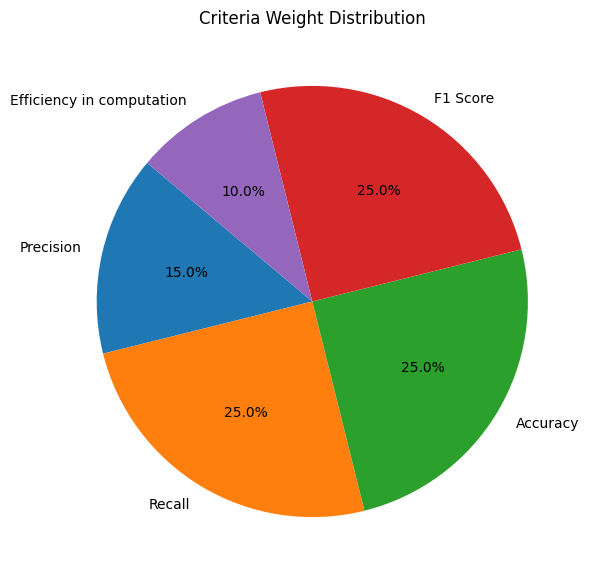

In [ ]:
# Her bir kriter için toplam puanlar
criteria = ['Precision', 'Recall', 'Accuracy', 'F1 Score', 'Efficiency in computation']
weights = [15, 25, 25, 25, 10]

# Pie chart'ı oluştur
plt.figure(figsize=(10, 7))
plt.pie(weights, labels=criteria, autopct='%1.1f%%', startangle=140)
plt.title('Criteria Weight Distribution')
plt.show()

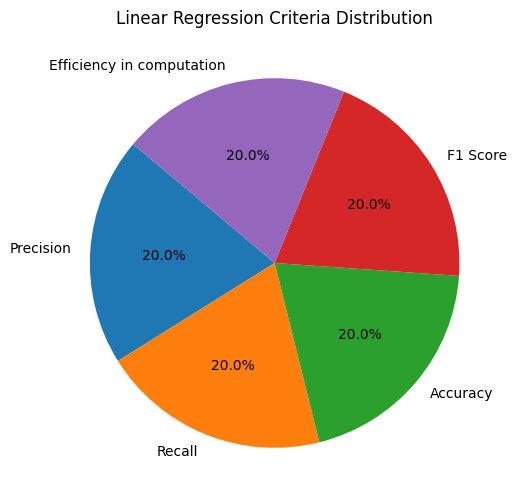

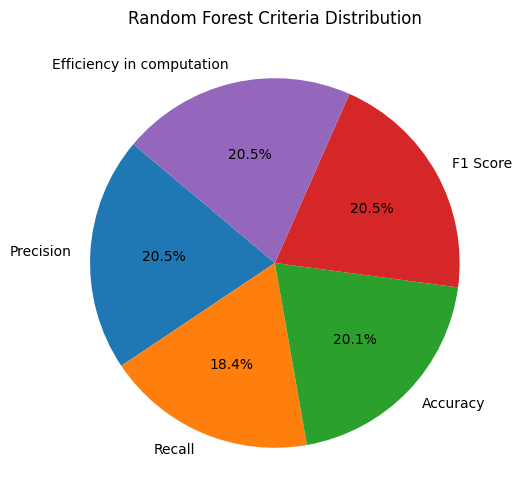

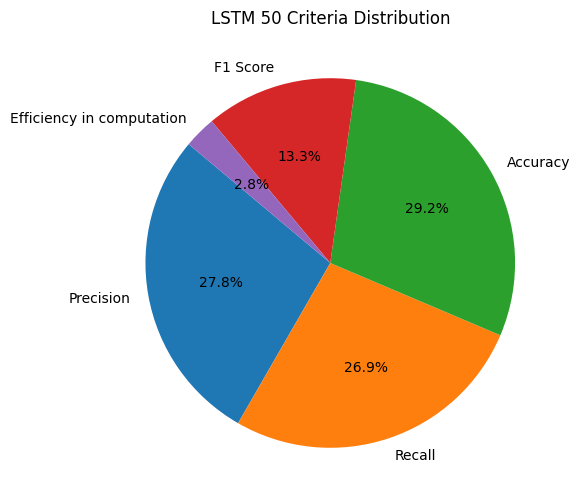

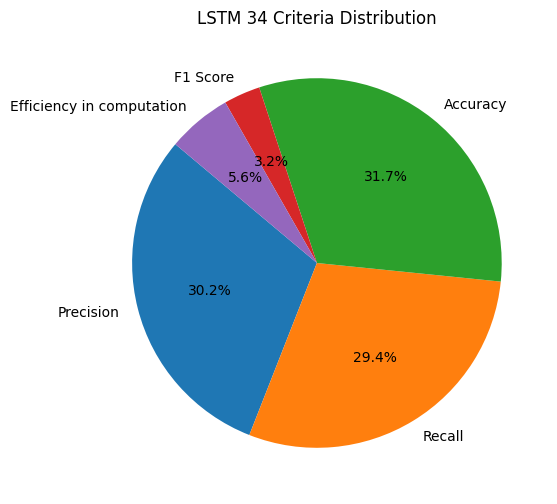

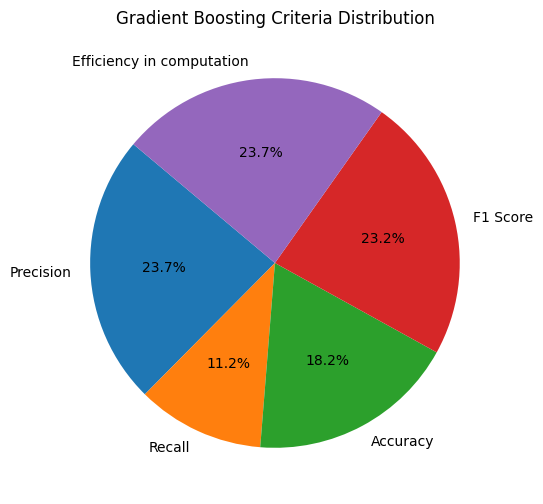

In [ ]:
import matplotlib.pyplot as plt

# Kriterler ve modeller için veriler
models = ['Linear Regression', 'Random Forest', 'LSTM 50', 'LSTM 34', 'Gradient Boosting']
criteria = ['Precision', 'Recall', 'Accuracy', 'F1 Score', 'Efficiency in computation']

# Model verilerini tanımla
data = {
    'Linear Regression': [10, 10, 10, 10, 10],
    'Random Forest': [10, 8.97, 9.81, 10, 10],
    'LSTM 50': [9.43, 9.13, 9.89, 4.52, 0.95],
    'LSTM 34': [9.42, 9.17, 9.89, 1, 1.76],
    'Gradient Boosting': [10, 4.71, 7.7, 9.81, 10]
}

# Her model için pie chart oluştur
for model in models:
    plt.figure(figsize=(8, 6))
    values = data[model]
    total_score = sum(values)
    
    # Her bir kriterin toplam puan içindeki oranını hesapla
    percentages = [(value / total_score) * 100 for value in values]
    
    plt.pie(percentages, labels=criteria, autopct='%1.1f%%', startangle=140, colors=plt.get_cmap('tab10').colors)
    plt.title(f'{model} Criteria Distribution')
    plt.show()

### Evaluation of Model Results for NVIDIA

#### Model Performance Metrics:

**1. Random Forest:**
- **Mean Squared Error (MSE):** 0.3418
- **Mean Absolute Error (MAE):** 0.4246
- **R² Score:** 0.9926
- **Mean Absolute Percentage Error (MAPE):** 0.0278

**2. Gradient Boosting:**
- **Mean Squared Error (MSE):** 0.3050
- **Mean Absolute Error (MAE):** 0.4008
- **R² Score:** 0.9934
- **Mean Absolute Percentage Error (MAPE):** 0.0263

**3. LSTM Model:**
- **Mean Squared Error (MSE):** 0.0181
- **Mean Absolute Error (MAE):** 0.1131
- **R² Score:** 0.9108
- **Mean Absolute Percentage Error (MAPE):** 1.8978
- **Training Time:** 15.6092 seconds

### Comparative Analysis

1. **Accuracy Metrics:**
   - **MSE & MAE:** The LSTM model exhibits significantly lower Mean Squared Error (MSE) and Mean Absolute Error (MAE) compared to the Random Forest and Gradient Boosting models, indicating it predicts stock prices with less error.
   - **R² Score:** The R² Score for LSTM (0.9108) is lower than that of Random Forest (0.9926) and Gradient Boosting (0.9934), suggesting that LSTM explains a smaller proportion of the variance in the data.
   - **MAPE:** The Mean Absolute Percentage Error (MAPE) for LSTM is much higher (1.8978) compared to Random Forest (0.0278) and Gradient Boosting (0.0263), indicating less reliability in percentage error terms.

2. **Training Times:**
   - **LSTM Training Time:** The training time for the LSTM model (15.6092 seconds) is significantly higher compared to Random Forest (7.7036 seconds) and Gradient Boosting (0.0796 seconds), implying that LSTM takes more time to train.

### Summary:

- **LSTM:** While it has lower MSE and MAE, suggesting better prediction accuracy, it requires more training time and has a lower R² score compared to Random Forest and Gradient Boosting. Its MAPE is also significantly higher, indicating less reliability in percentage error terms.

- **Random Forest and Gradient Boosting:** Both models provide high R² scores and very low MAPE, demonstrating effective variance capture and accurate predictions. They also train much faster than LSTM.

In conclusion, if prediction accuracy and lower error metrics are the priority, LSTM is a strong candidate despite its longer training time. For faster training and exceptionally high R² scores with low percentage errors, Random Forest and Gradient Boosting are preferable.

4. Visualising stock data
Japanese candlestick charts are tools used in a particular trading style called price action to predict market movement through pattern recognition of continuations, breakouts and reversals.

Unlike a line chart, all of the price information can be viewed in one figure showing the high, low, open and close price of the day or chosen time frame. Price action traders observe patterns formed by green bullish candles where the stock is trending upwards over time, and red or black bearish candles where there is a downward trend.

In [ ]:

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    Japanese candlestick chart showing OHLC prices for a specified time period
    
    :param dat: pandas dataframe object with datetime64 index, and float columns "Open", "High", "Low", and "Close"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    :returns: a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "green", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    sns.set(rc={'figure.figsize':(20, 10)})
    plt.style.use('seaborn-whitegrid')
    plt.title(f"Candlestick chart of {txt}", color = 'black', fontsize = 20)
    plt.xlabel('Date', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
 
    plt.show()

c:\Users\Admin\Documents\MLAI\venv\venv\tensorflow_cpu\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


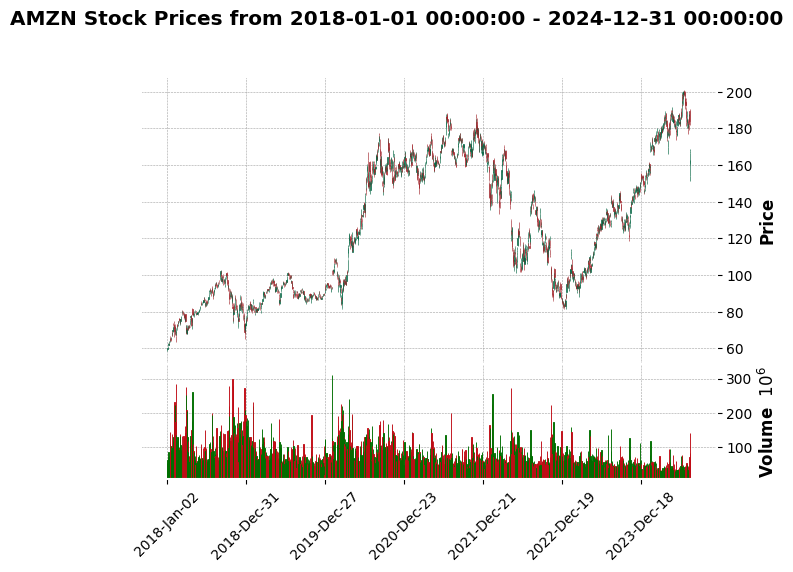

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime

# Ensure matplotlib inline plots in Jupyter Notebooks
%matplotlib inline

# Sample data - replace this with your actual data loading code
# Example data loading for demonstration purposes
# start_date = '2023-01-01'
# end_date = '2024-12-31'
start_date = start
end_date = end
ticker = 'AMZN'
data = yf.Ticker(ticker)
df = data.history(start=start_date, end=end_date)

# Reset index to have Date as a column
df.reset_index(inplace=True)

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Prepare the data for mplfinance
mpf_data = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Plot candlestick chart
mpf.plot(mpf_data, type='candle', style='charles', title=f'{ticker} Stock Prices from {start_date} - {end_date}', ylabel='Price', volume=True)


5. Technical Indicators and Strategies
A technical indicator is a series of data points that are derived by applying a formula to the price data of a security. Basically, they are price-derived indicators that use formulas to translate the momentum or price levels into quantifiable time series.

There are two categories of indicator: leading and lagging, and four types: trend, momentum, volatility and volume, which serve three broad functions: to alert, to confirm and to predict

5.1 Trend-following strategies
Trend-following is about profiting from the prevailing trend through buying an asset when its price trend goes up, and selling when its trend goes down, expecting price movements to continue.

5.1.1 Moving averages
Moving averages smooth a series filtering out noise to help identify trends, one of the fundamental principles of technical analysis being that prices move in trends. Types of moving averages include simple, exponential, smoothed, linear-weighted, MACD, and as lagging indicators they follow the price action and are commonly referred to as trend-following indicators.

5.1.2 Simple Moving Average (SMA)
The simplest form of a moving average, known as a Simple Moving Average (SMA), is calculated by taking the arithmetic mean of a given set of values over a set time period. This model is probably the most naive approach to time series modelling and simply states that the next observation is the mean of all past observations and each value in the time period carries equal weight.

Modelling this an as average calculation problem we would try to predict the future stock market prices (for example, xt+1 ) as an average of the previously observed stock market prices within a fixed size window (for example, xt-n, ..., xt). This helps smooth out the price data by creating a constantly updated average price so that the impacts of random, short-term fluctuations on the price of a stock over a specified time-frame are mitigated.

[*********************100%%**********************]  1 of 1 completed

Columns in DataFrame: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Ticker'],
      dtype='object')


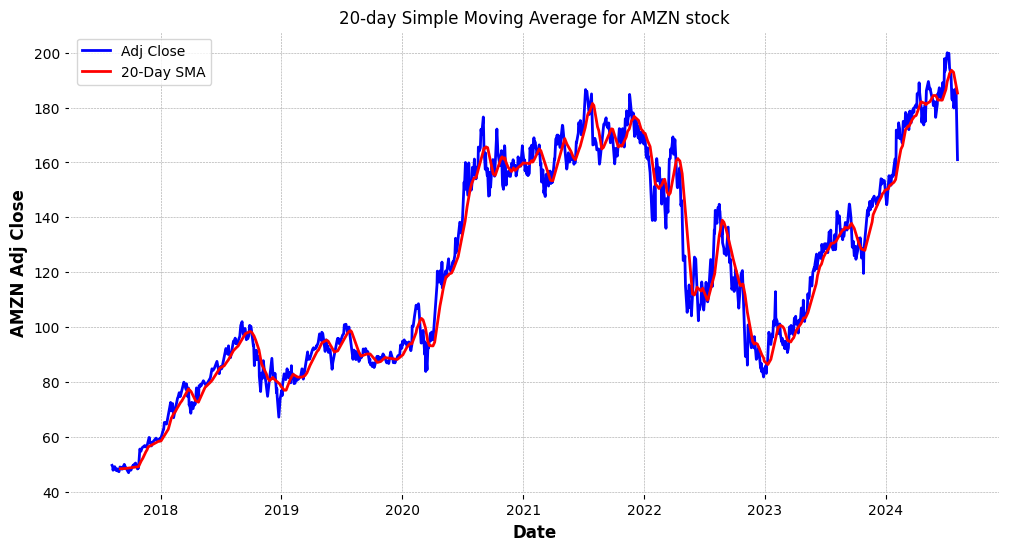

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Set ticker and title
ticker = 'AMZN'
title_txt = "20-day Simple Moving Average for NVDA stock"
label_txt = "NVDA Adj Close"

# Load/Read Data
yf.pdr_override()

# Define company tickers
tech_listx = ['AMZN']
tech_list = ['NVDA']
# Download stock data for the past 7 years
end = datetime.now()
start = datetime(end.year - 7, end.month, end.day)

# Initialize empty DataFrame
df = pd.DataFrame()

# Download and concatenate stock data
for stock in tech_listx:
    temp_df = yf.download(stock, start=start, end=end)
    temp_df['Ticker'] = stock
    df = pd.concat([df, temp_df])

# Reset index to make 'Date' a column
df.reset_index(inplace=True)

# Print the column names to verify
print("Columns in DataFrame:", df.columns)

# If 'Adj Close' exists, calculate the 20-day SMA
if 'Adj Close' in df.columns:
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()

    # Plot the adjusted close and the SMA
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='blue')
    plt.plot(df['Date'], df['SMA_20'], label='20-Day SMA', color='red')
    plt.title(title_txt)
    plt.xlabel('Date')
    plt.ylabel(label_txt)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Column 'Adj Close' not found in DataFrame.")

The SMA follows the time series removing noise from the signal and keeping the relevant information about the trend. If the stock price is above its moving average it is assumed that it will likely continue rising in an uptrend.

5.1.3 Moving Average Crossover Strategy
The most popular moving average crossover strategy, and the "Hello World!" of quantitative trading, being the easiest to construct, is based on the simple moving average. When moving averages cross, it is usually confirmation of a change in the prevailing trend, and we want to test whether over the long term the lag caused by the moving average can still give us profitable trades.

Depending on the type of investor or trader (high risk vs. low risk, short-term vs. long-term trading), you can adjust your moving ‘time’ average (10 days, 20 days, 50 days, 200 days, 1 year, 5 years, etc). The longer the period of an SMA, the longer the time horizon of the trend it spots. The most commonly used SMA periods are 20 for short-term (swing) trading, 50 for medium-term (position) trading and 200 for long-term (portfolio) trading.

There is no single right answer and this will vary according to whether a trader is planning to buy when the trend is going down and sell when it's going up, potentially making short-term gains, or to hold for a more long-term investment.

[*********************100%%**********************]  1 of 1 completed


Columns in DataFrame: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Ticker'],
      dtype='object')


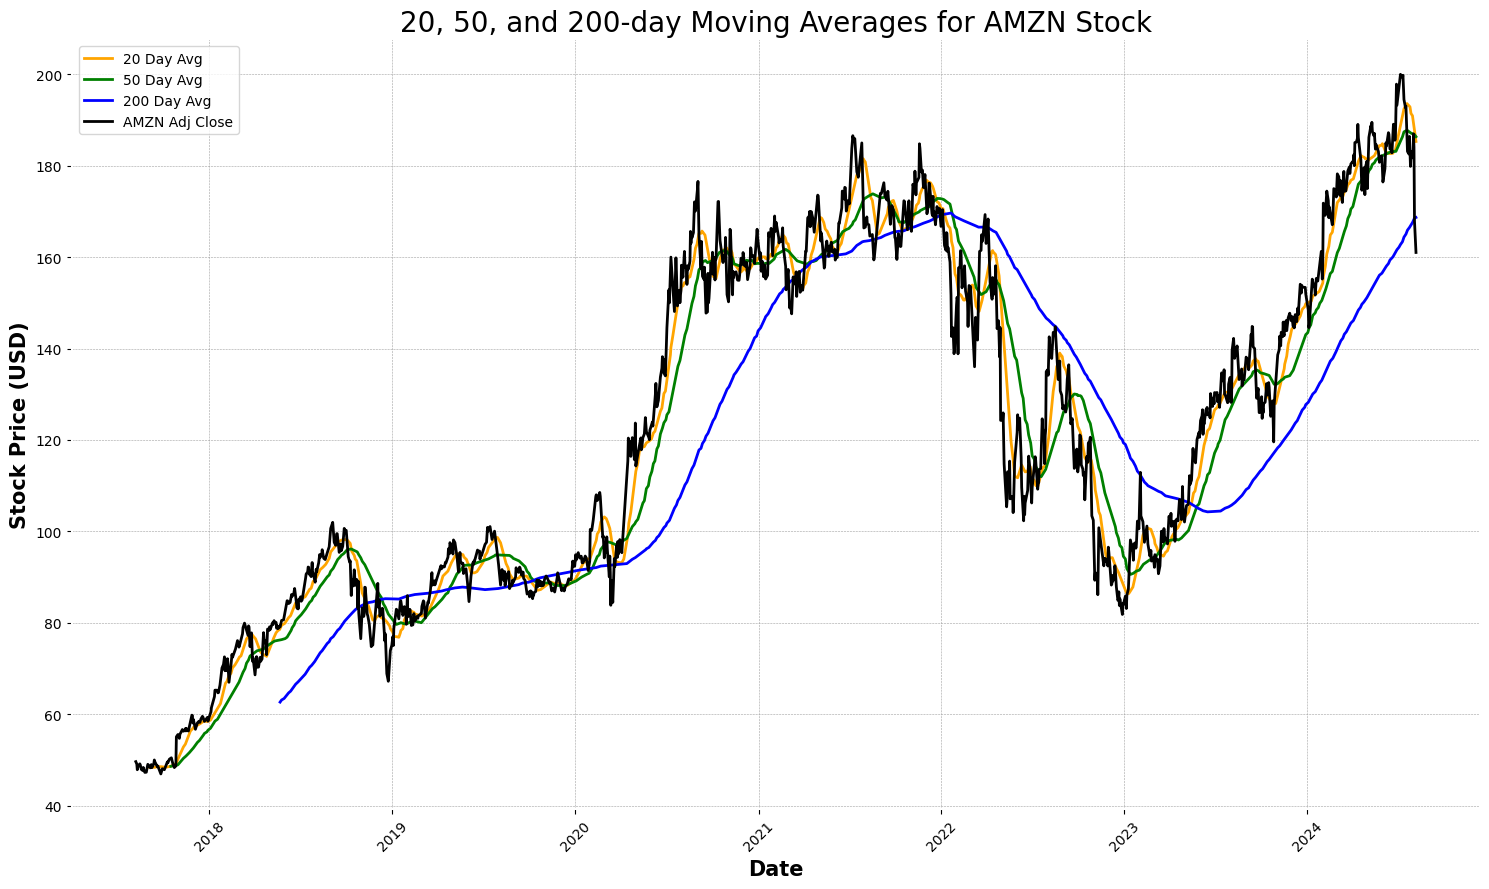

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Set ticker and title
ticker = 'AMZN'
title_txt = "20, 50, and 200-day Moving Averages for NVDA Stock"
label_txt = "NVDA Adj Close"

# Load/Read Data
yf.pdr_override()

# Define company tickers
# tech_list = [ticker]
tech_listx = ['AMZN']
tech_list = ['NVDA']
# Download stock data for the past 7 years
end = datetime.now()
start = datetime(end.year - 7, end.month, end.day)

# Initialize empty DataFrame
df = pd.DataFrame()

# Download and concatenate stock data
for stock in tech_listx:
    temp_df = yf.download(stock, start=start, end=end)
    temp_df['Ticker'] = stock
    df = pd.concat([df, temp_df])

# Reset index to make 'Date' a column
df.reset_index(inplace=True)

# Print the column names to verify
print("Columns in DataFrame:", df.columns)

def sma2():
    plt.figure(figsize=(15,9))
    # Calculate moving averages
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Adj Close'].rolling(window=200).mean()
    
    # Plot moving averages
    plt.plot(df['Date'], df['SMA_20'], label='20 Day Avg', color='orange')
    plt.plot(df['Date'], df['SMA_50'], label='50 Day Avg', color='green')
    plt.plot(df['Date'], df['SMA_200'], label='200 Day Avg', color='blue')
    plt.plot(df['Date'], df['Adj Close'], label=label_txt, color='black')
    
    plt.title(title_txt, color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Stock Price (USD)', color='black', fontsize=15)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

sma2()

The chart shows that the 20-day moving average is the most sensitive to local changes, and the 200-day moving average the least. Here, the 200-day moving average indicates an overall bullish trend - the stock is trending upward over time. The 20- and 50-day moving averages are at times bearish and at other times bullish.

The major drawback of moving averages, however, is that because they are lagging, and smooth out prices, they tend to recognise reversals too late and are therefore not very helpful when used alone.

Trading Strategy
The moving average crossover trading strategy will be to take two moving averages - 20-day (fast) and 200-day (slow) - and to go long (buy) when the fast MA goes above the slow MA and to go short (sell) when the fast MA goes below the slow MA.

In [ ]:
# Create copy of dataframe for amzn data for 2018 - 2024

amzn_sma = temp_df.copy()
     

amzn_sma

Open        High         Low       Close   Adj Close   
Date                                                                     
2017-08-07   49.532501   49.750000   49.356998   49.613499   49.613499  \
2017-08-08   49.717499   49.813999   49.289501   49.492001   49.492001   
2017-08-09   49.130001   49.400002   48.763500   49.100498   49.100498   
2017-08-10   48.814999   48.993000   47.734001   47.846001   47.846001   
2017-08-11   48.000000   48.519501   47.569000   48.399502   48.399502   
...                ...         ...         ...         ...         ...   
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007   
2024-07-31  185.050003  187.940002  184.460007  186.979996  186.979996   
2024-08-01  189.289993  190.600006  181.869995  184.070007  184.070007   
2024-08-02  166.750000  168.770004  160.550003  167.899994  167.899994   
2024-08-05  154.210007  162.960007  151.610001  161.020004  161.020004   

               Volume Ticker  
Date                          
2017-08-07   53532000   AMZN  
2017-08-08   58056000   AMZN  
2017-08-09   71394000   AMZN  
2017-08-10  113682000   AMZN  
2017-08-11   69360000   AMZN  
...               ...    ...  
2024-07-30   39508600   AMZN  
2024-07-31   41667300   AMZN  
2024-08-01   70435600   AMZN  
2024-08-02  141448400   AMZN  
2024-08-05   82961700   AMZN  

[1760 rows x 7 columns]

In [ ]:
  # Calculate and add columns for moving averages of Adjusted Close price data
  
  amzn_sma["20d"] = np.round(amzn_sma["Adj Close"].rolling(window = 20, center = False).mean(), 2)
  amzn_sma["50d"] = np.round(amzn_sma["Adj Close"].rolling(window = 50, center = False).mean(), 2)
  amzn_sma["200d"] = np.round(amzn_sma["Adj Close"].rolling(window = 200, center = False).mean(), 2)
  
  amzn_sma.tail()

Open        High         Low       Close   Adj Close   
Date                                                                     
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007  \
2024-07-31  185.050003  187.940002  184.460007  186.979996  186.979996   
2024-08-01  189.289993  190.600006  181.869995  184.070007  184.070007   
2024-08-02  166.750000  168.770004  160.550003  167.899994  167.899994   
2024-08-05  154.210007  162.960007  151.610001  161.020004  161.020004   

               Volume Ticker     20d     50d    200d  
Date                                                  
2024-07-30   39508600   AMZN  190.16  187.04  167.81  
2024-07-31   41667300   AMZN  189.51  187.09  168.09  
2024-08-01   70435600   AMZN  188.83  187.10  168.36  
2024-08-02  141448400   AMZN  187.23  186.80  168.53  
2024-08-05   82961700   AMZN  185.31  186.35  168.68

[*********************100%%**********************]  1 of 1 completed
c:\Users\Admin\Documents\MLAI\venv\venv\tensorflow_cpu\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


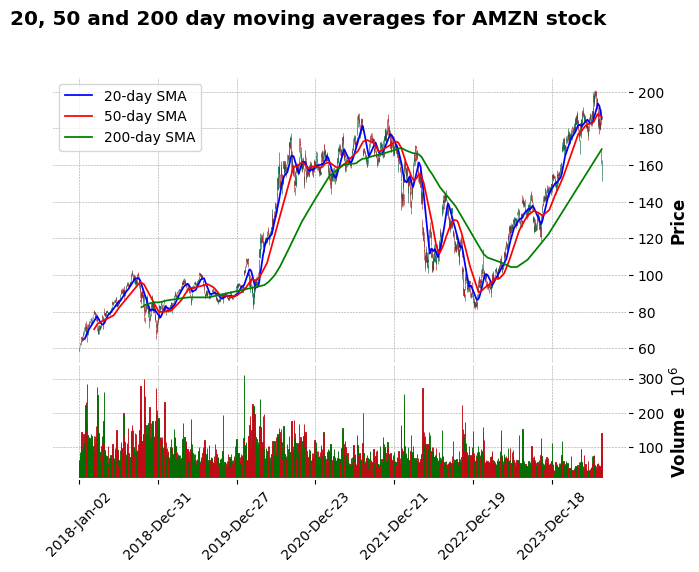

In [ ]:

import mplfinance as mpf
import yfinance as yf
# Load AMZN stock data
amzn = yf.download("AMZN", start="2018-01-01", end="2024-12-31")

# Calculate moving averages
amzn['20d'] = amzn['Adj Close'].rolling(window=20).mean()
amzn['50d'] = amzn['Adj Close'].rolling(window=50).mean()
amzn['200d'] = amzn['Adj Close'].rolling(window=200).mean()

# Define the moving averages to plot
ap0 = [
    mpf.make_addplot(amzn['20d'], color='blue', label='20-day SMA'),
    mpf.make_addplot(amzn['50d'], color='red', label='50-day SMA'),
    mpf.make_addplot(amzn['200d'], color='green', label='200-day SMA')
]

# Plot the candlestick chart with moving averages
mpf.plot(
    amzn.loc['2018-01-01':'2024-12-31'],
    type='candle',
    style='charles',
    title='20, 50 and 200 day moving averages for AMZN stock',
    ylabel='Price',
    addplot=ap0,
    volume=True
)

plt.show()

Backtesting
Before using the strategy we will evaluate the quality of it first by backtesting, or looking at how profitable it is on historical data.

In [ ]:
# Identify when the 20-day average is below the 200-day average, and vice versa.

amzn_sma['20d-200d'] = amzn_sma['20d'] - amzn_sma['200d']
amzn_sma.tail()

Open        High         Low       Close   Adj Close   
Date                                                                     
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007  \
2024-07-31  185.050003  187.940002  184.460007  186.979996  186.979996   
2024-08-01  189.289993  190.600006  181.869995  184.070007  184.070007   
2024-08-02  166.750000  168.770004  160.550003  167.899994  167.899994   
2024-08-05  154.210007  162.960007  151.610001  161.020004  161.020004   

               Volume Ticker     20d     50d    200d  20d-200d  
Date                                                            
2024-07-30   39508600   AMZN  190.16  187.04  167.81     22.35  
2024-07-31   41667300   AMZN  189.51  187.09  168.09     21.42  
2024-08-01   70435600   AMZN  188.83  187.10  168.36     20.47  
2024-08-02  141448400   AMZN  187.23  186.80  168.53     18.70  
2024-08-05   82961700   AMZN  185.31  186.35  168.68     16.63

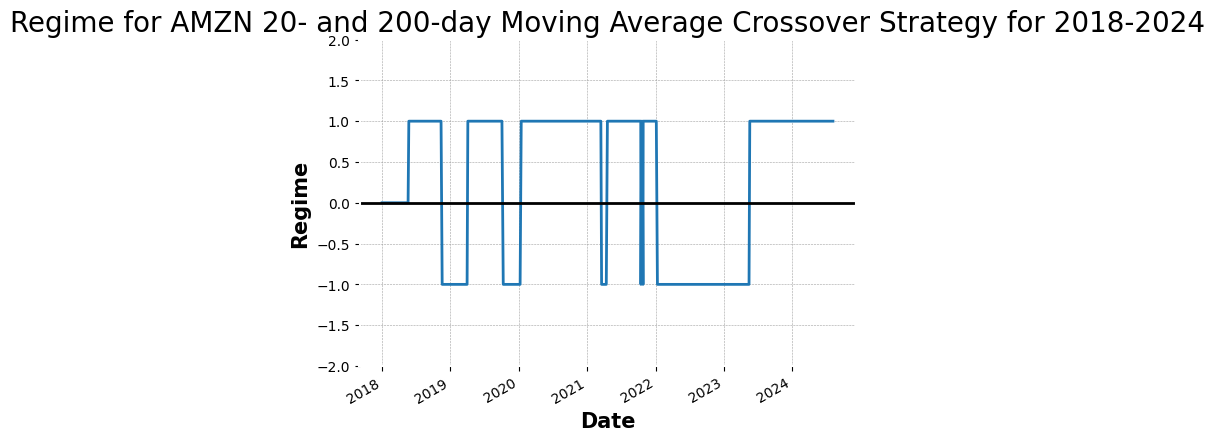

In [ ]:
# The sign of this difference is the regime; that is, if the fast moving average is above the slow moving average, 
# this is a bullish regime, and a bearish regime holds when the fast moving average is below the slow moving average

# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
amzn_sma["Regime"] = np.where(amzn_sma['20d-200d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Replace bearish regime's values with -1, and to maintain the rest of the vector, the second argument is amzn_sma["Regime"]
amzn_sma["Regime"] = np.where(amzn_sma['20d-200d'] < 0, -1, amzn_sma["Regime"])
amzn_sma.loc['2018-01-01':'2024-12-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2);
plt.title("Regime for AMZN 20- and 200-day Moving Average Crossover Strategy for 2018-2024", color = 'black', fontsize = 20)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Regime', color = 'black', fontsize = 15);

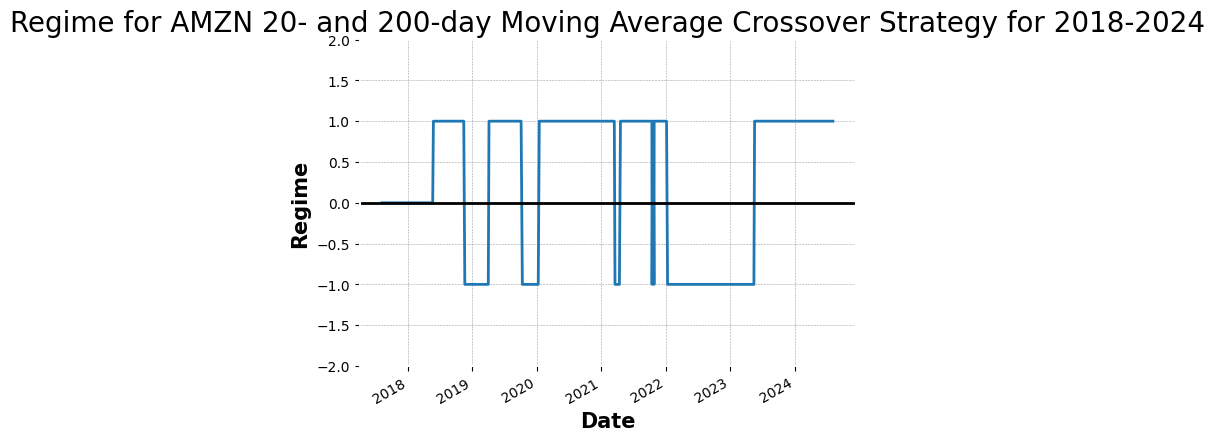

In [ ]:

amzn_sma["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2);
plt.title("Regime for AMZN 20- and 200-day Moving Average Crossover Strategy for 2018-2024", color = 'black', fontsize = 20)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Regime', color = 'black', fontsize = 15);

In [ ]:

# Number of bullish and bearish days

amzn_sma["Regime"].value_counts()

Regime
 1    1039
-1     522
 0     199
Name: count, dtype: int64

For 1039 days the market was bullish, for 522 days it was bearish, and neutral for 199 days for the time period 2018-2024.

In [ ]:
amzn_sma

Open        High         Low       Close   Adj Close   
Date                                                                     
2017-08-07   49.532501   49.750000   49.356998   49.613499   49.613499  \
2017-08-08   49.717499   49.813999   49.289501   49.492001   49.492001   
2017-08-09   49.130001   49.400002   48.763500   49.100498   49.100498   
2017-08-10   48.814999   48.993000   47.734001   47.846001   47.846001   
2017-08-11   48.000000   48.519501   47.569000   48.399502   48.399502   
...                ...         ...         ...         ...         ...   
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007   
2024-07-31  185.050003  187.940002  184.460007  186.979996  186.979996   
2024-08-01  189.289993  190.600006  181.869995  184.070007  184.070007   
2024-08-02  166.750000  168.770004  160.550003  167.899994  167.899994   
2024-08-05  154.210007  162.960007  151.610001  161.020004  161.020004   

               Volume Ticker     20d     50d    200d  20d-200d  Regime  
Date                                                                    
2017-08-07   53532000   AMZN     NaN     NaN     NaN       NaN       0  
2017-08-08   58056000   AMZN     NaN     NaN     NaN       NaN       0  
2017-08-09   71394000   AMZN     NaN     NaN     NaN       NaN       0  
2017-08-10  113682000   AMZN     NaN     NaN     NaN       NaN       0  
2017-08-11   69360000   AMZN     NaN     NaN     NaN       NaN       0  
...               ...    ...     ...     ...     ...       ...     ...  
2024-07-30   39508600   AMZN  190.16  187.04  167.81     22.35       1  
2024-07-31   41667300   AMZN  189.51  187.09  168.09     21.42       1  
2024-08-01   70435600   AMZN  188.83  187.10  168.36     20.47       1  
2024-08-02  141448400   AMZN  187.23  186.80  168.53     18.70       1  
2024-08-05   82961700   AMZN  185.31  186.35  168.68     16.63       1  

[1760 rows x 12 columns]

In [ ]:
# Obtain signals with -1 indicating “sell”, 1 indicating “buy”, and 0 no action
# To ensure that all trades close out, temporarily change the regime of the last row to 0
regime_orig = amzn_sma.iloc[-1, 10]
amzn_sma.iloc[-1, 10] = 0
amzn_sma["Signal"] = np.sign(amzn_sma["Regime"] - amzn_sma["Regime"].shift(1))
# Restore original regime data
amzn_sma.iloc[-1, 10] = regime_orig
amzn_sma.tail()

Open        High         Low       Close   Adj Close   
Date                                                                     
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007  \
2024-07-31  185.050003  187.940002  184.460007  186.979996  186.979996   
2024-08-01  189.289993  190.600006  181.869995  184.070007  184.070007   
2024-08-02  166.750000  168.770004  160.550003  167.899994  167.899994   
2024-08-05  154.210007  162.960007  151.610001  161.020004  161.020004   

               Volume Ticker     20d     50d    200d  20d-200d  Regime  Signal  
Date                                                                            
2024-07-30   39508600   AMZN  190.16  187.04  167.81     22.35       1     0.0  
2024-07-31   41667300   AMZN  189.51  187.09  168.09     21.42       1     0.0  
2024-08-01   70435600   AMZN  188.83  187.10  168.36     20.47       1     0.0  
2024-08-02  141448400   AMZN  187.23  186.80  168.53     18.70       1     0.0  
2024-08-05   82961700   AMZN  185.31  186.35  168.68     16.63       1     0.0

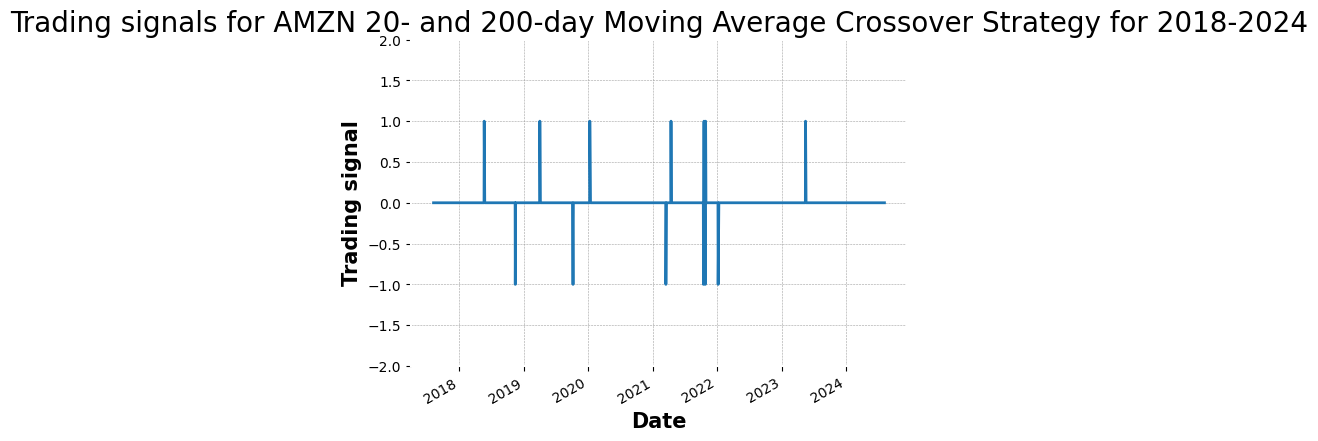

In [ ]:

amzn_sma["Signal"].plot(ylim = (-2, 2));
plt.title("Trading signals for AMZN 20- and 200-day Moving Average Crossover Strategy for 2018-2024", color = 'black', fontsize = 20)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Trading signal', color = 'black', fontsize = 15);

In [ ]:
# Unique counts of trading signals

amzn_sma["Signal"].value_counts()

Signal
 0.0    1746
 1.0       7
-1.0       6
Name: count, dtype: int64

We would buy amzn stock 7 times and sell 6 times. If we only go long 6 trades will be engaged in over the 6-year period, while if we pivot from a long to a short position every time a long position is terminated, we would engage in 7 trades total. It is worth bearing in mind that trading more frequently isn’t necessarily good as trades are never free.

In [ ]:
# Identify what the price of the stock is at every buy.

amzn_sma.loc[amzn_sma["Signal"] == 1, "Close"]

Date
2018-05-22     79.070000
2019-07-26     97.152496
2019-07-29     95.622498
2019-08-30     88.814499
2022-03-24    163.649506
2023-01-26     99.220001
Name: Close, dtype: float64

In [ ]:
# Identify what the price of the stock is at every sell.

amzn_sma.loc[amzn_sma["Signal"] == -1, "Close"]

Date
2018-11-14     79.950500
2019-10-07     86.633003
2021-03-16    154.593002
2021-10-15    170.451004
2021-10-25    166.018494
2022-01-06    163.253998
Name: Close, dtype: float64

In [ ]:
# Create a dataframe with trades, including the price at the trade and the regime under which the trade is made.

amzn_signals = pd.concat([
        pd.DataFrame({"Price": amzn_sma.loc[amzn_sma["Signal"] == 1, "Adj Close"],
                     "Regime": amzn_sma.loc[amzn_sma["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": amzn_sma.loc[amzn_sma["Signal"] == -1, "Adj Close"],
                     "Regime": amzn_sma.loc[amzn_sma["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
amzn_signals.sort_index(inplace = True)
amzn_signals

Price  Regime Signal
Date                                 
2018-05-22   79.070000       1    Buy
2018-11-14   79.950500      -1   Sell
2019-04-02   90.698997       1    Buy
2019-10-07   86.633003      -1   Sell
2020-01-10   94.157997       1    Buy
2021-03-16  154.593002      -1   Sell
2021-04-14  166.649994       1    Buy
2021-10-15  170.451004      -1   Sell
2021-10-18  172.337006       1    Buy
2021-10-25  166.018494      -1   Sell
2021-10-27  169.624496       1    Buy
2022-01-06  163.253998      -1   Sell
2023-05-16  113.400002       1    Buy

In [ ]:
# Ensure previous_buy_signals aligns with buy_signals
buy_signals = amzn_signals[amzn_signals['Signal'] == 'Buy']
previous_buy_signals = buy_signals.shift(1)

# Create DataFrame for long trade profits
amzn_long_profits = pd.DataFrame({
    "Entry Price": buy_signals["Price"],
    "Previous Buy Price": previous_buy_signals["Price"].values,
    "Profit": buy_signals["Price"].values - previous_buy_signals["Price"].values,
    "End Date": buy_signals.index
}).dropna()  # Drop rows with NaN values in 'Profit'

# Print the amzn_long_profits DataFrame
print("Columns in amzn_long_profits:", amzn_long_profits.columns)
print(amzn_long_profits)

Columns in nvda_long_profits: Index(['Entry Price', 'Previous Buy Price', 'Profit', 'End Date'], dtype='object')
            Entry Price  Previous Buy Price     Profit   End Date
Date                                                             
2019-04-02    90.698997           79.070000  11.628998 2019-04-02
2020-01-10    94.157997           90.698997   3.459000 2020-01-10
2021-04-14   166.649994           94.157997  72.491997 2021-04-14
2021-10-18   172.337006          166.649994   5.687012 2021-10-18
2021-10-27   169.624496          172.337006  -2.712509 2021-10-27
2023-05-16   113.400002          169.624496 -56.224495 2023-05-16


5.1.4 Exponential Moving Average
In a Simple Moving Average, each value in the time period carries equal weight, and values outside of the time period are not included in the average. However, the Exponential Moving Average is a cumulative calculation where a different decreasing weight is assigned to each observation. Past values have a diminishing contribution to the average, while more recent values have a greater contribution. This method allows the moving average to be more responsive to changes in the data.

[*********************100%%**********************]  1 of 1 completed


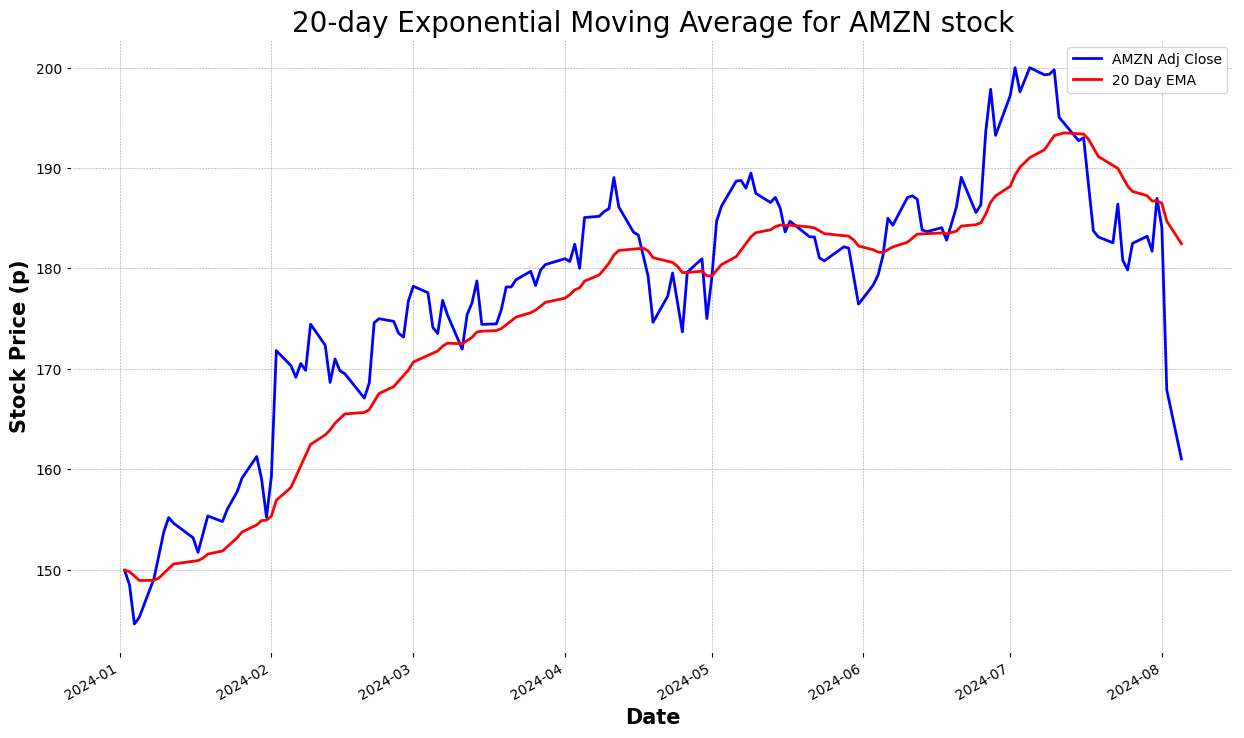

In [ ]:
# Set ticker and title
ticker = 'AMZN'
title_txt = "20-day Exponential Moving Average for AMZN stock"
label_txt = "AMZN Adj Close"

# Download amzn stock data for the year 2024
end = datetime(2024, 12, 31)
start = datetime(2024, 1, 1)

# Download stock data for the specified ticker
df = yf.download(ticker, start=start, end=end)

# Define ewma function
def ewma():
    plt.figure(figsize=(15, 9))
    # Calculate and plot 20-day EMA
    df['20_Day_EMA'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
    df['Adj Close'].plot(label=label_txt, color='blue')
    df['20_Day_EMA'].plot(label='20 Day EMA', color='red')
    
    plt.title(title_txt, color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Stock Price (p)', color='black', fontsize=15)
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot
ewma()

[*********************100%%**********************]  1 of 1 completed


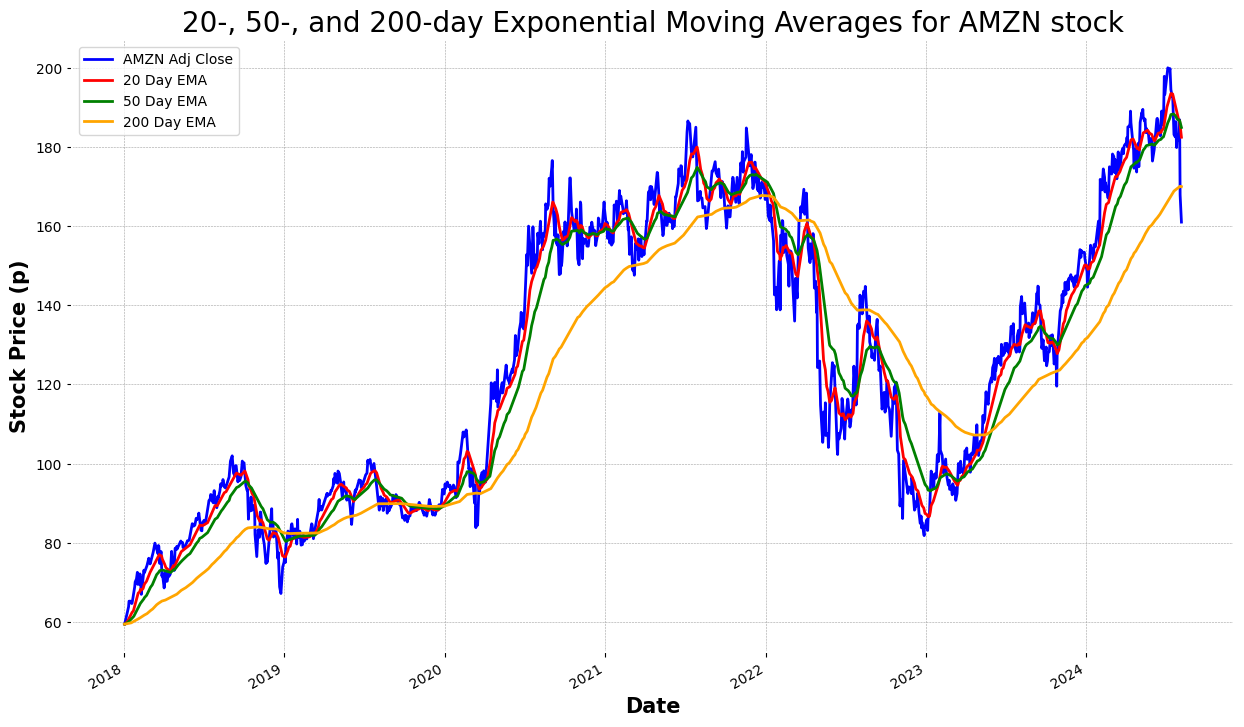

In [ ]:
# Set ticker and title
ticker = 'AMZN'
title_txt = "20-, 50-, and 200-day Exponential Moving Averages for AMZN stock"
label_txt = "AMZN Adj Close"

# Download amzn stock data for the period 2016-2019
start = datetime(2018, 1, 1)
end = datetime(2024, 12, 31)

# Download stock data for the specified ticker
df = yf.download(ticker, start=start, end=end)

# Define ewma2 function
def ewma2():
    plt.figure(figsize=(15, 9))
    # Calculate and plot 20-day EMA
    df['20_Day_EMA'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
    df['50_Day_EMA'] = df['Adj Close'].ewm(span=50, adjust=False).mean()
    df['200_Day_EMA'] = df['Adj Close'].ewm(span=200, adjust=False).mean()
    
    # Plot adjusted close and EMAs
    df['Adj Close'].plot(label=label_txt, color='blue')
    df['20_Day_EMA'].plot(label='20 Day EMA', color='red')
    df['50_Day_EMA'].plot(label='50 Day EMA', color='green')
    df['200_Day_EMA'].plot(label='200 Day EMA', color='orange')
    
    plt.title(title_txt, color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Stock Price (p)', color='black', fontsize=15)
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot
ewma2()

5.1.5 Triple Moving Average Crossover Strategy
This strategy uses three moving moving averages - short/fast, middle/medium and long/slow - and has two buy and sell signals.

The first is to buy when the middle/medium moving average crosses above the long/slow moving average and the short/fast moving average crosses above the middle/medium moving average. If we use this buy signal the strategy is to sell if the short/fast moving average crosses below the middle/medium moving average.

The second is to buy when the middle/medium moving average crosses below the long/slow moving average and the short/fast moving average crosses below the middle/medium moving average. If we use this buy signal the strategy is to sell if the short/fast moving average crosses above the middle/medium moving average.

In [ ]:
amzn_sma[['Adj Close']]['2024-05-01':'2024-10-31']

Adj Close
Date                  
2024-05-01  179.000000
2024-05-02  184.720001
2024-05-03  186.210007
2024-05-06  188.699997
2024-05-07  188.759995
...                ...
2024-07-30  181.710007
2024-07-31  186.979996
2024-08-01  184.070007
2024-08-02  167.899994
2024-08-05  161.020004

[66 rows x 1 columns]

In [ ]:
# Identify what the price of the stock is at every sell.

amzn_sma.loc[amzn_sma["Signal"] == -1, "Close"]

Date
2018-11-14     79.950500
2019-10-07     86.633003
2021-03-16    154.593002
2021-10-15    170.451004
2021-10-25    166.018494
2022-01-06    163.253998
Name: Close, dtype: float64

In [ ]:
# Create a dataframe with trades, including the price at the trade and the regime under which the trade is made.

amzn_signals = pd.concat([
        pd.DataFrame({"Price": amzn_sma.loc[amzn_sma["Signal"] == 1, "Adj Close"],
                     "Regime": amzn_sma.loc[amzn_sma["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": amzn_sma.loc[amzn_sma["Signal"] == -1, "Adj Close"],
                     "Regime": amzn_sma.loc[amzn_sma["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
amzn_signals.sort_index(inplace = True)
amzn_signals

Price  Regime Signal
Date                                 
2018-05-22   79.070000       1    Buy
2018-11-14   79.950500      -1   Sell
2019-04-02   90.698997       1    Buy
2019-10-07   86.633003      -1   Sell
2020-01-10   94.157997       1    Buy
2021-03-16  154.593002      -1   Sell
2021-04-14  166.649994       1    Buy
2021-10-15  170.451004      -1   Sell
2021-10-18  172.337006       1    Buy
2021-10-25  166.018494      -1   Sell
2021-10-27  169.624496       1    Buy
2022-01-06  163.253998      -1   Sell
2023-05-16  113.400002       1    Buy

In [ ]:
import pandas as pd

# Example DataFrames
buy_signals = pd.DataFrame({
    "Price": [100, 105],
    "Date": ['2024-01-01', '2024-01-02']
})
previous_buy_signals = pd.DataFrame({
    "Price": [95, 100],
    "Date": ['2024-01-01', '2024-01-02']
})

# Set 'Date' column as index
buy_signals.set_index('Date', inplace=True)
previous_buy_signals.set_index('Date', inplace=True)

# Create DataFrame for long trade profits
amzn_long_profits = pd.DataFrame({
    "Price": buy_signals["Price"],
    "Previous Buy Price": previous_buy_signals["Price"].reindex(buy_signals.index).values,
    "Profit": buy_signals["Price"].values - previous_buy_signals["Price"].reindex(buy_signals.index).values,
    "End Date": buy_signals.index
}).dropna()  # Drop rows with NaN values in 'Profit'

# Print the amzn_long_profits DataFrame
print(amzn_long_profits)

            Price  Previous Buy Price  Profit    End Date
Date                                                     
2024-01-01    100                  95       5  2024-01-01
2024-01-02    105                 100       5  2024-01-02


5.1.5 Triple Moving Average Crossover Strategy
This strategy uses three moving moving averages - short/fast, middle/medium and long/slow - and has two buy and sell signals.

The first is to buy when the middle/medium moving average crosses above the long/slow moving average and the short/fast moving average crosses above the middle/medium moving average. If we use this buy signal the strategy is to sell if the short/fast moving average crosses below the middle/medium moving average.

The second is to buy when the middle/medium moving average crosses below the long/slow moving average and the short/fast moving average crosses below the middle/medium moving average. If we use this buy signal the strategy is to sell if the short/fast moving average crosses above the middle/medium moving average.

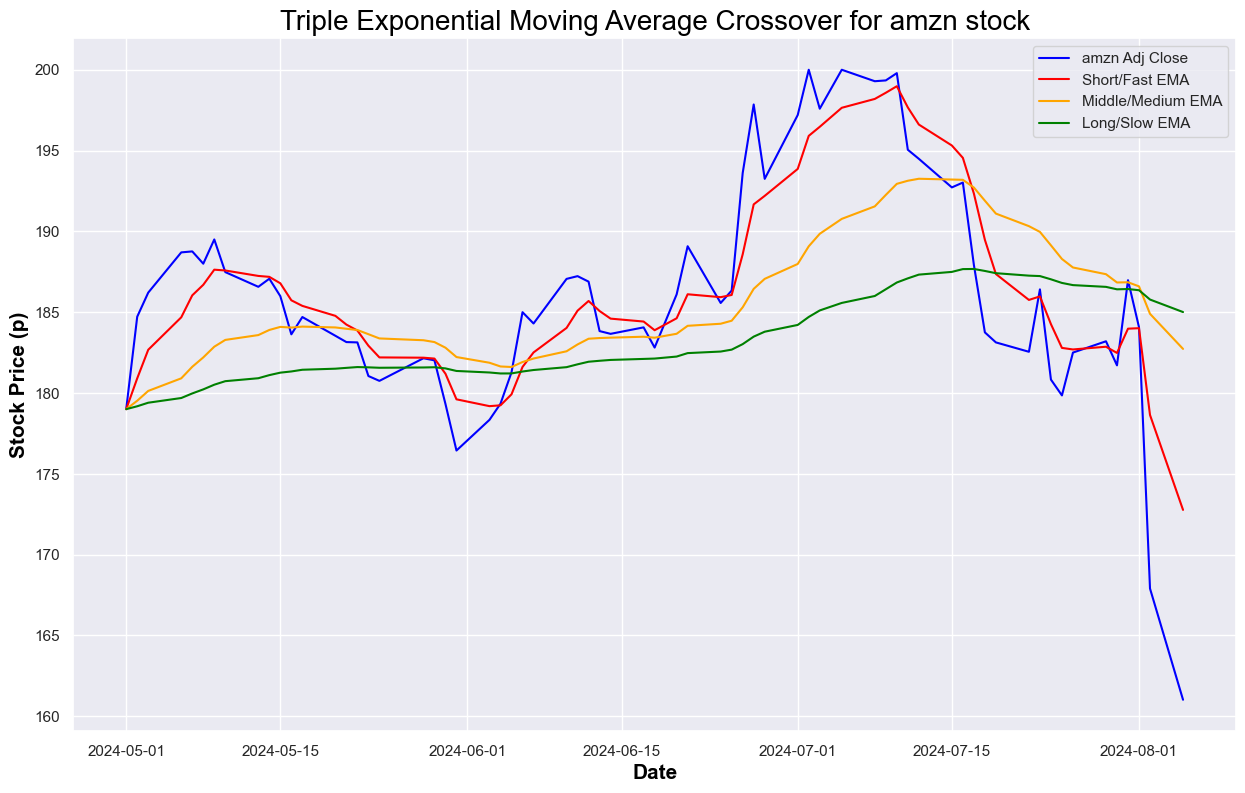

             Adj Close       Short      Middle        Long
Date                                                      
2024-05-01  179.000000  179.000000  179.000000  179.000000
2024-05-02  184.720001  180.906667  179.520000  179.178750
2024-05-03  186.210007  182.674447  180.128183  179.398477
2024-05-06  188.699997  184.682964  180.907438  179.689149
2024-05-07  188.759995  186.041974  181.621307  179.972613
...                ...         ...         ...         ...
2024-07-30  181.710007  182.478213  186.837814  186.414629
2024-07-31  186.979996  183.978807  186.850740  186.432296
2024-08-01  184.070007  184.009207  186.597946  186.358475
2024-08-02  167.899994  178.639469  184.898132  185.781647
2024-08-05  161.020004  172.766314  182.727393  185.007846

[66 rows x 4 columns]


In [ ]:
# Define the function for plotting EMAs
def ewma3():
    sns.set(rc={'figure.figsize':(15, 9)})
    
    # Extract data for the 6-month period
    amzn_adj_6mo1 = amzn_sma[['Adj Close']]['2024-05-01':'2024-10-31']
    
    # Calculate EMAs
    ShortEMA = amzn_adj_6mo1['Adj Close'].ewm(span=5, adjust=False).mean()
    MiddleEMA = amzn_adj_6mo1['Adj Close'].ewm(span=21, adjust=False).mean()
    LongEMA = amzn_adj_6mo1['Adj Close'].ewm(span=63, adjust=False).mean()
    
    # Add EMAs to the DataFrame
    amzn_adj_6mo1['Short'] = ShortEMA
    amzn_adj_6mo1['Middle'] = MiddleEMA
    amzn_adj_6mo1['Long'] = LongEMA
    
    # Plotting
    plt.plot(amzn_adj_6mo1['Adj Close'], label=f"{label_txt}", color='blue')
    plt.plot(ShortEMA, label='Short/Fast EMA', color='red')
    plt.plot(MiddleEMA, label='Middle/Medium EMA', color='orange')
    plt.plot(LongEMA, label='Long/Slow EMA', color='green')
    
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Stock Price (p)', color='black', fontsize=15)
    plt.legend()
    plt.show()

    return amzn_adj_6mo1

# Set ticker and title
ticker = 'amzn'
title_txt = "Triple Exponential Moving Average Crossover for amzn stock"
label_txt = "amzn Adj Close"

# Call the function to plot and get the DataFrame
amzn_adj_6mo1 = ewma3()

# Now amzn_adj_6mo1 contains the EMAs
print(amzn_adj_6mo1)

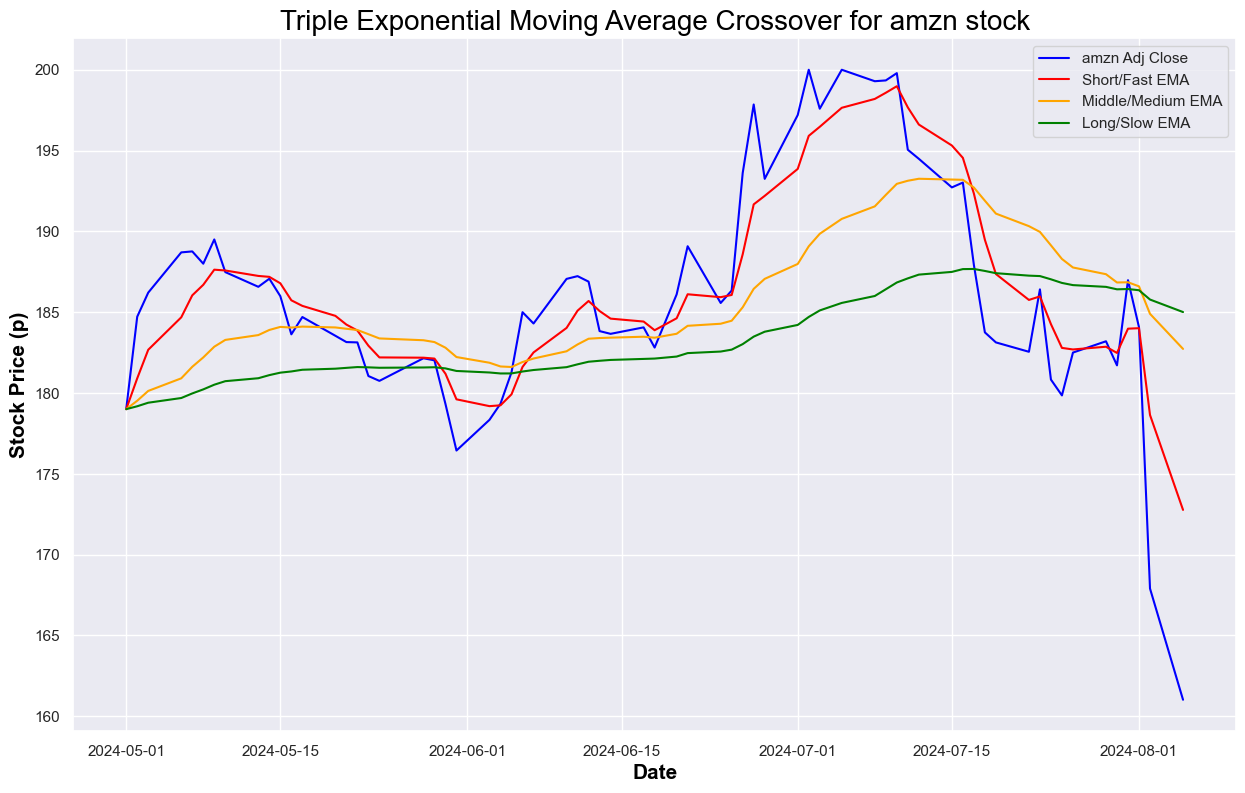

             Adj Close       Short      Middle        Long  Buy_Signal   
Date                                                                     
2024-05-01  179.000000  179.000000  179.000000  179.000000         NaN  \
2024-05-02  184.720001  180.906667  179.520000  179.178750  184.720001   
2024-05-03  186.210007  182.674447  180.128183  179.398477         NaN   
2024-05-06  188.699997  184.682964  180.907438  179.689149         NaN   
2024-05-07  188.759995  186.041974  181.621307  179.972613         NaN   
...                ...         ...         ...         ...         ...   
2024-07-30  181.710007  182.478213  186.837814  186.414629         NaN   
2024-07-31  186.979996  183.978807  186.850740  186.432296         NaN   
2024-08-01  184.070007  184.009207  186.597946  186.358475         NaN   
2024-08-02  167.899994  178.639469  184.898132  185.781647  167.899994   
2024-08-05  161.020004  172.766314  182.727393  185.007846         NaN   

            Sell_Signal  
Date       

In [ ]:
# Define the function for buy/sell signals based on EMAs
def buy_sell_ewma3(data):
    buy_list = []
    sell_list = []
    flag_long = False
    flag_short = False

    for i in range(0, len(data)):
        if data['Middle'][i] < data['Long'][i] and data['Short'][i] < data['Middle'][i] and flag_long == False and flag_short == False:
            buy_list.append(data['Adj Close'][i])
            sell_list.append(np.nan)
            flag_short = True
        elif flag_short == True and data['Short'][i] > data['Middle'][i]:
            sell_list.append(data['Adj Close'][i])
            buy_list.append(np.nan)
            flag_short = False
        elif data['Middle'][i] > data['Long'][i] and data['Short'][i] > data['Middle'][i] and flag_long == False and flag_short == False:
            buy_list.append(data['Adj Close'][i])
            sell_list.append(np.nan)
            flag_long = True
        elif flag_long == True and data['Short'][i] < data['Middle'][i]:
            sell_list.append(data['Adj Close'][i])
            buy_list.append(np.nan)
            flag_long = False
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)

    return buy_list, sell_list

# Calculate the EMAs and add them to the DataFrame
amzn_adj_6mo1 = ewma3()
amzn_adj_6mo1['Short'] = amzn_adj_6mo1['Adj Close'].ewm(span=5, adjust=False).mean()
amzn_adj_6mo1['Middle'] = amzn_adj_6mo1['Adj Close'].ewm(span=21, adjust=False).mean()
amzn_adj_6mo1['Long'] = amzn_adj_6mo1['Adj Close'].ewm(span=63, adjust=False).mean()

# Generate buy/sell signals
buy_signals, sell_signals = buy_sell_ewma3(amzn_adj_6mo1)

# Add buy/sell signals to the DataFrame
amzn_adj_6mo1['Buy_Signal'] = buy_signals
amzn_adj_6mo1['Sell_Signal'] = sell_signals

# Display the DataFrame with signals
print(amzn_adj_6mo1)

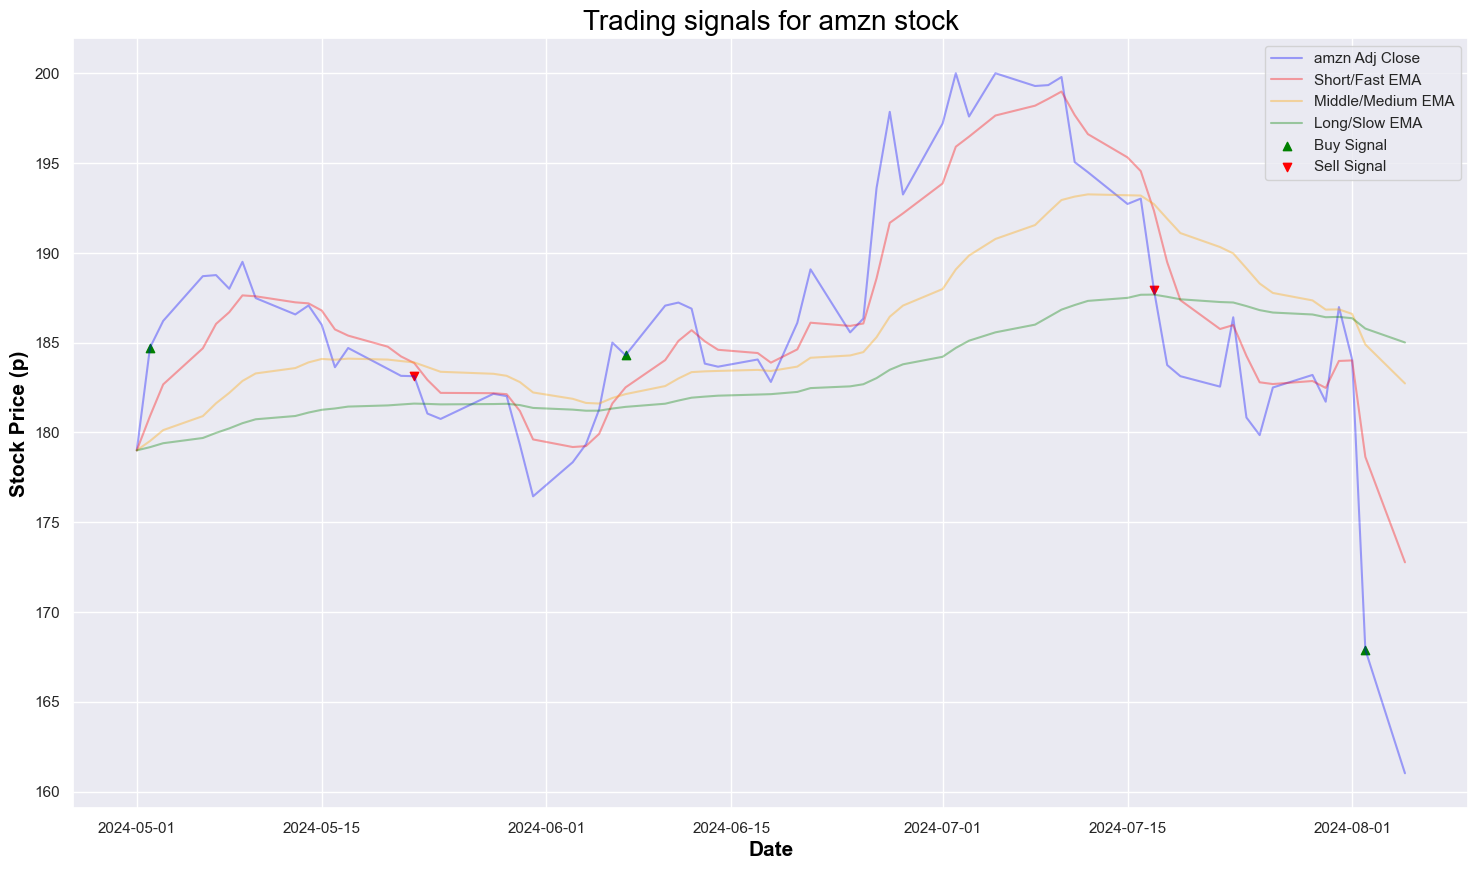

In [ ]:
# Define the function for buy/sell signals based on EMAs
def buy_sell_ewma3(data):
    buy_list = []
    sell_list = []
    flag_long = False
    flag_short = False

    for i in range(0, len(data)):
        if data['Middle'][i] < data['Long'][i] and data['Short'][i] < data['Middle'][i] and flag_long == False and flag_short == False:
            buy_list.append(data['Adj Close'][i])
            sell_list.append(np.nan)
            flag_short = True
        elif flag_short == True and data['Short'][i] > data['Middle'][i]:
            sell_list.append(data['Adj Close'][i])
            buy_list.append(np.nan)
            flag_short = False
        elif data['Middle'][i] > data['Long'][i] and data['Short'][i] > data['Middle'][i] and flag_long == False and flag_short == False:
            buy_list.append(data['Adj Close'][i])
            sell_list.append(np.nan)
            flag_long = True
        elif flag_long == True and data['Short'][i] < data['Middle'][i]:
            sell_list.append(data['Adj Close'][i])
            buy_list.append(np.nan)
            flag_long = False
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)

    return buy_list, sell_list

# Extract data for the 6-month period
amzn_adj_6mo = amzn_sma[['Adj Close']]['2024-05-01':'2024-10-31']

# Calculate EMAs
amzn_adj_6mo['Short'] = amzn_adj_6mo['Adj Close'].ewm(span=5, adjust=False).mean()
amzn_adj_6mo['Middle'] = amzn_adj_6mo['Adj Close'].ewm(span=21, adjust=False).mean()
amzn_adj_6mo['Long'] = amzn_adj_6mo['Adj Close'].ewm(span=63, adjust=False).mean()

# Generate buy/sell signals
amzn_adj_6mo['Buy'] = buy_sell_ewma3(amzn_adj_6mo)[0]
amzn_adj_6mo['Sell'] = buy_sell_ewma3(amzn_adj_6mo)[1]

# Define the function for plotting buy/sell signals and EMAs
def buy_sell_ewma3_plot():
    sns.set(rc={'figure.figsize':(18, 10)})
    plt.plot(amzn_adj_6mo['Adj Close'], label=f"{label_txt}", color='blue', alpha=0.35)
    plt.plot(amzn_adj_6mo['Short'], label='Short/Fast EMA', color='red', alpha=0.35)
    plt.plot(amzn_adj_6mo['Middle'], label='Middle/Medium EMA', color='orange', alpha=0.35)
    plt.plot(amzn_adj_6mo['Long'], label='Long/Slow EMA', color='green', alpha=0.35)
    plt.scatter(amzn_adj_6mo.index, amzn_adj_6mo['Buy'], color='green', label='Buy Signal', marker='^', alpha=1)
    plt.scatter(amzn_adj_6mo.index, amzn_adj_6mo['Sell'], color='red', label='Sell Signal', marker='v', alpha=1)
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Stock Price (p)', color='black', fontsize=15)
    plt.legend()
    plt.show()

# Set ticker and title
ticker = 'amzn'
title_txt = "Trading signals for amzn stock"
label_txt = "amzn Adj Close"

# Call the function to plot
buy_sell_ewma3_plot()

5.1.6 Exponential Smoothing
Single Exponential Smoothing, also known as Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality. It requires an alpha parameter, also called the smoothing factor or smoothing coefficient, to control the rate at which the influence of the observations at prior time steps decay exponentially.

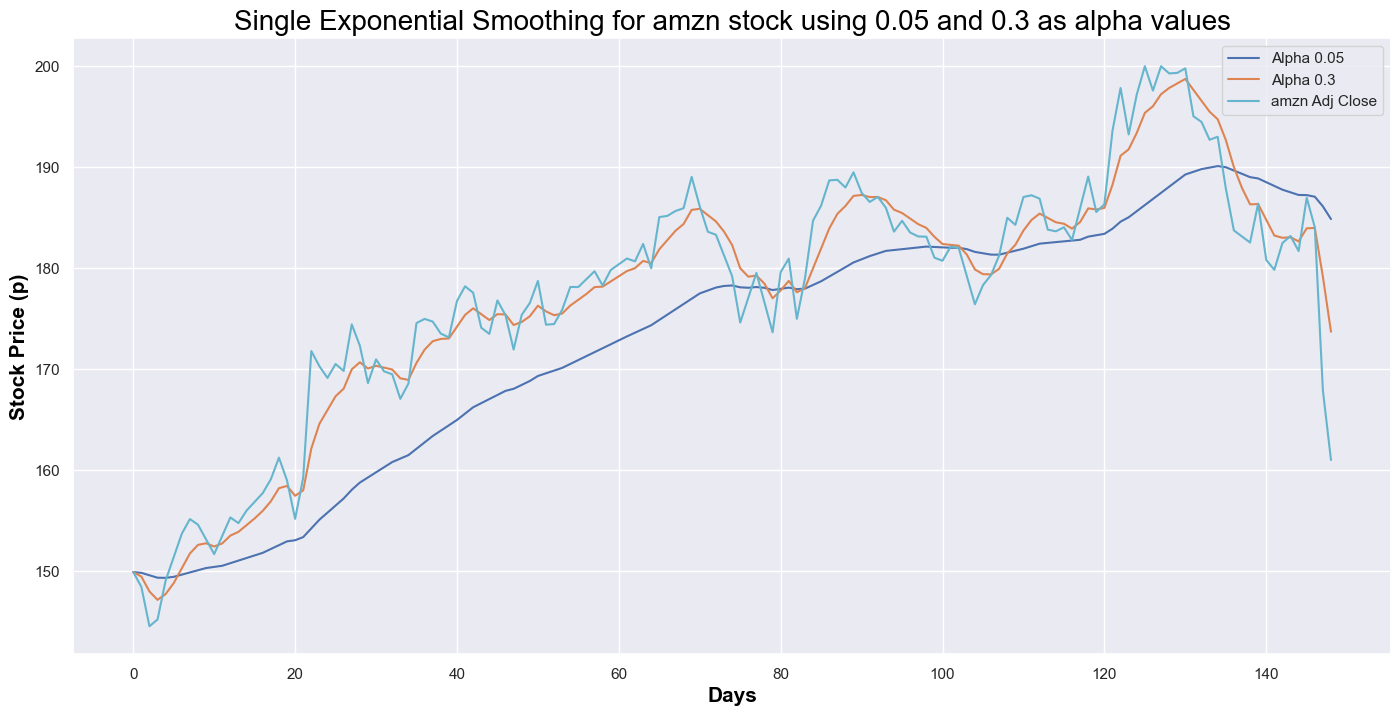

In [ ]:
# Exponential smoothing function
def exponential_smoothing(series, alpha):
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# Function to plot exponential smoothing
def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label=f"Alpha {alpha}")
    plt.plot(series.values, "c", label=f"{label_txt}")
    plt.xlabel('Days', color='black', fontsize=15)
    plt.ylabel('Stock Price (p)', color='black', fontsize=15)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.grid(True)
    plt.show()

# Set ticker and title for amzn
ticker = 'amzn'
title_txt = "Single Exponential Smoothing for amzn stock using 0.05 and 0.3 as alpha values"
label_txt = "amzn Adj Close"

# Assuming amzn_sma is your dataframe containing amzn stock data
plot_exponential_smoothing(amzn_sma['Adj Close'].loc['2024-01-01':'2024-12-31'], [0.05, 0.3])

The smaller the smoothing factor (coefficient), the smoother the time series will be. As the smoothing factor approaches 0, we approach the moving average model so the smoothing factor of 0.05 produces a smoother time series than 0.3. This indicates slow learning (past observations have a large influence on forecasts). A value close to 1 indicates fast learning (that is, only the most recent values influence the forecasts).

Double Exponential Smoothing (Holt’s Linear Trend Model) is an extension being a recursive use of Exponential Smoothing twice where beta is the trend smoothing factor, and takes values between 0 and 1. It explicitly adds support for trends.

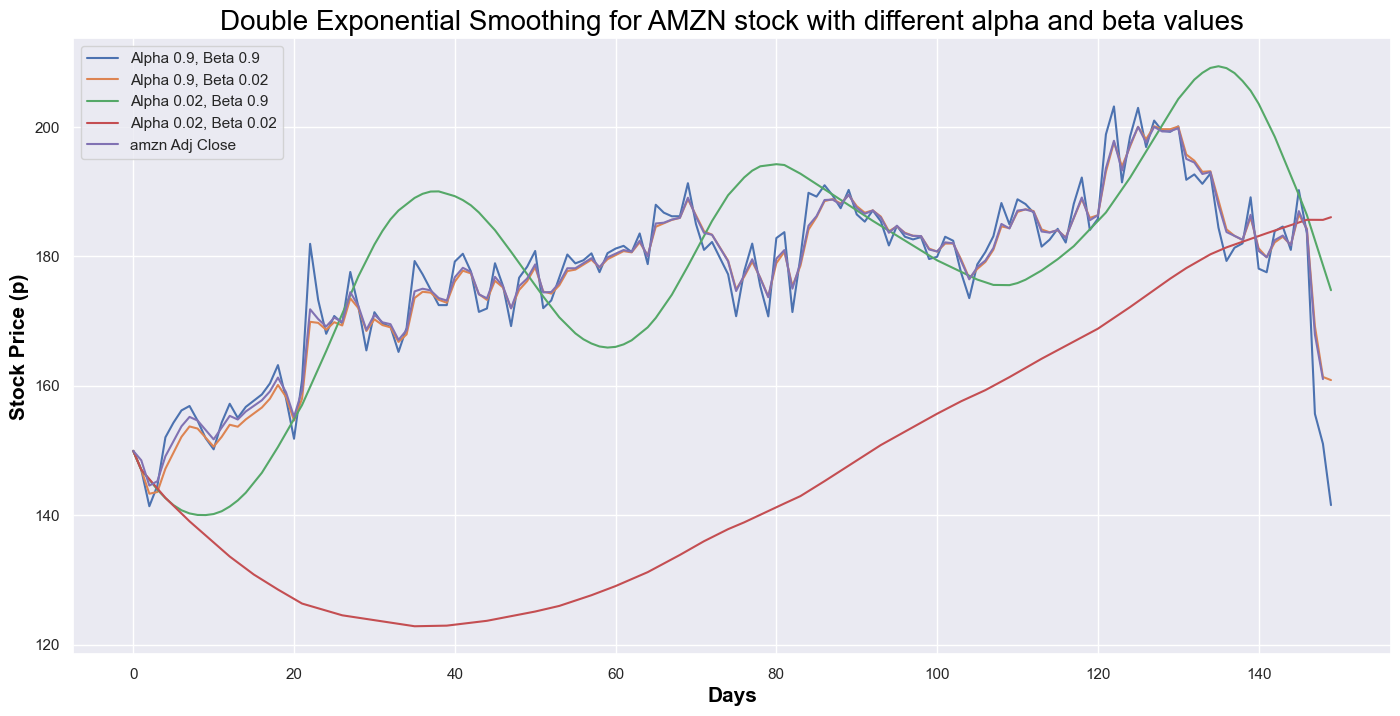

In [ ]:
# Double Exponential Smoothing function
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

# Function to plot Double Exponential Smoothing
def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label=f"Alpha {alpha}, Beta {beta}")
    plt.plot(series.values, label=f"{label_txt}")
    plt.xlabel('Days', color='black', fontsize=15)
    plt.ylabel('Stock Price (p)', color='black', fontsize=15)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.grid(True)
    plt.show()

# Set ticker and title for amzn
ticker = 'amzn'
title_txt = "Double Exponential Smoothing for AMZN stock with different alpha and beta values"
label_txt = "amzn Adj Close"

# Assuming amzn_sma is your dataframe containing amzn stock data
plot_double_exponential_smoothing(amzn_sma['Adj Close'].loc['2024-01-01':'2024-12-31'], alphas=[0.9, 0.02], betas=[0.9, 0.02])
 

The third main type is Triple Exponential Smoothing (Holt Winters Method) which is an extension of Exponential Smoothing that explicitly adds support for seasonality, or periodic fluctuations.

5.1.7 Moving average convergence divergence (MACD)
The MACD is a trend-following momentum indicator turning two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter one.

It is useful although lacking one prediction element - because it is unbounded it is not particularly useful for identifying overbought and oversold levels. Traders can look for signal line crossovers, neutral/centreline crossovers (otherwise known as the 50 level) and divergences from the price action to generate signals.

The default parameters are 26 EMA of prices, 12 EMA of prices and a 9-moving average of the difference between the first two.

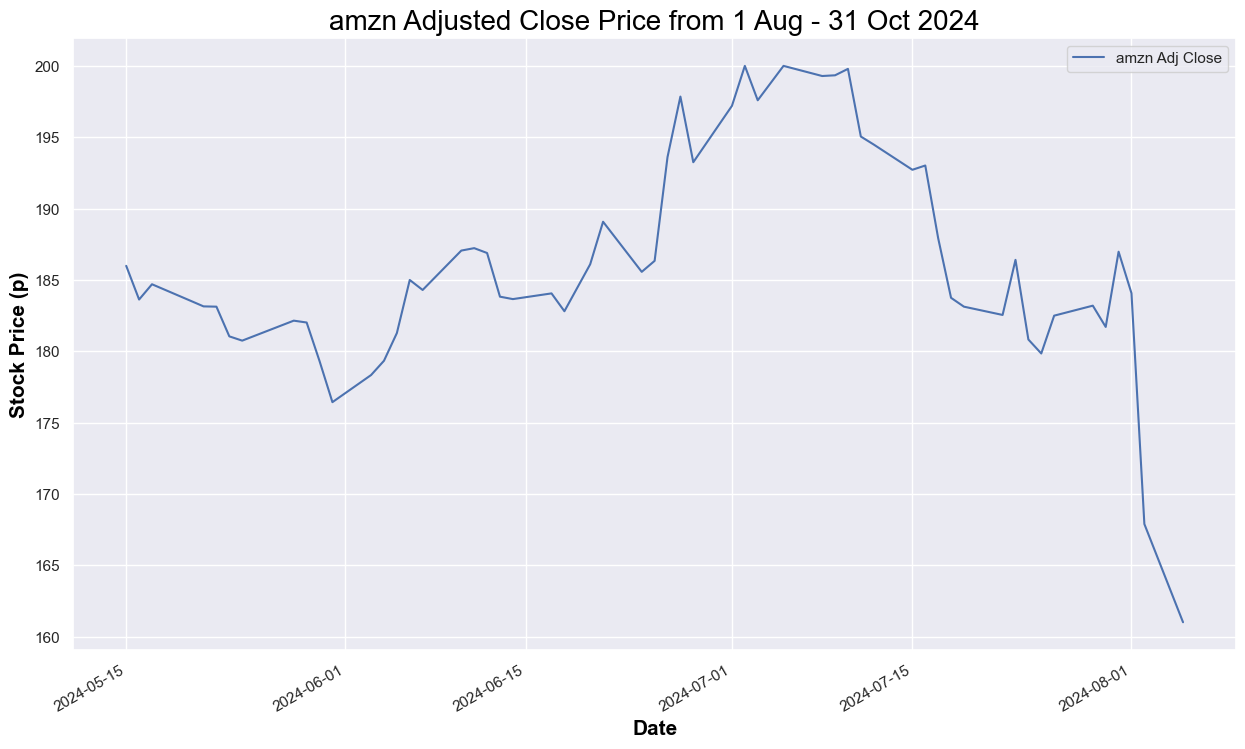

In [ ]:
# Function to plot the adjusted close price for a 3-month period
def adj_3mo():
    sns.set(rc={'figure.figsize': (15, 9)})
    amzn_sma['Adj Close'].loc['2024-05-15':'2024-08-15'].plot(label=f"{label_txt}")
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Stock Price (p)', color='black', fontsize=15)
    plt.legend()
    plt.show()

# Set title and label for amzn
title_txt = "amzn Adjusted Close Price from 1 Aug - 31 Oct 2024"
label_txt = "amzn Adj Close"

# Call the function to plot
adj_3mo()

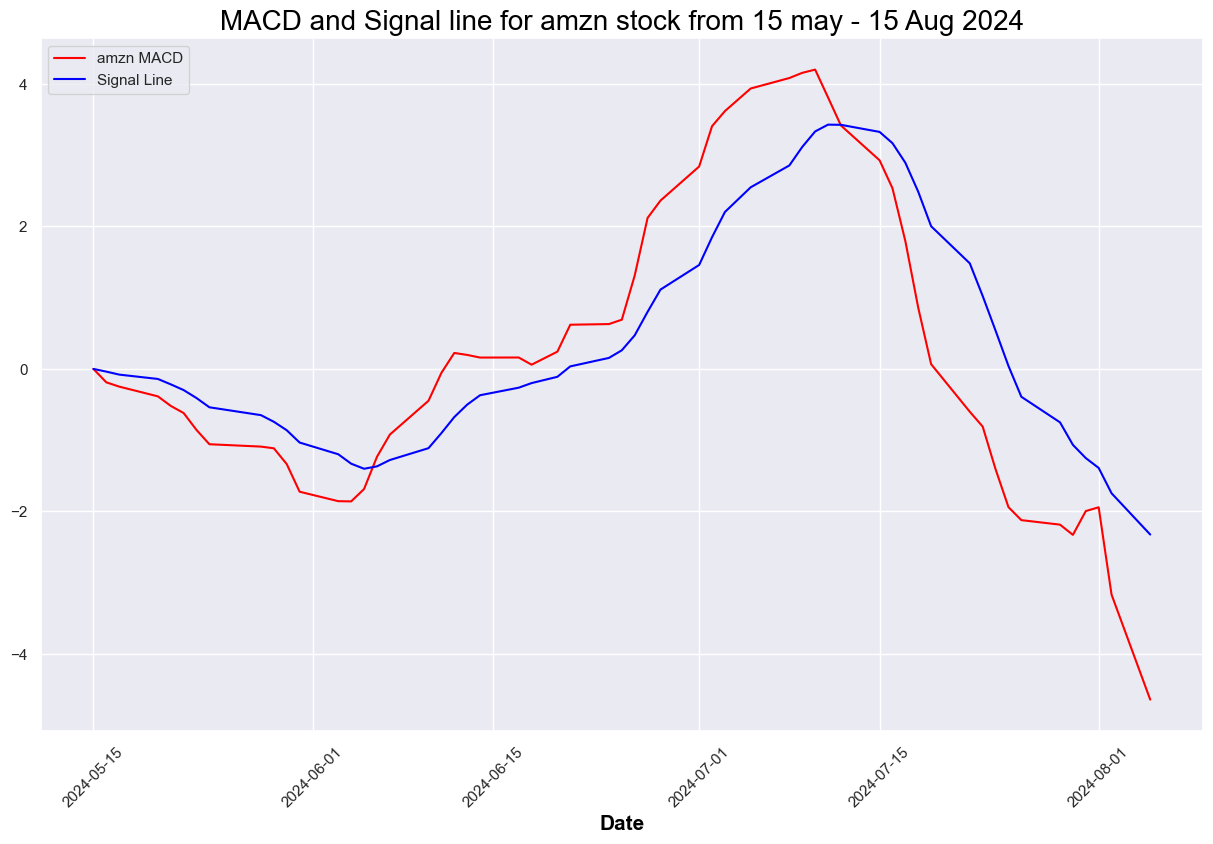

In [ ]:
# Extracting the data for the specified period
amzn_adj_3mo = amzn_sma[['Adj Close']]['2024-05-15':'2024-08-15']

# Calculate EMAs and MACD
ShortEMA = amzn_adj_3mo['Adj Close'].ewm(span=12, adjust=False).mean()
LongEMA = amzn_adj_3mo['Adj Close'].ewm(span=26, adjust=False).mean()
MACD = ShortEMA - LongEMA
signal = MACD.ewm(span=9, adjust=False).mean()

# Define the MACD plotting function
def macd():
    plt.figure(figsize=(15, 9))
    plt.plot(amzn_adj_3mo.index, MACD, label=macd_label_txt, color='red')
    plt.plot(amzn_adj_3mo.index, signal, label=sig_label_txt, color='blue')
    plt.title(title_txt, color='black', fontsize=20)
    plt.xticks(rotation=45)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.legend(loc='upper left')
    plt.show()

# Set title and labels
title_txt = 'MACD and Signal line for amzn stock from 15 may - 15 Aug 2024'
macd_label_txt = "amzn MACD"
sig_label_txt = "Signal Line"

# Call the function to plot
macd()

When the MACD line crosses above the signal line this indicates a good time to buy.

In [ ]:

# Create new columns for the MACD and Signal Line data

amzn_adj_3mo['MACD'] = MACD
amzn_adj_3mo['Signal Line'] = signal
amzn_adj_3mo

Adj Close      MACD  Signal Line
Date                                         
2024-05-15  185.990005  0.000000     0.000000
2024-05-16  183.630005 -0.188262    -0.037652
2024-05-17  184.699997 -0.248260    -0.079774
2024-05-20  183.539993 -0.384974    -0.140814
2024-05-21  183.149994 -0.518809    -0.216413
2024-05-22  183.130005 -0.619349    -0.297000
2024-05-23  181.050003 -0.856987    -0.408997
2024-05-24  180.750000 -1.057336    -0.538665
2024-05-28  182.149994 -1.090575    -0.649047
2024-05-29  182.020004 -1.114558    -0.742149
2024-05-30  179.320007 -1.336031    -0.860926
2024-05-31  176.440002 -1.724069    -1.033554
2024-06-03  178.339996 -1.856873    -1.198218
2024-06-04  179.339996 -1.859988    -1.330572
2024-06-05  181.279999 -1.686475    -1.401753
2024-06-06  185.000000 -1.234560    -1.368314
2024-06-07  184.300003 -0.922267    -1.279105
2024-06-10  187.059998 -0.446912    -1.112666
2024-06-11  187.229996 -0.055829    -0.901299
2024-06-12  186.889999  0.224089    -0.676221
2024-06-13  183.830002  0.196742    -0.501628
2024-06-14  183.660004  0.159513    -0.369400
2024-06-17  184.059998  0.160436    -0.263433
2024-06-18  182.809998  0.059615    -0.198823
2024-06-20  186.100006  0.242396    -0.110579
2024-06-21  189.080002  0.620559     0.035648
2024-06-24  185.570007  0.629769     0.154472
2024-06-25  186.339996  0.691231     0.261824
2024-06-26  193.610001  1.311451     0.471750
2024-06-27  197.850006  2.120668     0.801533
2024-06-28  193.250000  2.363550     1.113937
2024-07-01  197.199997  2.842007     1.459551
2024-07-02  200.000000  3.407841     1.849209
2024-07-03  197.589996  3.620071     2.203381
2024-07-05  200.000000  3.937345     2.550174
2024-07-08  199.289993  4.084413     2.857022
2024-07-09  199.339996  4.157079     3.117033
2024-07-10  199.789993  4.202535     3.334134
2024-07-11  195.050003  3.812138     3.429734
2024-07-12  194.490005  3.418155     3.427419
2024-07-15  192.720001  2.929329     3.327801
2024-07-16  193.020004  2.536895     3.169620
2024-07-17  187.929993  1.794482     2.894592
2024-07-18  183.750000  0.858922     2.487458
2024-07-19  183.130005  0.066686     2.003304
2024-07-22  182.550003 -0.601038     1.482435
2024-07-23  186.410004 -0.809415     1.024065
2024-07-24  180.830002 -1.408577     0.537537
2024-07-25  179.850006 -1.940131     0.042003
2024-07-26  182.500000 -2.123084    -0.391014
2024-07-29  183.199997 -2.186389    -0.750089
2024-07-30  181.710007 -2.329931    -1.066058
2024-07-31  186.979996 -1.995442    -1.251935
2024-08-01  184.070007 -1.942774    -1.390103
2024-08-02  167.899994 -3.169286    -1.745939
2024-08-05  161.020004 -4.642942    -2.325340

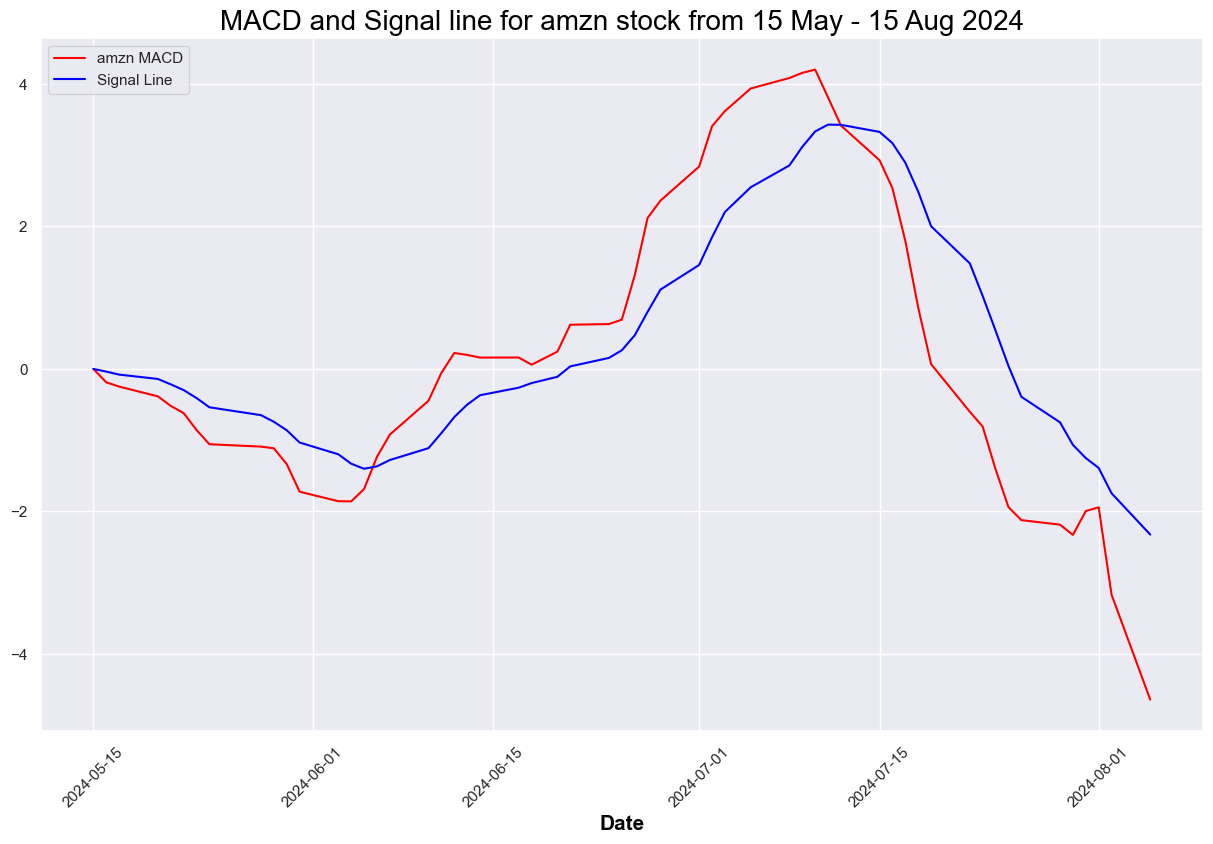

In [ ]:
# Extracting the data for the specified period for amzn
amzn_adj_3mo = amzn_sma[['Adj Close']]['2024-05-15':'2024-08-15']

# Calculate EMAs and MACD
ShortEMA = amzn_adj_3mo['Adj Close'].ewm(span=12, adjust=False).mean()
LongEMA = amzn_adj_3mo['Adj Close'].ewm(span=26, adjust=False).mean()
MACD = ShortEMA - LongEMA
signal = MACD.ewm(span=9, adjust=False).mean()

# Create a DataFrame with MACD and Signal Line
macd_signal_df = pd.DataFrame({
    'Adj Close': amzn_adj_3mo['Adj Close'],
    'MACD': MACD,
    'Signal Line': signal
})

# Function to signal when to buy and sell
def buy_sell_macd(df):
    Buy = []
    Sell = []
    flag = -1

    for i in range(len(df)):
        if df['MACD'][i] > df['Signal Line'][i]:
            Sell.append(np.nan)
            if flag != 1:
                Buy.append(df['Adj Close'][i])
                flag = 1
            else:
                Buy.append(np.nan)
        elif df['MACD'][i] < df['Signal Line'][i]:
            Buy.append(np.nan)
            if flag != 0:
                Sell.append(df['Adj Close'][i])
                flag = 0
            else:
                Sell.append(np.nan)
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)

    return (Buy, Sell)

# Create buy and sell columns
a = buy_sell_macd(macd_signal_df)
amzn_adj_3mo['Buy_Signal_Price'] = a[0]
amzn_adj_3mo['Sell_Signal_Price'] = a[1]

# Set labels and titles
ticker = 'amzn'
title_txt = 'MACD and Signal line for amzn stock from 15 May - 15 Aug 2024'
macd_label_txt = "amzn MACD"
sig_label_txt = "Signal Line"

# Function to plot MACD and Signal Line
def macd():
    plt.figure(figsize=(15, 9))
    plt.plot(amzn_adj_3mo.index, MACD, label=f"{macd_label_txt}", color='red')
    plt.plot(amzn_adj_3mo.index, signal, label=f"{sig_label_txt}", color='blue')
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xticks(rotation=45)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.legend(loc='upper left')
    plt.show()

# Call the functions to plot and signal
macd()

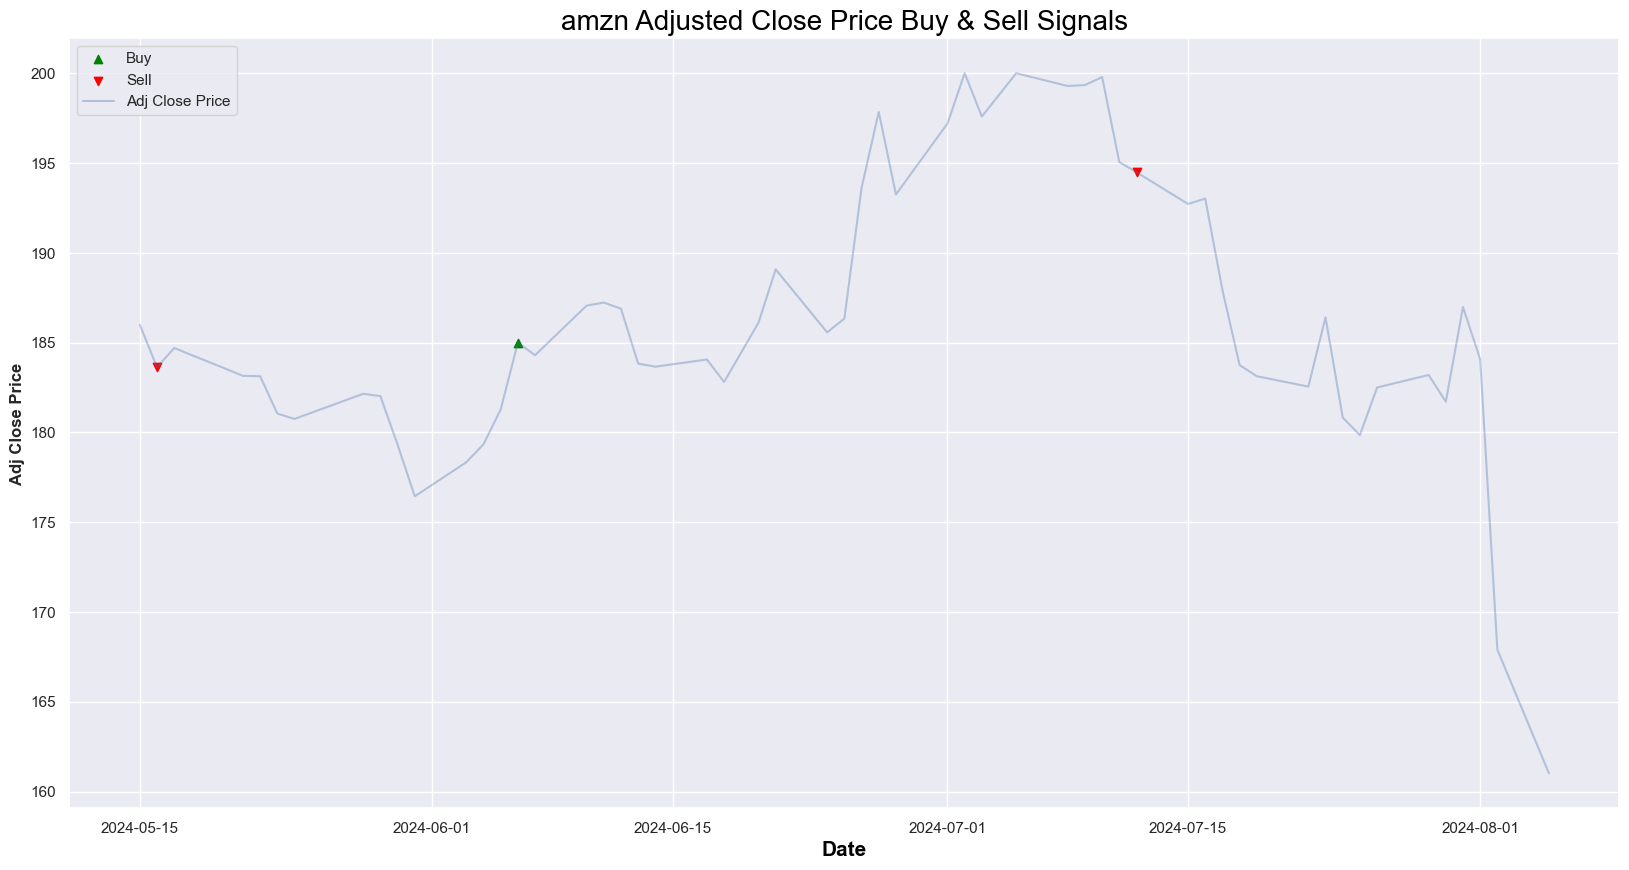

In [ ]:
# Extract data for amzn from May 15 to August 15, 2024
amzn_adj_3mo = amzn_sma[['Adj Close']]['2024-05-15':'2024-08-15']

# Calculate EMAs and MACD
ShortEMA = amzn_adj_3mo['Adj Close'].ewm(span=12, adjust=False).mean()
LongEMA = amzn_adj_3mo['Adj Close'].ewm(span=26, adjust=False).mean()
MACD = ShortEMA - LongEMA
signal = MACD.ewm(span=9, adjust=False).mean()

# Create new columns for the MACD and Signal Line data
amzn_adj_3mo['MACD'] = MACD
amzn_adj_3mo['Signal Line'] = signal

# Function to signal when to buy and sell
def buy_sell_macd(signal):
    Buy = []
    Sell = []
    flag = -1

    for i in range(len(signal)):
        if signal['MACD'][i] > signal['Signal Line'][i]:
            Sell.append(np.nan)
            if flag != 1:
                Buy.append(signal['Adj Close'][i])
                flag = 1
            else:
                Buy.append(np.nan)
        elif signal['MACD'][i] < signal['Signal Line'][i]:
            Buy.append(np.nan)
            if flag != 0:
                Sell.append(signal['Adj Close'][i])
                flag = 0
            else:
                Sell.append(np.nan)
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)

    return (Buy, Sell)

# Create buy and sell columns
a = buy_sell_macd(amzn_adj_3mo)
amzn_adj_3mo['Buy_Signal_Price'] = a[0]
amzn_adj_3mo['Sell_Signal_Price'] = a[1]

# Plot buy and sell signals
def buy_sell_macd_plot():
    plt.figure(figsize=(20, 10))
    plt.scatter(amzn_adj_3mo.index, amzn_adj_3mo['Buy_Signal_Price'], color='green', label='Buy', marker='^', alpha=1)
    plt.scatter(amzn_adj_3mo.index, amzn_adj_3mo['Sell_Signal_Price'], color='red', label='Sell', marker='v', alpha=1)
    plt.plot(amzn_adj_3mo['Adj Close'], label='Adj Close Price', alpha=0.35)
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Adj Close Price')
    plt.legend(loc='upper left')
    plt.show()

# Set labels and titles
ticker = 'amzn'
title_txt = 'amzn Adjusted Close Price Buy & Sell Signals'

# Call the function to plot
buy_sell_macd_plot()

5.2 Momentum Strategies
In momentum algorithmic trading strategies stocks have momentum (i.e. upward or downward trends) that we can detect and exploit.

5.2.1 Relative Strength Index (RSI)
The RSI is a momentum indicator. A typical momentum strategy will buy stocks that have been showing an upward trend in hopes that the trend will continue, and make predictions based on whether the past recent values were going up or going down.

The RSI determines the level of overbought (70) and oversold (30) zones using a default lookback period of 14 i.e. it uses the last 14 values to calculate its values. The idea is to buy when the RSI touches the 30 barrier and sell when it touches the 70 barrier.

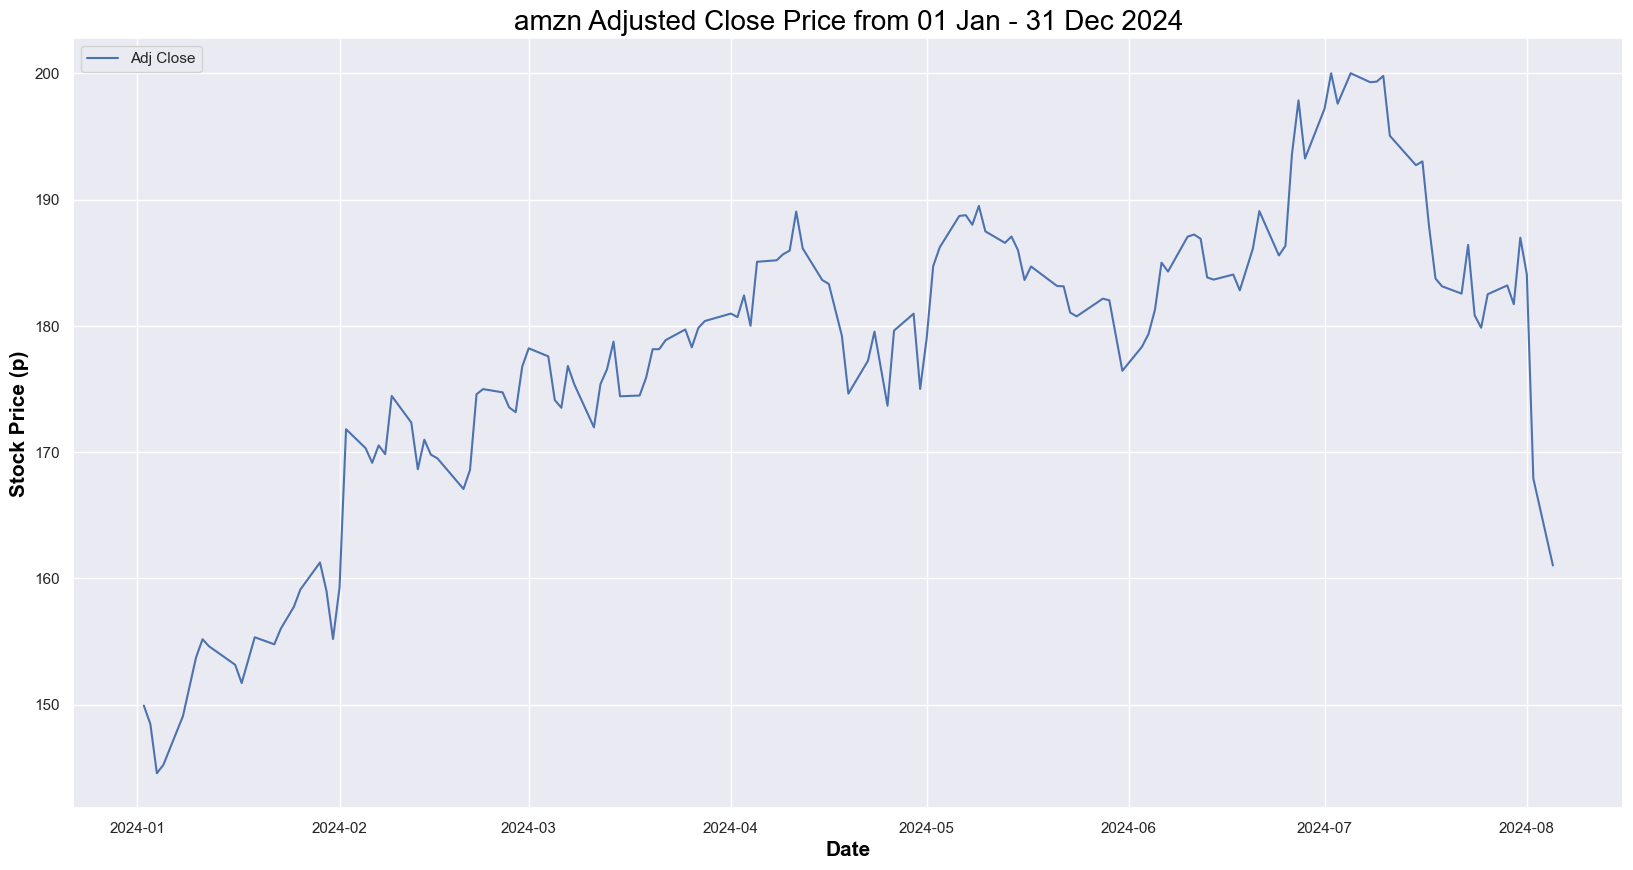

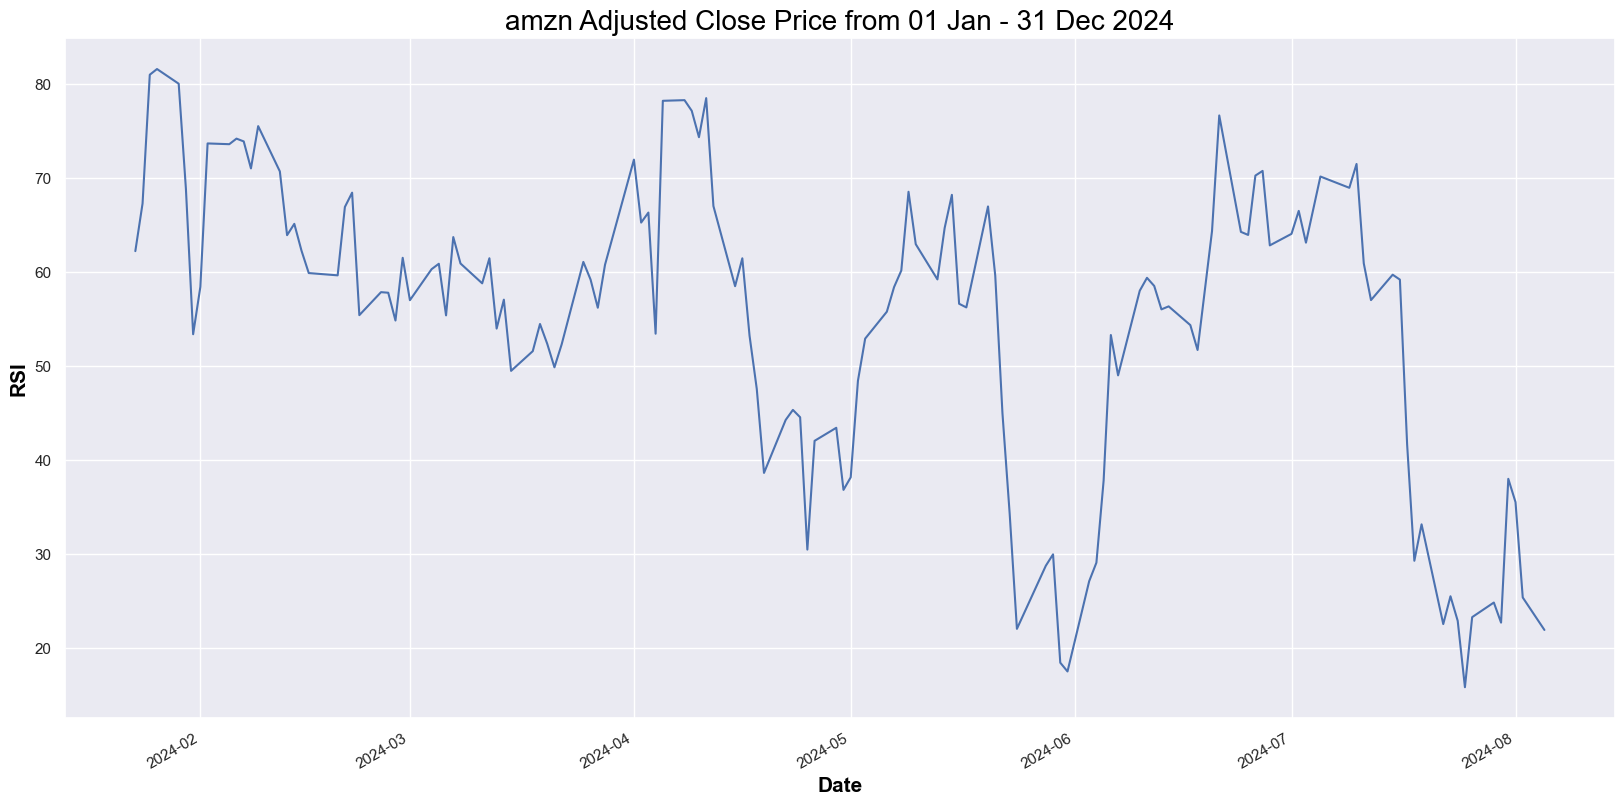

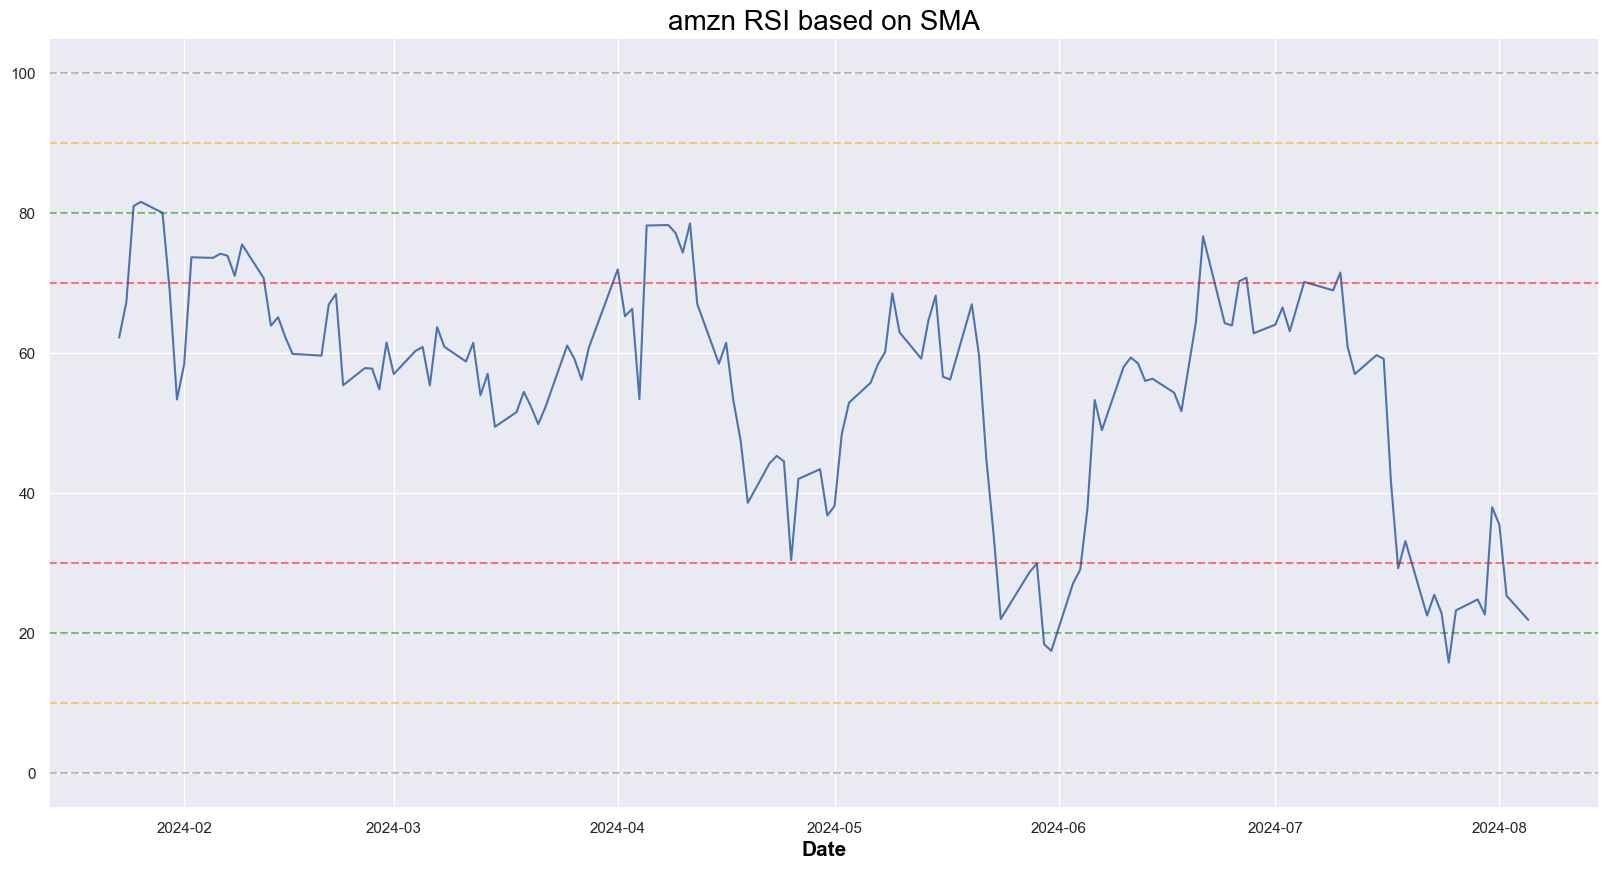

In [ ]:
# Extract data for amzn from May 15 to August 15, 2024
amzn_adj_12mo = amzn_sma[['Adj Close']]['2024-01-01':'2024-12-31']

# Calculate the RSI
delta = amzn_adj_12mo['Adj Close'].diff(1)
up = delta.copy()
down = delta.copy()

up[up < 0] = 0
down[down > 0] = 0

period = 14

# Calculate average gain and average loss
AVG_Gain = up.rolling(window=period).mean()
AVG_Loss = down.abs().rolling(window=period).mean()

# Calculate RSI based on SMA
RS = AVG_Gain / AVG_Loss
RSI = 100.0 - (100.0 / (1.0 + RS))

# Create dataframe with Adjusted Close and RSI
new_df = pd.DataFrame()
new_df['Adj Close'] = amzn_adj_12mo['Adj Close']
new_df['RSI'] = RSI

# Function to plot Adjusted Close price
def adj_close_12mo():
    sns.set(rc={'figure.figsize':(20, 10)})
    plt.plot(new_df.index, new_df['Adj Close'], label='Adj Close')
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Stock Price (p)', color='black', fontsize=15)
    plt.legend(loc='upper left')
    plt.show()

# Function to plot RSI
def rsi():
    sns.set(rc={'figure.figsize':(20, 10)})
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('RSI', color='black', fontsize=15)
    RSI.plot()
    plt.show()

# Function to plot RSI with significant levels
def rsi_sma():
    plt.figure(figsize=(20, 10))
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.plot(new_df.index, new_df['RSI'], label='RSI')
    plt.axhline(0, linestyle='--', alpha=0.5, color='gray')
    plt.axhline(10, linestyle='--', alpha=0.5, color='orange')
    plt.axhline(20, linestyle='--', alpha=0.5, color='green')
    plt.axhline(30, linestyle='--', alpha=0.5, color='red')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')
    plt.axhline(80, linestyle='--', alpha=0.5, color='green')
    plt.axhline(90, linestyle='--', alpha=0.5, color='orange')
    plt.axhline(100, linestyle='--', alpha=0.5, color='gray')
    plt.xlabel('Date', color='black', fontsize=15)
    plt.show()

# Set labels and titles
ticker = 'amzn'
title_txt = 'amzn Adjusted Close Price from 01 Jan - 31 Dec 2024'

# Call the functions to plot
adj_close_12mo()
rsi()
title_txt = 'amzn RSI based on SMA'
rsi_sma()

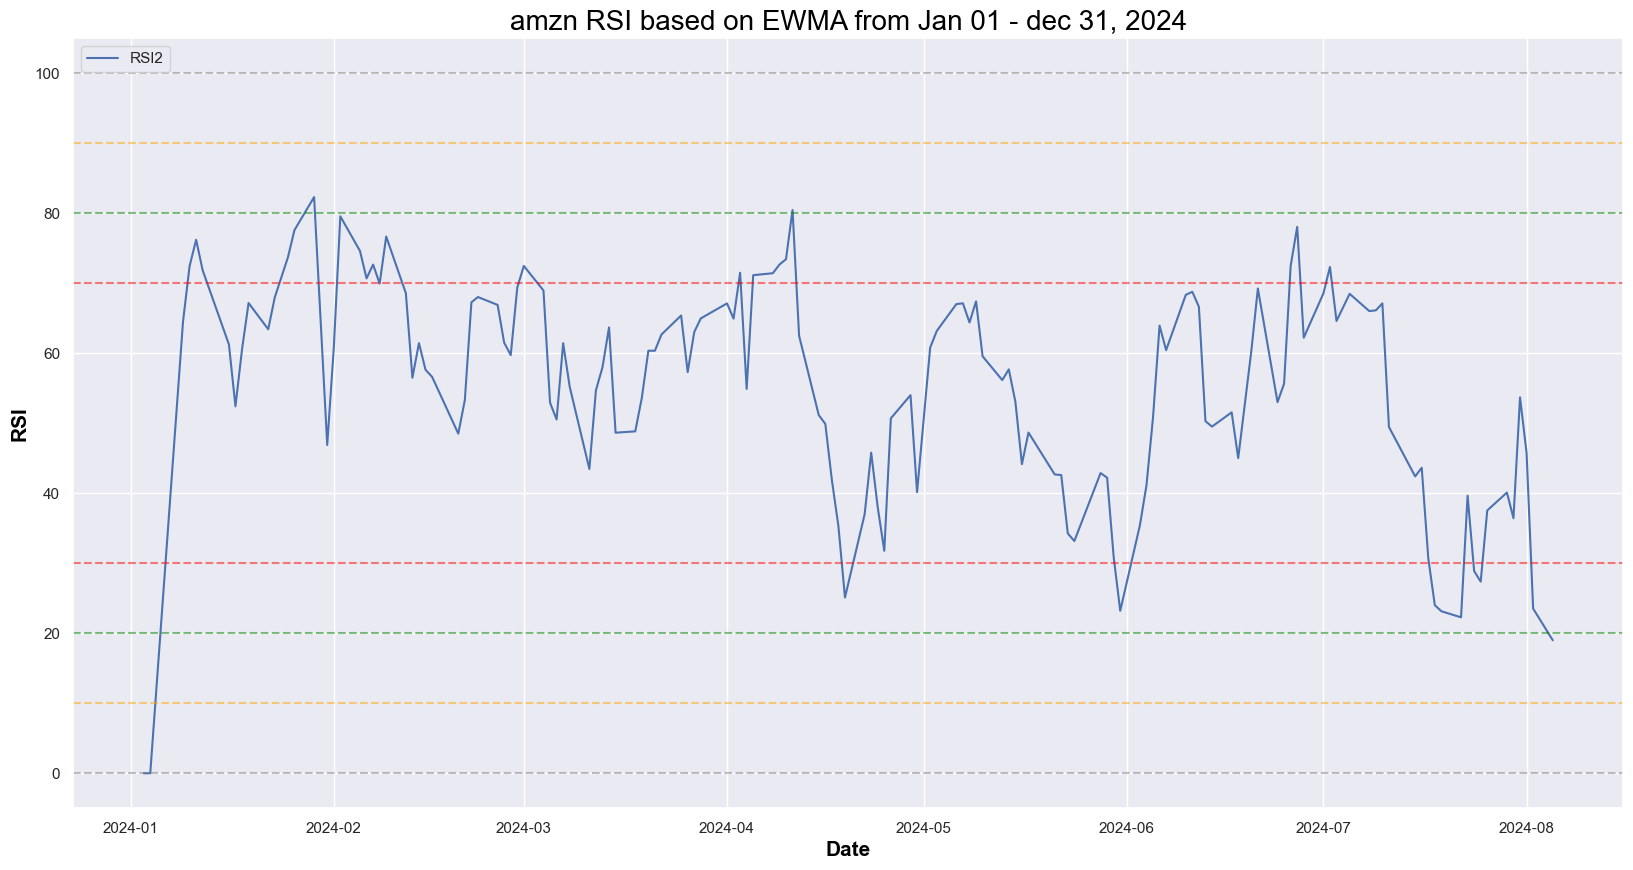

In [ ]:
# Define period for RSI calculation
period = 14

# Update the data for amzn for the period May 15 to August 15, 2024
amzn_adj_3mo = amzn_sma[['Adj Close']]['2024-01-01':'2024-12-31']

# Calculate the daily price changes
delta = amzn_adj_3mo['Adj Close'].diff(1)

# Get positive gains (up) and negative gains (down)
up = delta.copy()
down = delta.copy()

up[up < 0] = 0
down[down > 0] = 0 

# Calculate EWMA average gain and average loss
AVG_Gain2 = up.ewm(span=period).mean()
AVG_Loss2 = down.abs().ewm(span=period).mean()

# Calculate RSI based on EWMA
RS2 = AVG_Gain2 / AVG_Loss2
RSI2 = 100.0 - (100.0 / (1.0 + RS2))

# Create DataFrame for Adjusted Close and EWMA RSI
new_df2 = pd.DataFrame()
new_df2['Adj Close'] = amzn_adj_3mo['Adj Close']
new_df2['RSI2'] = RSI2

# Function to plot RSI with significant levels
def rsi_ewma():
    plt.figure(figsize=(20, 10))
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('RSI', color='black', fontsize=15)
    plt.plot(new_df2.index, new_df2['RSI2'], label='RSI2')
    plt.axhline(0, linestyle='--', alpha=0.5, color='gray')
    plt.axhline(10, linestyle='--', alpha=0.5, color='orange')
    plt.axhline(20, linestyle='--', alpha=0.5, color='green')
    plt.axhline(30, linestyle='--', alpha=0.5, color='red')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')
    plt.axhline(80, linestyle='--', alpha=0.5, color='green')
    plt.axhline(90, linestyle='--', alpha=0.5, color='orange')
    plt.axhline(100, linestyle='--', alpha=0.5, color='gray')
    plt.legend(loc='upper left')
    plt.show()

# Set title for the plot
title_txt = 'amzn RSI based on EWMA from Jan 01 - dec 31, 2024'

# Call the function to plot
rsi_ewma()

It appears that RSI value dips below the 20 significant level in January 2024 indicating that the stock was oversold and presented a buying opportunity for an investor before a price rise.

5.2.2 Money Flow Index (MFI)
Money Flow Index (MFI) is a technical oscillator, and momentum indicator, that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100 and a reading of above 80 implies overbought conditions, and below 20 implies oversold conditions.

It is related to the Relative Strength Index (RSI) but incorporates volume, whereas the RSI only considers price.

C:\Users\Admin\AppData\Local\Temp\ipykernel_13256\1935104893.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_mfi_df['MFI'] = mfi
C:\Users\Admin\AppData\Local\Temp\ipykernel_13256\1935104893.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_mfi_df['Buy'] = get_signal(new_mfi_df, 80, 20)[0]
C:\Users\Admin\AppData\Local\Temp\ipykernel_13256\1935104893.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

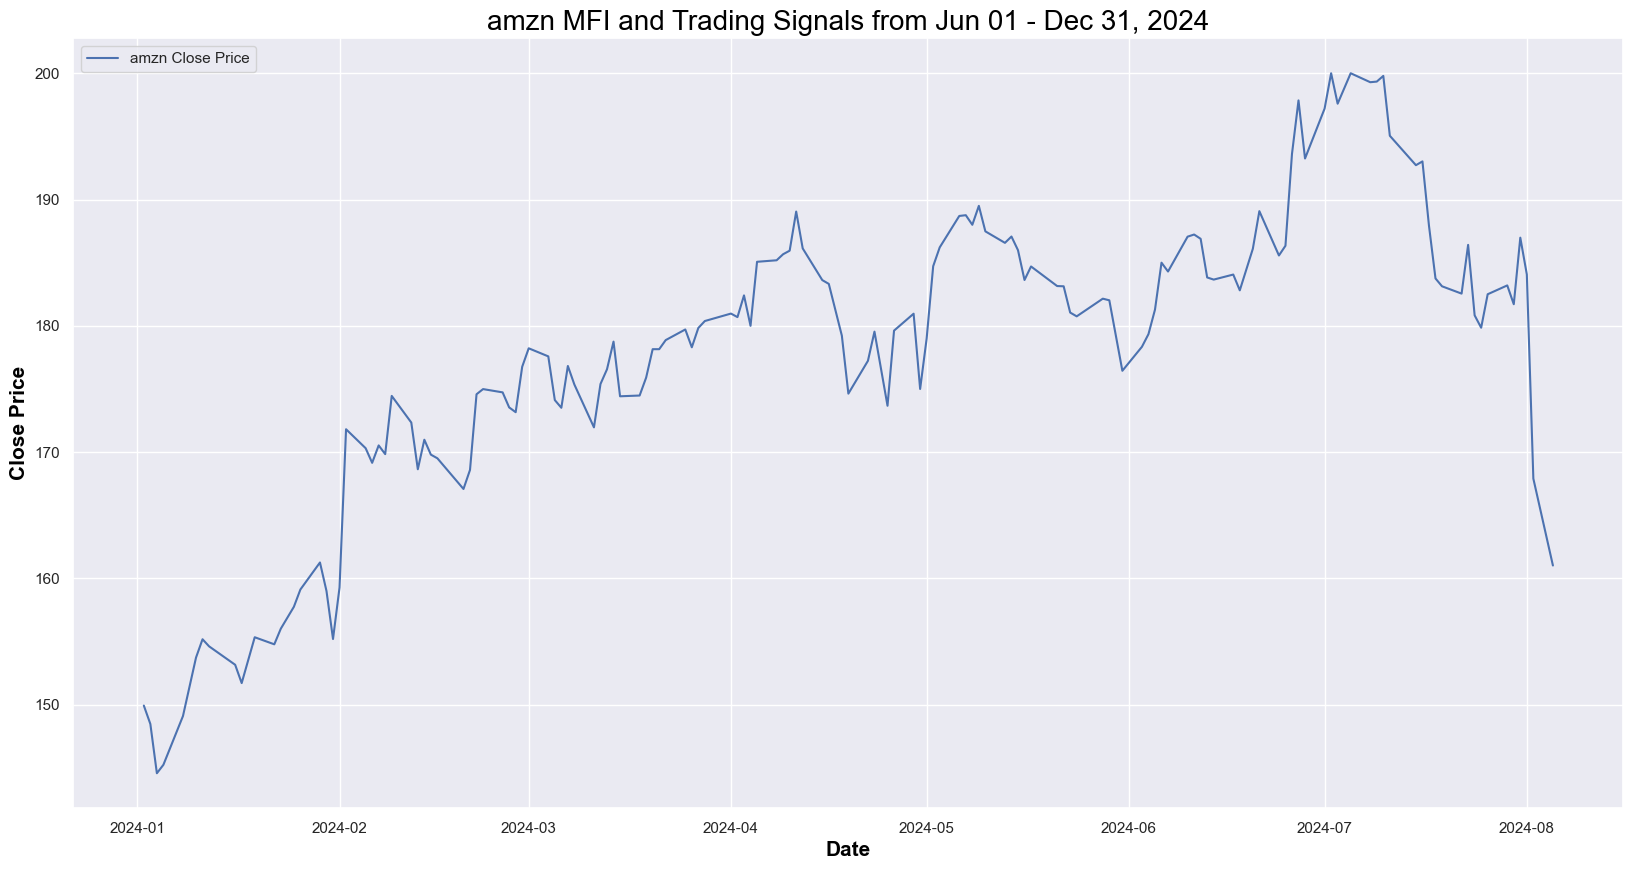

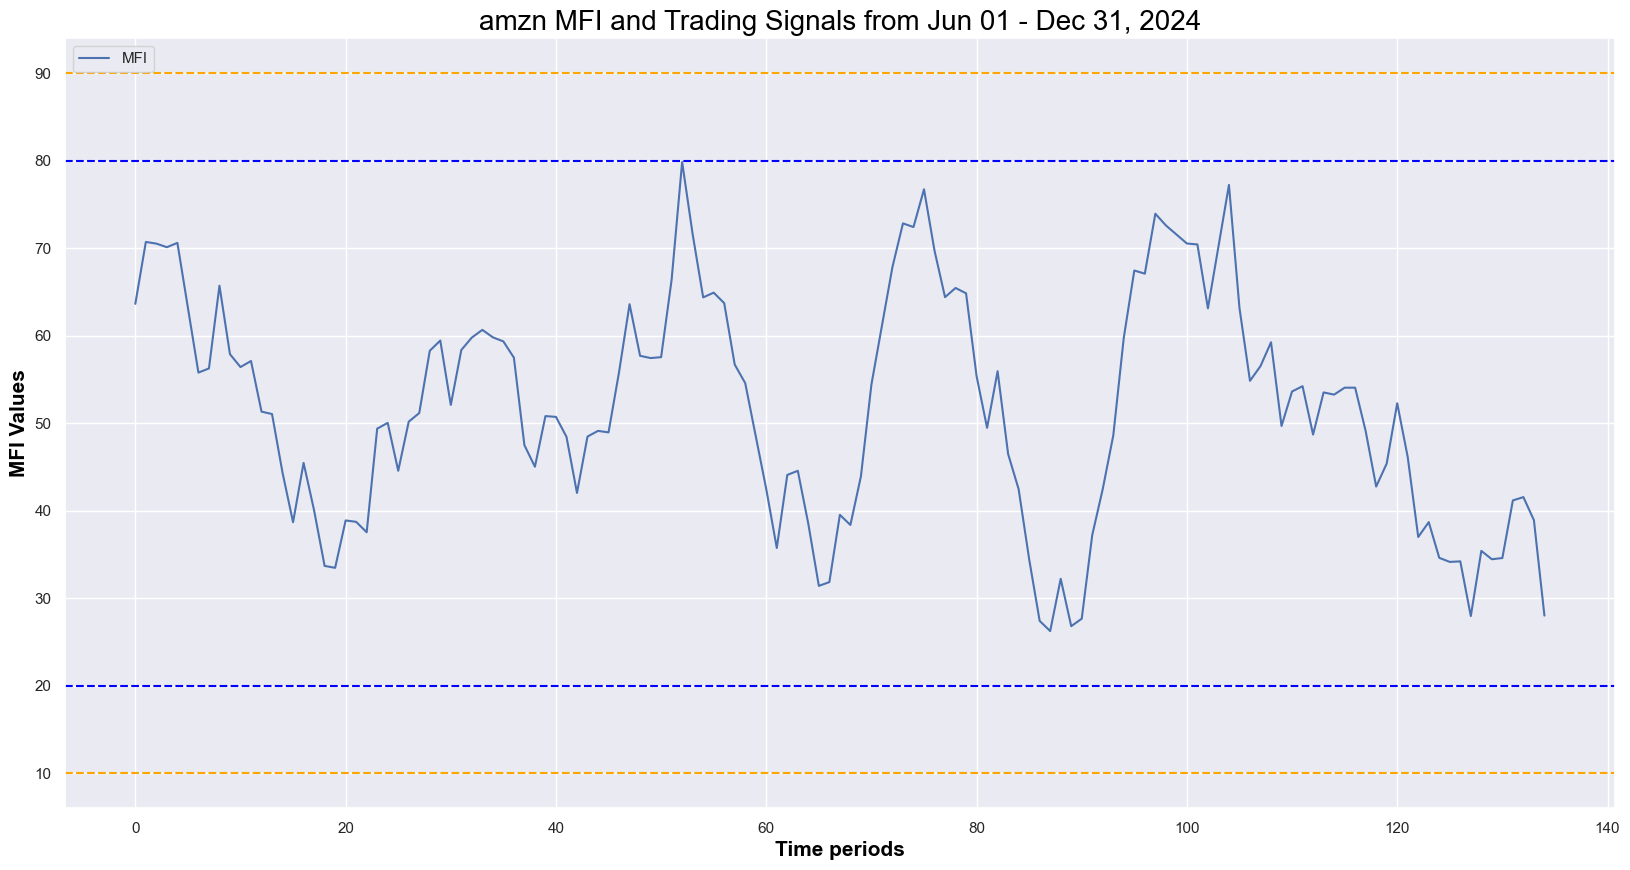

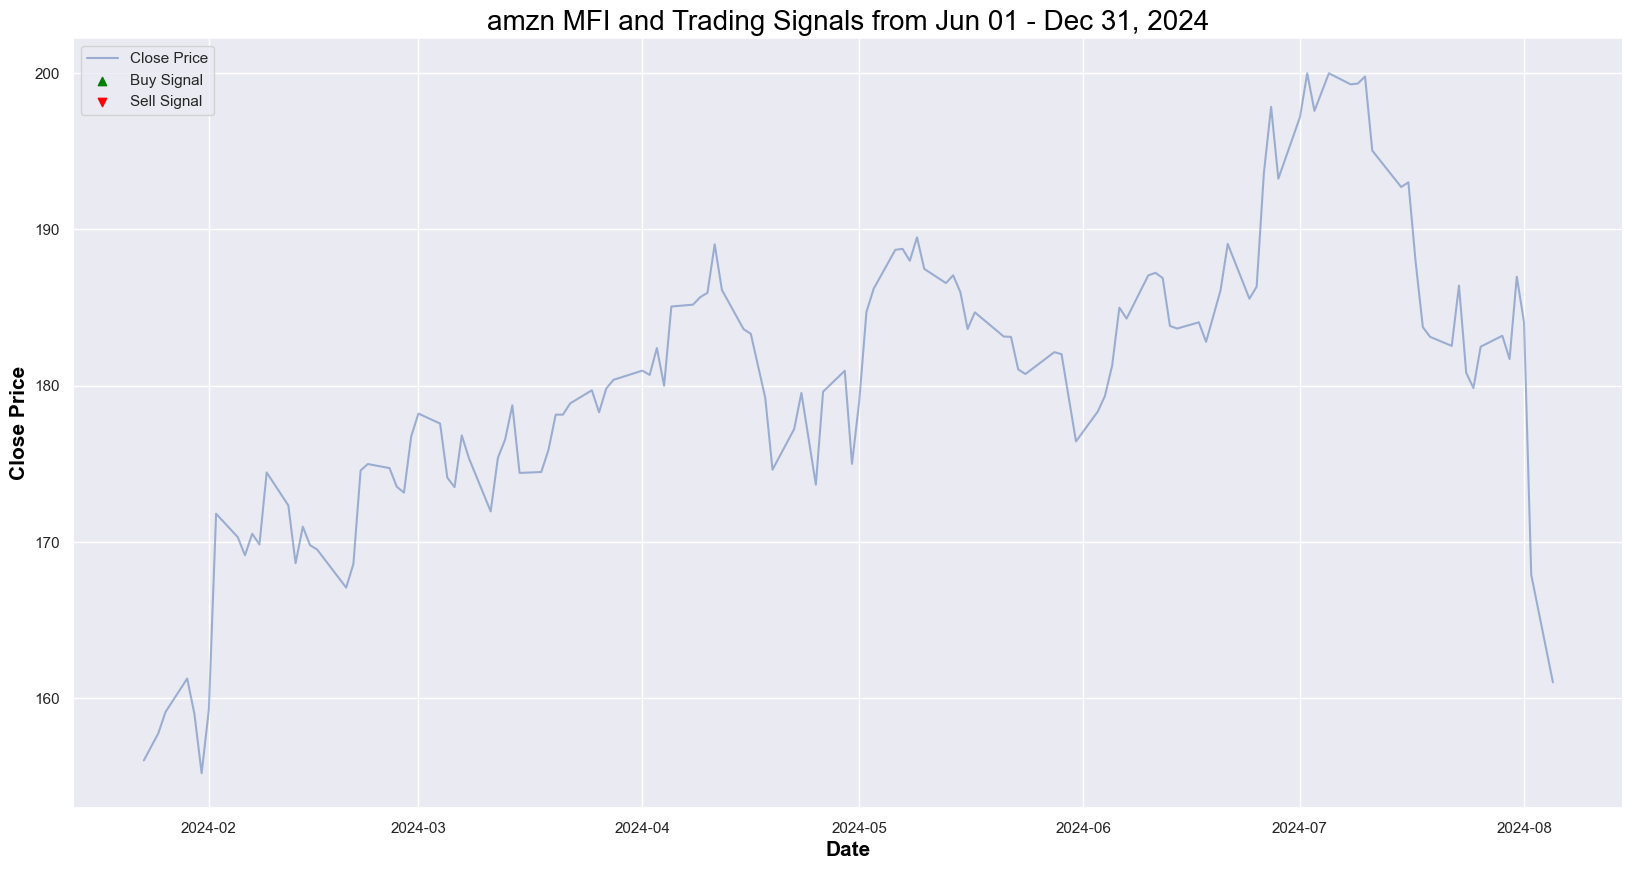

In [ ]:
# Define period for MFI calculation
period = 14

# Extract data for amzn for the period May 15 to August 15, 2024
amzn_3mo = amzn_sma[['Close', 'High', 'Low', 'Volume']]['2024-01-01':'2024-12-31']

# Function to plot Close Price
def amzn_close_plot():
    plt.figure(figsize=(20, 10))
    plt.plot(amzn_3mo['Close'])
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Close Price', color='black', fontsize=15)
    plt.legend([label_txt], loc='upper left')
    plt.show()

# Calculate typical price
typical_price = (amzn_3mo['Close'] + amzn_3mo['High'] + amzn_3mo['Low']) / 3

# Calculate the money flow
money_flow = typical_price * amzn_3mo['Volume']

# Get all positive and negative money flows
positive_flow = []
negative_flow = []

# Loop through typical price
for i in range(1, len(typical_price)):
    if typical_price[i] > typical_price[i-1]:
        positive_flow.append(money_flow[i-1])
        negative_flow.append(0)
    elif typical_price[i] < typical_price[i-1]:
        negative_flow.append(money_flow[i-1])
        positive_flow.append(0)
    else:
        positive_flow.append(0)
        negative_flow.append(0)

# Get all positive and negative money flows within the same time period
positive_mf = []
negative_mf = []

for i in range(period-1, len(positive_flow)):
    positive_mf.append(sum(positive_flow[i + 1 - period : i+1]))
for i in range(period-1, len(negative_flow)):
    negative_mf.append(sum(negative_flow[i + 1 - period : i+1]))

# Calculate Money Flow Index (MFI)
mfi = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))

# Create DataFrame for MFI
df2 = pd.DataFrame()
df2['MFI'] = mfi

# Function to plot MFI
def mfi_plot():
    plt.figure(figsize=(20, 10))
    plt.plot(df2['MFI'], label='MFI')
    plt.axhline(10, linestyle='--', color='orange')
    plt.axhline(20, linestyle='--', color='blue')
    plt.axhline(80, linestyle='--', color='blue')
    plt.axhline(90, linestyle='--', color='orange')
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xlabel('Time periods', color='black', fontsize=15)
    plt.ylabel('MFI Values', color='black', fontsize=15)
    plt.legend(loc='upper left')
    plt.show()

# Create new DataFrame with MFI
new_mfi_df = pd.DataFrame()
new_mfi_df = amzn_3mo[period:]
new_mfi_df['MFI'] = mfi

# Function to get buy and sell signals
def get_signal(data, high, low):
    buy_signal = []
    sell_signal = []

    for i in range(len(data['MFI'])):
        if data['MFI'][i] > high:
            buy_signal.append(np.nan)
            sell_signal.append(data['Close'][i])
        elif data['MFI'][i] < low:
            buy_signal.append(data['Close'][i])
            sell_signal.append(np.nan)
        else:
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    return (buy_signal, sell_signal)

# Add new columns (Buy & Sell)
new_mfi_df['Buy'] = get_signal(new_mfi_df, 80, 20)[0]
new_mfi_df['Sell'] = get_signal(new_mfi_df, 80, 20)[1]

# Function to plot buy and sell signals
def mfi_buy_sell_plot():
    plt.figure(figsize=(20, 10))
    plt.plot(new_mfi_df['Close'], label='Close Price', alpha=0.5)
    plt.scatter(new_mfi_df.index, new_mfi_df['Buy'], color='green', label='Buy Signal', marker='^', alpha=1)
    plt.scatter(new_mfi_df.index, new_mfi_df['Sell'], color='red', label='Sell Signal', marker='v', alpha=1)
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Close Price', color='black', fontsize=15)
    plt.legend(loc='upper left')
    plt.show()

# Set title for the plots
title_txt = "amzn MFI and Trading Signals from Jun 01 - Dec 31, 2024"
label_txt = "amzn Close Price"

# Call functions to plot
amzn_close_plot()
mfi_plot()
mfi_buy_sell_plot()

5.2.3 Stochastic Oscillator
The stochastic oscillator is a momentum indicator comparing the closing price of a security to the range of its prices over a certain period of time and is one of the best-known momentum indicators along with RSI and MACD.

The intuition is that in a market trending upward, prices will close near the high, and in a market trending downward, prices close near the low.

The stochastic oscillator is plotted within a range of zero and 100. The default parameters are an overbought zone of 80, an oversold zone of 20 and well-used lookbacks period of 14 and 5 which can be used simultaneously. The oscillator has two lines, the %K and %D, where the former measures momentum and the latter measures the moving average of the former. The %D line is more important of the two indicators and tends to produce better trading signals which are created when the %K crosses through the %D.

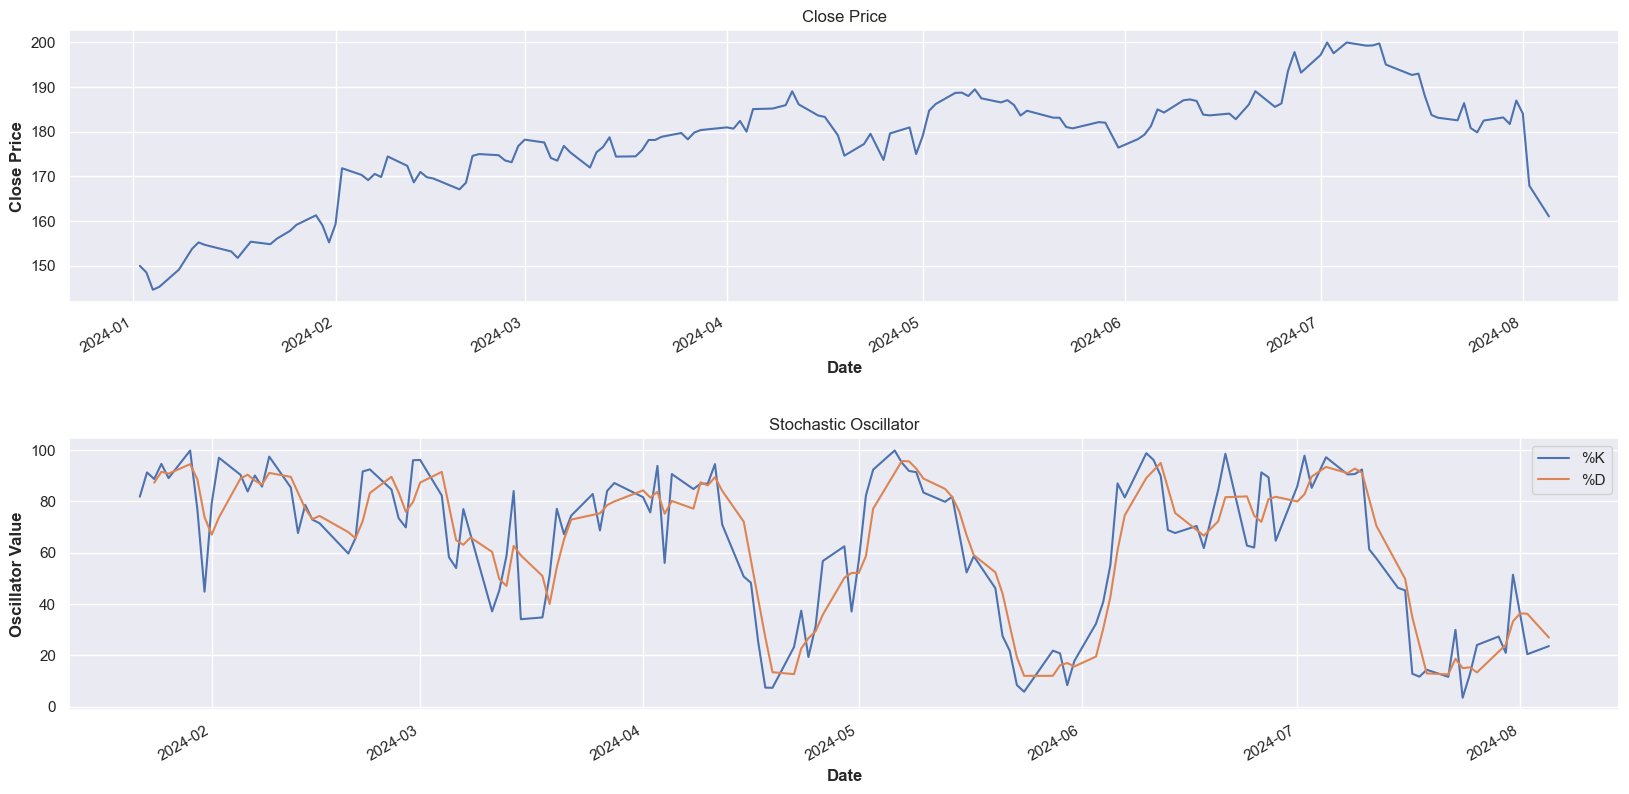

C:\Users\Admin\AppData\Local\Temp\ipykernel_13256\54382173.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_so['Short'].iloc[0] = 0
C:\Users\Admin\AppData\Local\Temp\ipykernel_13256\54382173.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_so['Long'].iloc[0] = 0


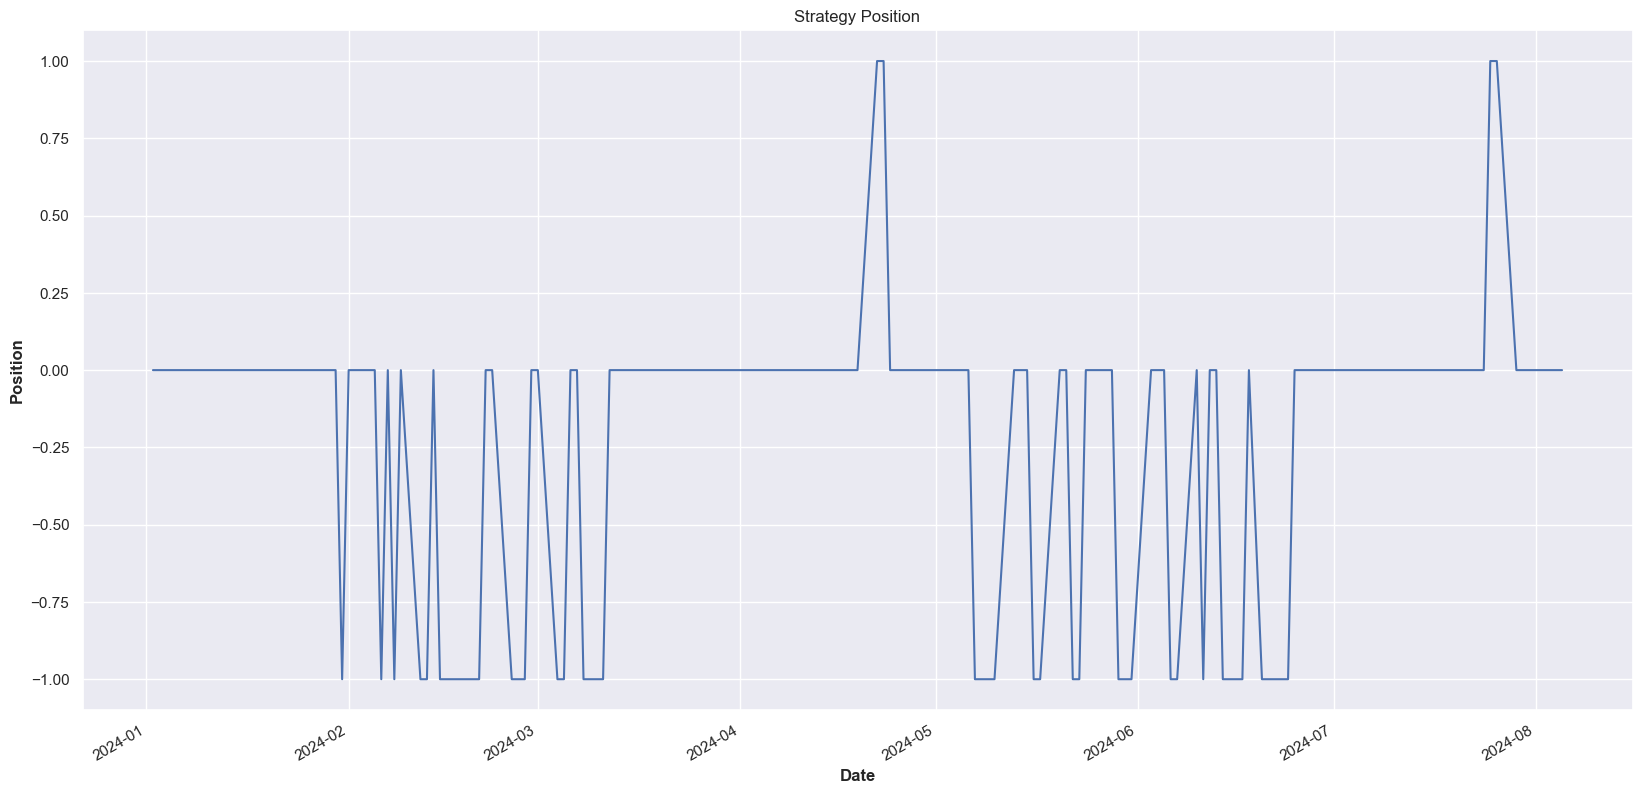

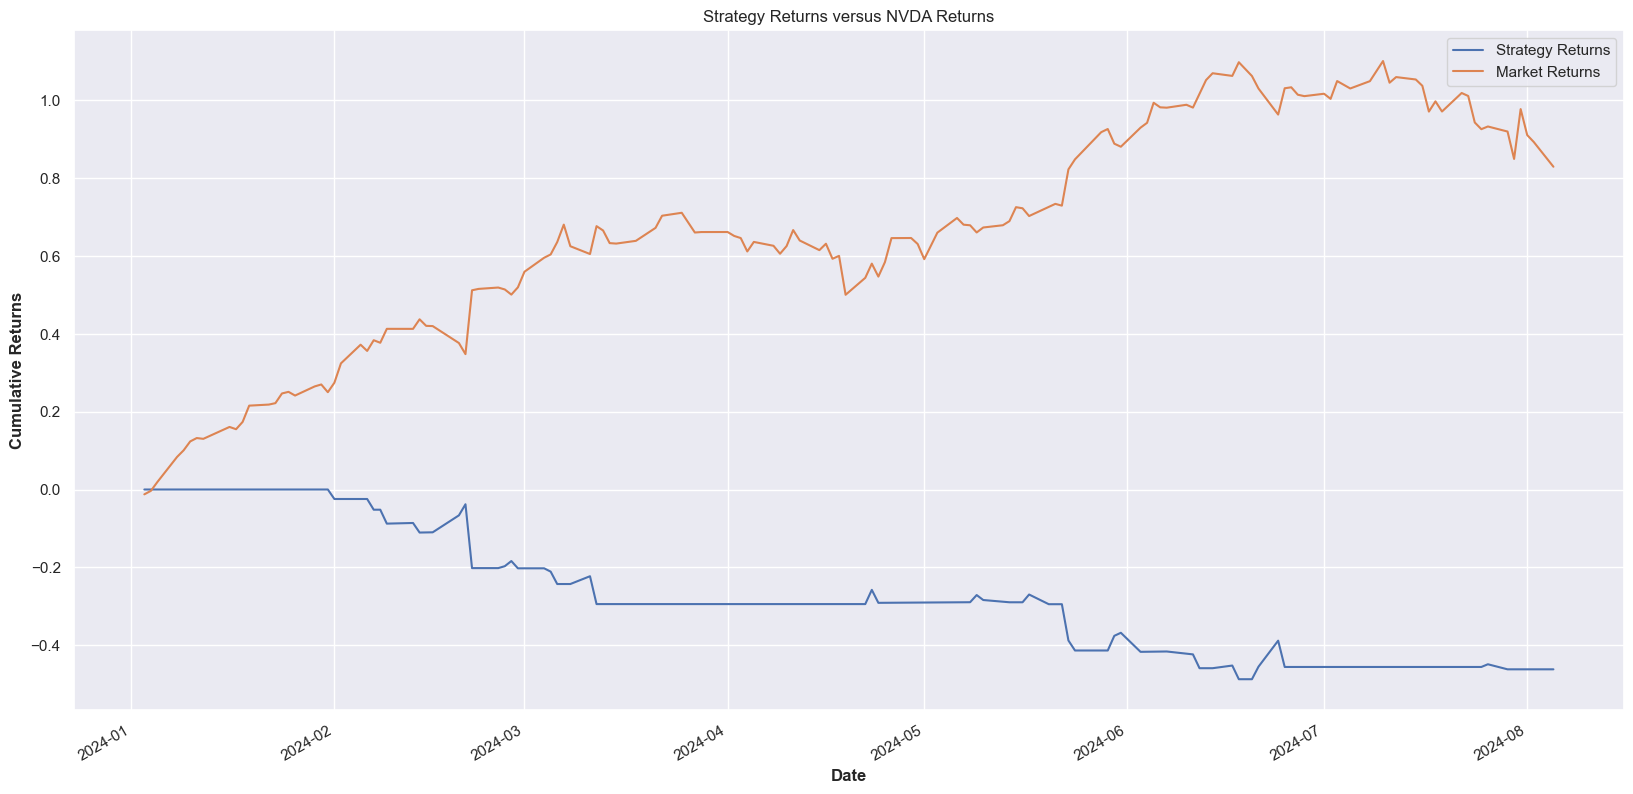

In [ ]:
# Define period for the rolling windows
period = 14

# Assuming `amzn` is the DataFrame with AMZN stock data for the period May 15 to August 15, 2024
amzn_so = amzn_sma.copy()
amzn_so = amzn_so['2024-01-01':'2024-12-31']

# Create the "L14" column in the DataFrame
amzn_so['L14'] = amzn_so['Low'].rolling(window=period).min()

# Create the "H14" column in the DataFrame
amzn_so['H14'] = amzn_so['High'].rolling(window=period).max()

# Create the "%K" column in the DataFrame
amzn_so['%K'] = 100 * ((amzn_so['Close'] - amzn_so['L14']) / (amzn_so['H14'] - amzn_so['L14']))

# Create the "%D" column in the DataFrame
amzn_so['%D'] = amzn_so['%K'].rolling(window=3).mean()

# Plot Close price and Stochastic Oscillator
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)

amzn_so['Close'].plot(ax=axes[0])
axes[0].set_title('Close Price')
axes[0].set_ylabel('Close Price')

amzn_so[['%K', '%D']].plot(ax=axes[1])
axes[1].set_title('Stochastic Oscillator')
axes[1].set_ylabel('Oscillator Value')
plt.show()

# Create a column for sell entry signal
amzn_so['Sell Entry'] = ((amzn_so['%K'] < amzn_so['%D']) & (amzn_so['%K'].shift(1) > amzn_so['%D'].shift(1))) & (amzn_so['%D'] > 80)

# Create a column for sell exit signal
amzn_so['Sell Exit'] = ((amzn_so['%K'] > amzn_so['%D']) & (amzn_so['%K'].shift(1) < amzn_so['%D'].shift(1)))

# Create a column for buy entry signal
amzn_so['Buy Entry'] = ((amzn_so['%K'] > amzn_so['%D']) & (amzn_so['%K'].shift(1) < amzn_so['%D'].shift(1))) & (amzn_so['%D'] < 20)

# Create a column for buy exit signal
amzn_so['Buy Exit'] = ((amzn_so['%K'] < amzn_so['%D']) & (amzn_so['%K'].shift(1) > amzn_so['%D'].shift(1)))

# Create a placeholder column for short positions
amzn_so['Short'] = np.nan
amzn_so.loc[amzn_so['Sell Entry'], 'Short'] = -1
amzn_so.loc[amzn_so['Sell Exit'], 'Short'] = 0

# Set initial position to flat
amzn_so['Short'].iloc[0] = 0

# Forward fill the position column
amzn_so['Short'] = amzn_so['Short'].fillna(method='ffill')

# Create a placeholder column for long positions


amzn_so['Long'] = np.nan
amzn_so.loc[amzn_so['Buy Entry'], 'Long'] = 1
amzn_so.loc[amzn_so['Buy Exit'], 'Long'] = 0

# Set initial position to flat
amzn_so['Long'].iloc[0] = 0

# Forward fill the position column
amzn_so['Long'] = amzn_so['Long'].fillna(method='ffill')

# Add Long and Short positions together to get final strategy position
amzn_so['Position'] = amzn_so['Long'] + amzn_so['Short']

# Plot the position through time
amzn_so['Position'].plot(figsize=(20, 10))
plt.title('Strategy Position')
plt.ylabel('Position')
plt.show()

# Set up a column holding the daily amzn returns
amzn_so['Market Returns'] = amzn_so['Close'].pct_change()

# Create column for Strategy Returns
amzn_so['Strategy Returns'] = amzn_so['Market Returns'] * amzn_so['Position'].shift(1)

# Plot strategy returns versus amzn returns
amzn_so[['Strategy Returns', 'Market Returns']].cumsum().plot(figsize=(20, 10))
plt.title('Strategy Returns versus amzn Returns')
plt.ylabel('Cumulative Returns')
plt.show()

 5.2.4 Rate of Change (ROC)  ---------------          Candlestick, ROC and Volume plot        ----------------------------------
The ROC indicator is a pure momentum oscillator. The ROC calculation compares the current price with the price "n" periods ago e.g. when we compute the ROC of the daily price with a 9-day lag, we are simply looking at how much, in percentage, the price has gone up (or down) compared to 9 days ago. Like other momentum indicators, ROC has overbought and oversold zones that may be adjusted according to market conditions.

C:\Users\Admin\AppData\Local\Temp\ipykernel_13256\1667961888.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amzn_roc_12mo['ROC'] = (amzn_roc_12mo['Adj Close'] / amzn_roc_12mo['Adj Close'].shift(9) - 1) * 100


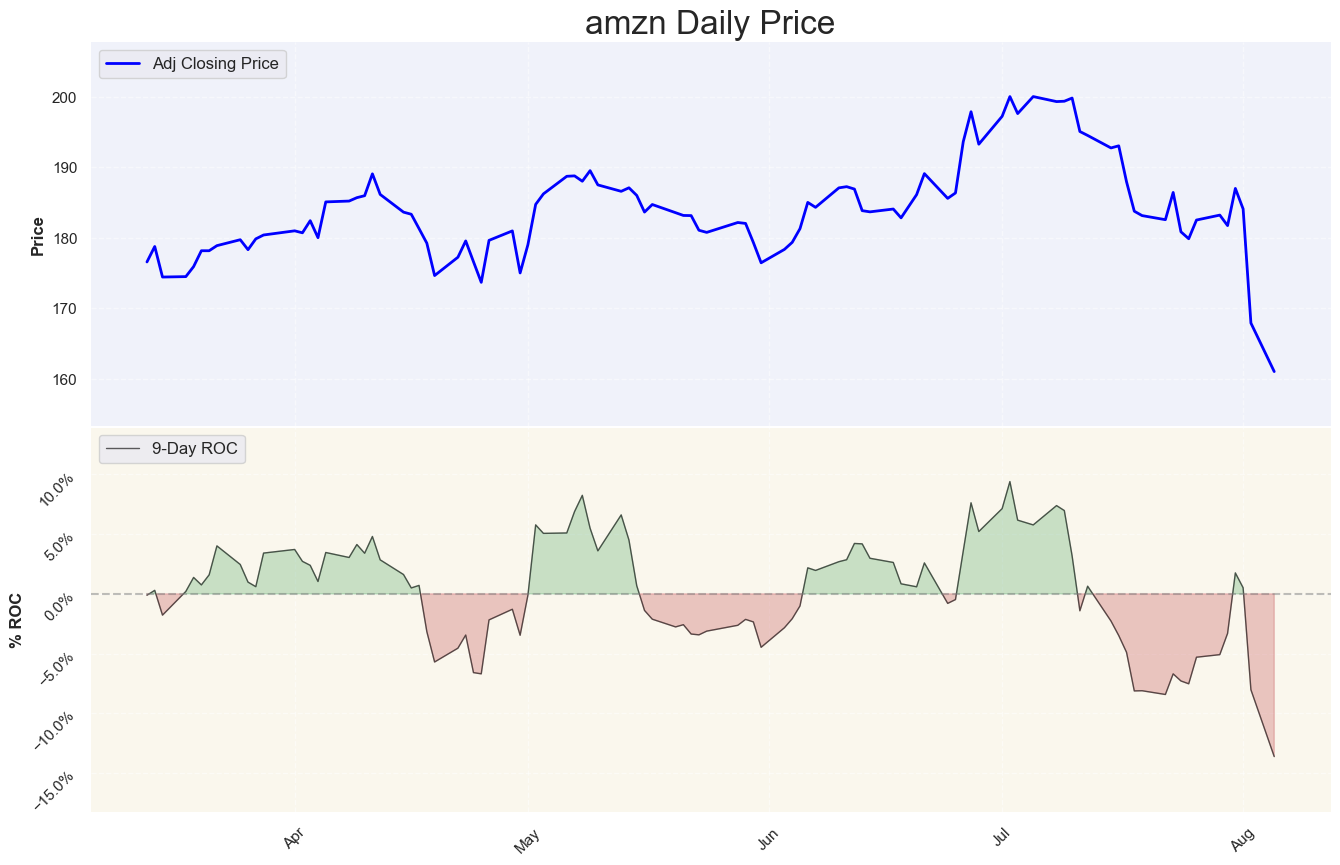

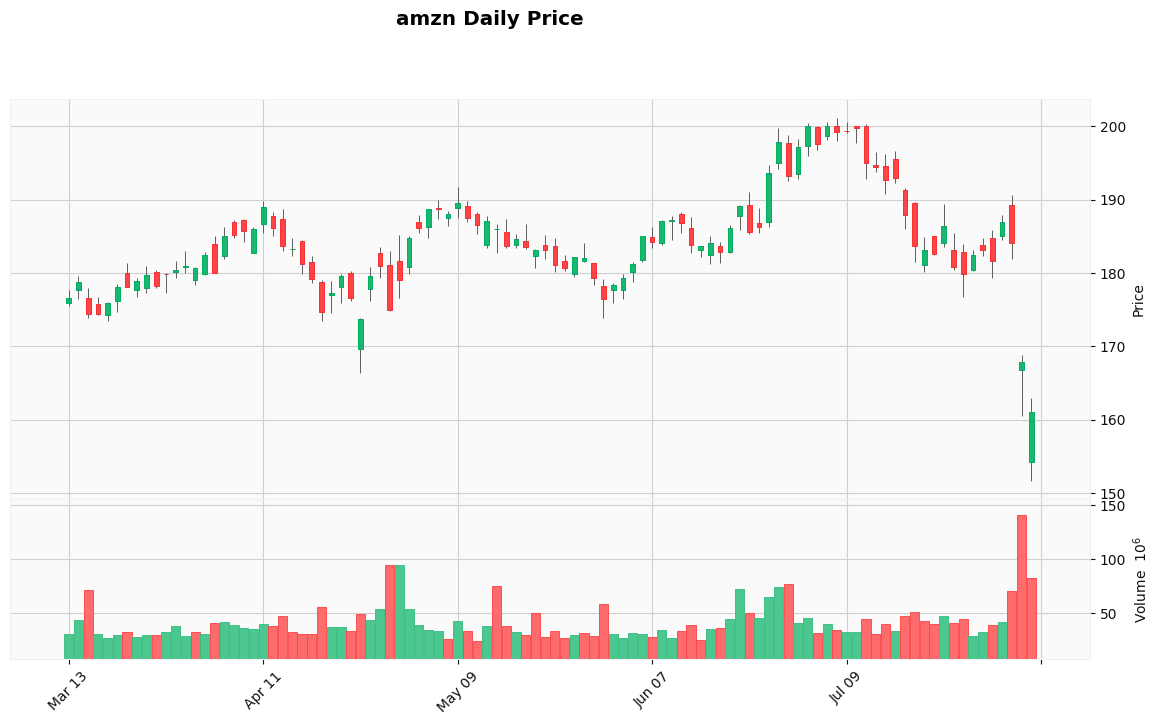

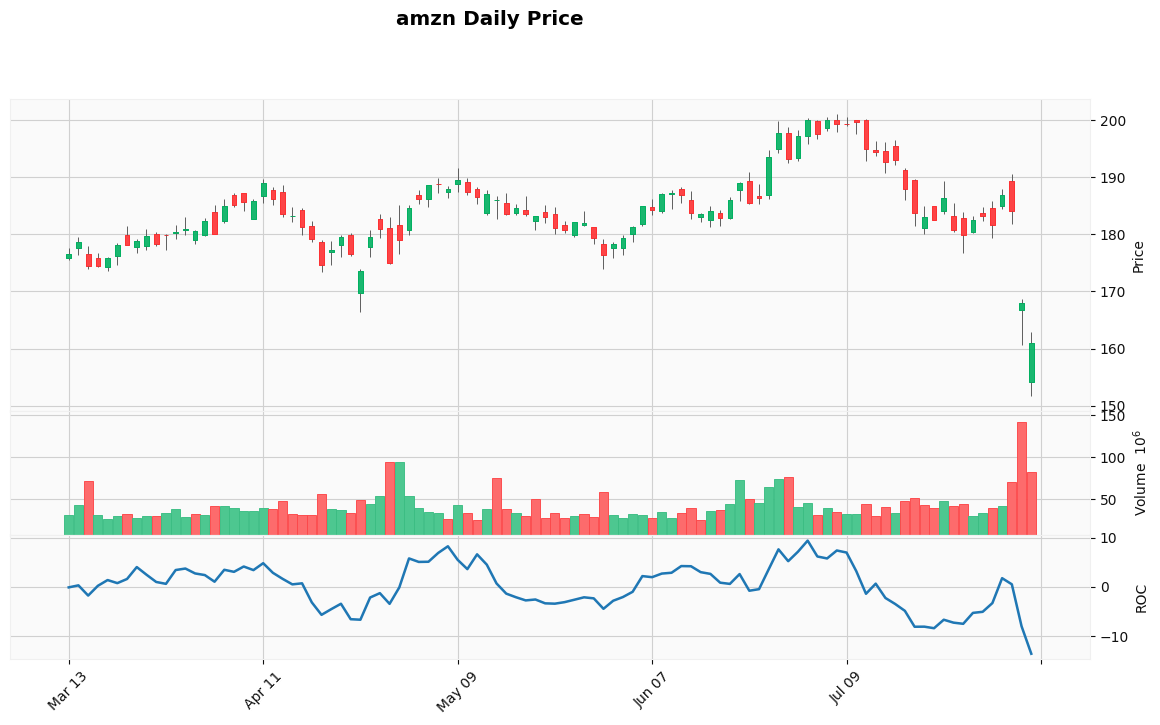

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mplfinance as mpf

# Assuming `amzn_sma` is the DataFrame with amzn stock data
amzn_roc = amzn_sma.copy()
amzn_roc_12mo = amzn_roc['2024-01-01':'2024-12-31']

# Calculate ROC
amzn_roc_12mo['ROC'] = (amzn_roc_12mo['Adj Close'] / amzn_roc_12mo['Adj Close'].shift(9) - 1) * 100

# Select data for the last 100 days of 2024
amzn_roc_100d = amzn_roc_12mo[-100:]
dates = amzn_roc_100d.index
price = amzn_roc_100d['Adj Close']
roc = amzn_roc_100d['ROC']

# Plot Price and ROC
fig, (price_ax, roc_ax) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
fig.subplots_adjust(hspace=0)

plt.rcParams.update({'font.size': 14})

# Price subplot
price_ax.plot(dates, price, color='blue', linewidth=2, label="Adj Closing Price")
price_ax.legend(loc="upper left", fontsize=12)
price_ax.set_ylabel("Price")
price_ax.set_title("amzn Daily Price", fontsize=24)
price_ax.set_facecolor((.94, .95, .98))

# ROC subplot
roc_ax.plot(dates, roc, color='k', linewidth=1, alpha=0.7, label="9-Day ROC")
roc_ax.legend(loc="upper left", fontsize=12)
roc_ax.set_ylabel("% ROC")
roc_ax.set_facecolor((.98, .97, .93))

# Adding a horizontal line at the zero level in the ROC subplot
roc_ax.axhline(0, color=(.5, .5, .5), linestyle='--', alpha=0.5)

# Filling the areas between the indicator and the zero line
roc_ax.fill_between(dates, 0, roc, where=(roc >= 0), color='g', alpha=0.3, interpolate=True)
roc_ax.fill_between(dates, 0, roc, where=(roc < 0), color='r', alpha=0.3, interpolate=True)

# Formatting the date labels and ROC y-axis
roc_ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
roc_ax.yaxis.set_major_formatter(mticker.PercentFormatter())

# Adding a grid to both subplots
price_ax.grid(True, linestyle='--', alpha=0.5)
roc_ax.grid(True, linestyle='--', alpha=0.5)

# Adding margins around the plots
price_ax.margins(0.05, 0.2)
roc_ax.margins(0.05, 0.2)

# Hiding tick marks from the horizontal and vertical axis
price_ax.tick_params(left=False, bottom=False)
roc_ax.tick_params(left=False, bottom=False, labelrotation=45)

# Hiding all the spines for the price subplot
for s in price_ax.spines.values():
    s.set_visible(False)

# Hiding all the spines for the ROC subplot
for s in roc_ax.spines.values():
    s.set_visible(False)

# Reinstate a spine in between the two subplots
roc_ax.spines['top'].set_visible(True)
roc_ax.spines['top'].set_linewidth(1.5)

plt.show()

# Candlestick and volume plot
mpf.plot(amzn_roc_100d, type='candle', style='yahoo', figsize=(15, 8), title="amzn Daily Price", volume=True)

# Combined Candlestick and ROC plot
roc_plot = mpf.make_addplot(roc, panel=2, ylabel='ROC')
mpf.plot(amzn_roc_100d, type='candle', style='yahoo', figsize=(15, 8), addplot=roc_plot, title="amzn Daily Price", volume=True)

5.3 Volatility trading strategies
Volatility trading involves predicting the stability of an asset’s value. Instead of trading on the price rising or falling, traders take a position on whether it will move in any direction.

5.3.1 Bollinger Bands
A Bollinger Band is a volatility indicator based on based on the correlation between the normal distribution and stock price and can be used to draw support and resistance curves. It is defined by a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of the security's price, but can be adjusted to user preferences.

By default it calculates a 20-period SMA (the middle band), an upper band two standard deviations above the the moving average and a lower band two standard deviations below it.

If the price moves above the upper band this could indicate a good time to sell, and if it moves below the lower band it could be a good time to buy.

Whereas the RSI can only be used as a confirming factor inside a ranging market, not a trending market, by using Bollinger bands we can calculate the widening variable, or moving spread between the upper and the lower bands, that tells us if prices are about to trend and whether the RSI signals might not be that reliable.

Despite 90% of the price action happening between the bands, however, a breakout is not necessarily a trading signal as it provides no clue as to the direction and extent of future price movement.

C:\Users\Admin\AppData\Local\Temp\ipykernel_13256\3717034290.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


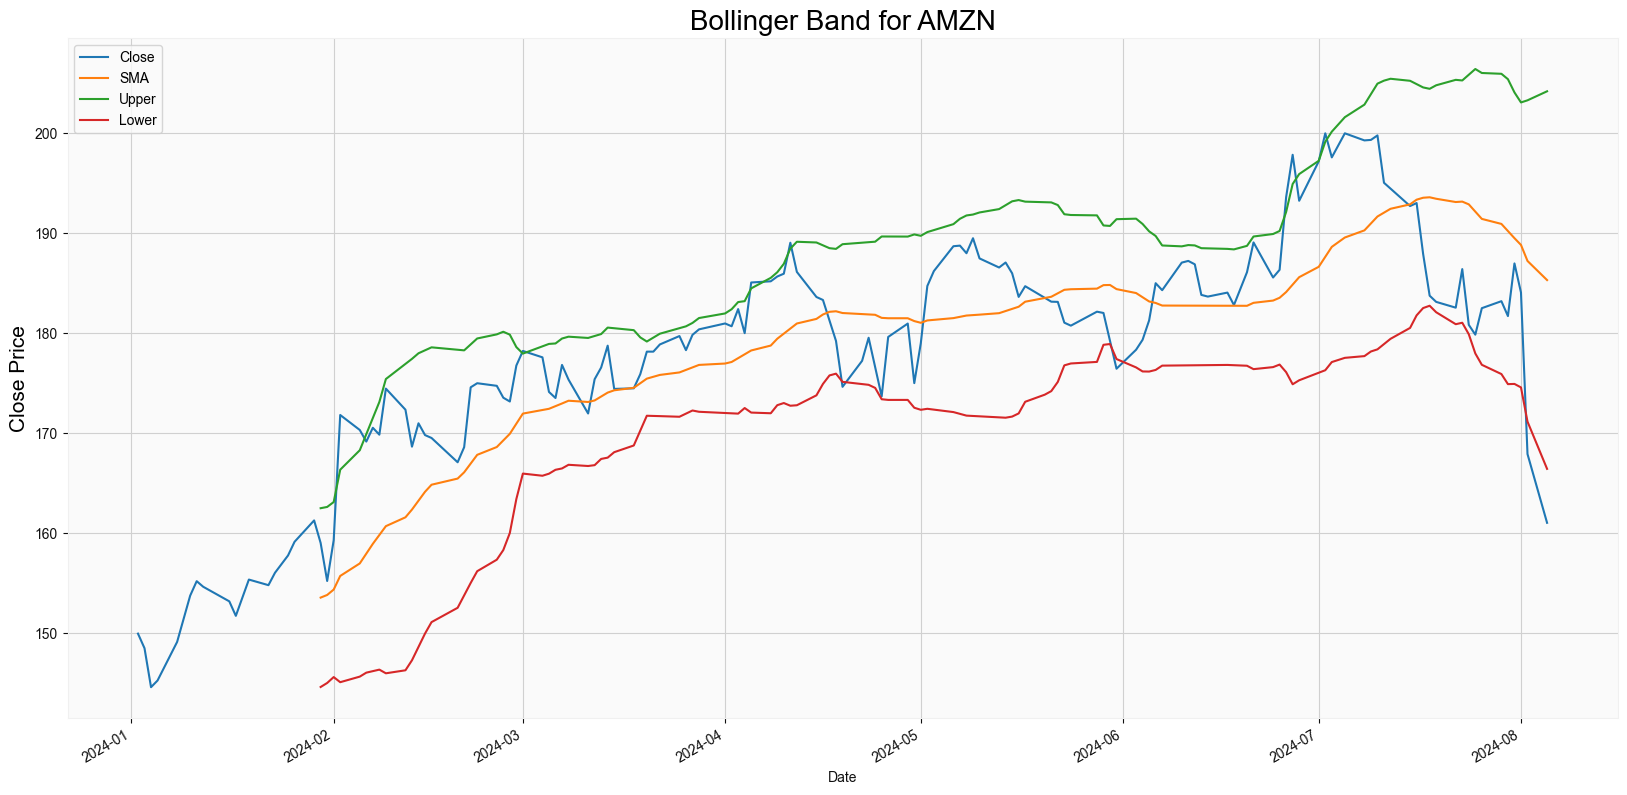

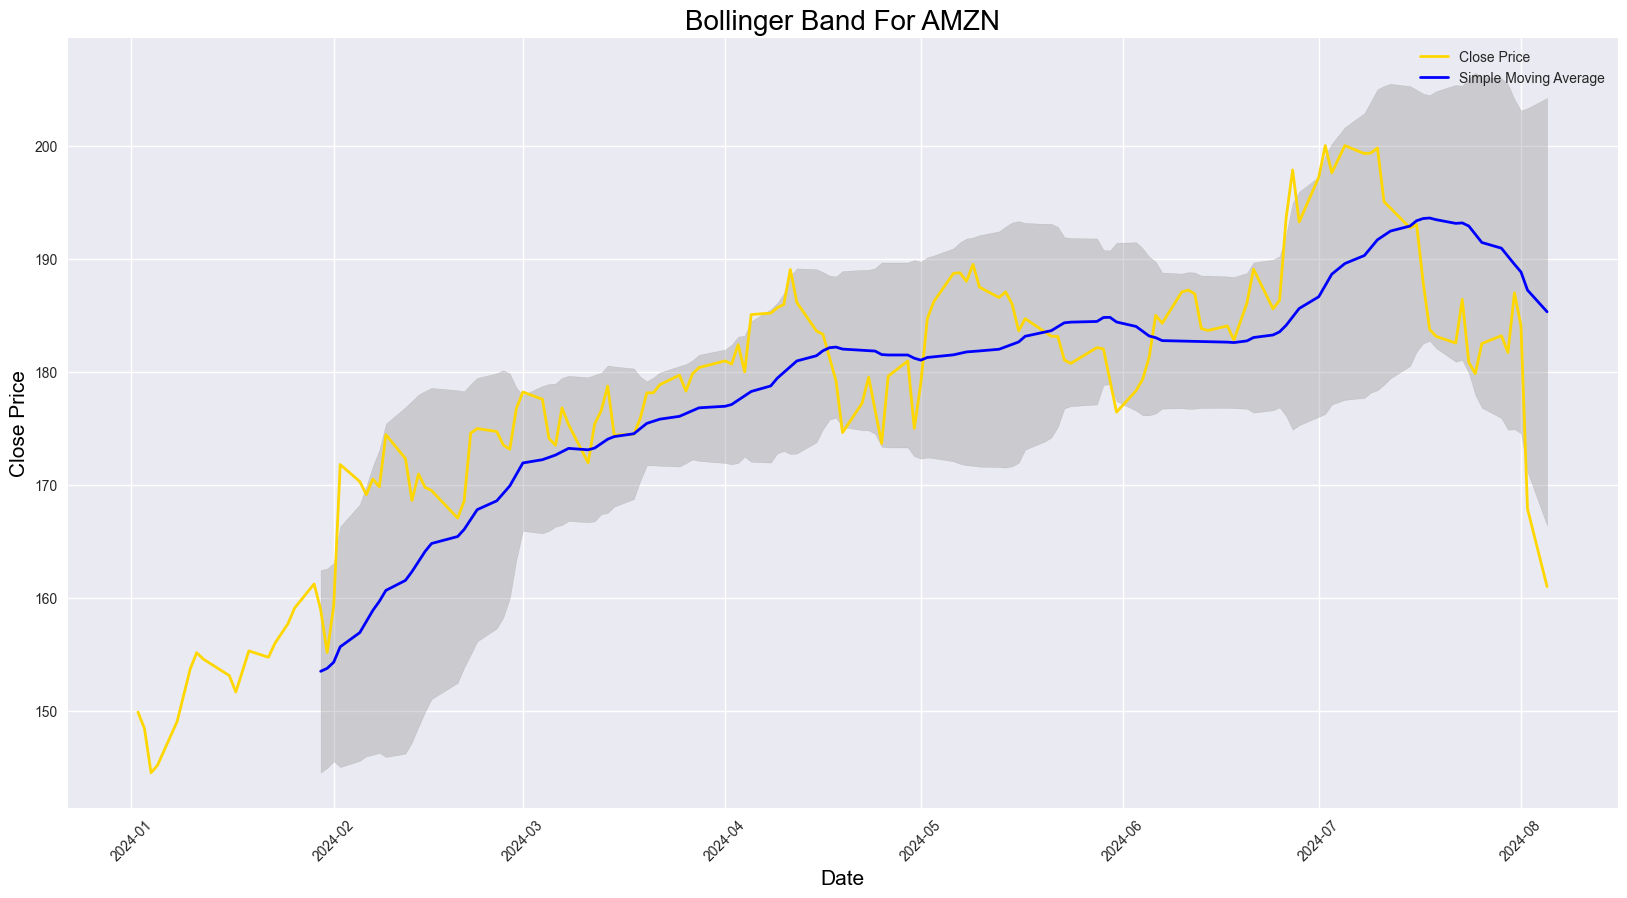

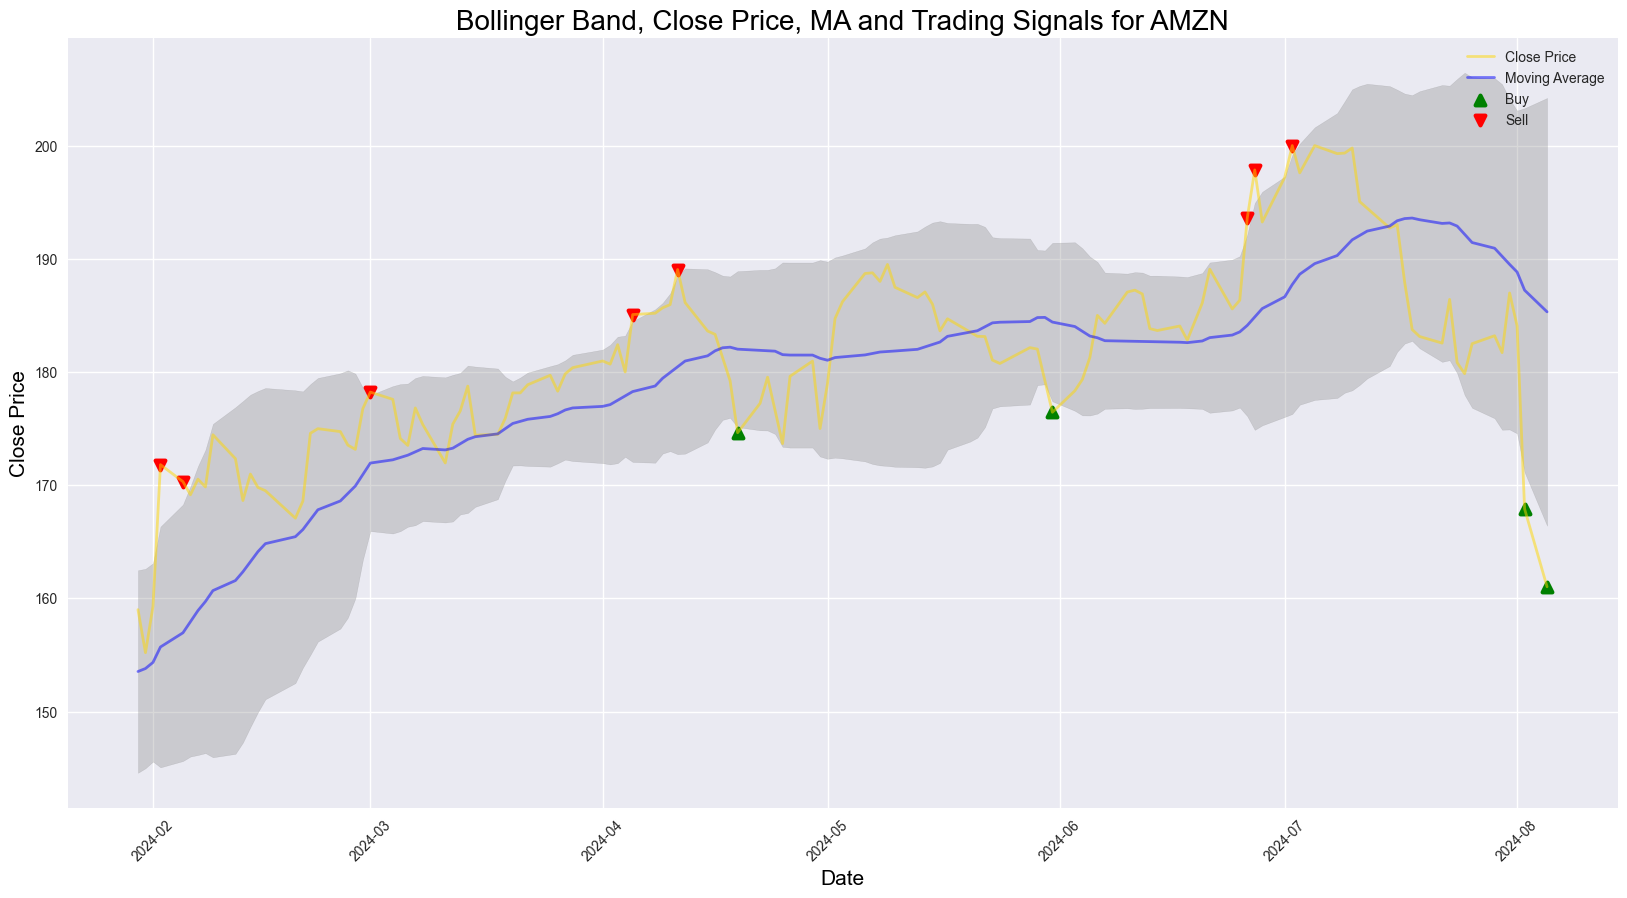

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming `amzn_roc_12mo` is the DataFrame with amzn stock data
amzn_12mo_bb = amzn_roc_12mo.copy()

# Parameters
period = 20

# Calculate Bollinger Bands
amzn_12mo_bb['SMA'] = amzn_12mo_bb['Close'].rolling(window=period).mean()
amzn_12mo_bb['STD'] = amzn_12mo_bb['Close'].rolling(window=period).std()
amzn_12mo_bb['Upper'] = amzn_12mo_bb['SMA'] + (amzn_12mo_bb['STD'] * 2)
amzn_12mo_bb['Lower'] = amzn_12mo_bb['SMA'] - (amzn_12mo_bb['STD'] * 2)

# Keep relevant columns
column_list = ['Close', 'SMA', 'Upper', 'Lower']

# Plot Bollinger Bands
def bb_12mo():
    amzn_12mo_bb[column_list].plot(figsize=(20, 10))
    plt.style.use('seaborn')
    plt.title('Bollinger Band for AMZN', color='black', fontsize=20)
    plt.ylabel('Close Price', color='black', fontsize=15)
    plt.show()

bb_12mo()

# Plot Bollinger Bands with shading
def bb_shaded():
    fig, ax = plt.subplots(figsize=(20, 10))
    x_axis = amzn_12mo_bb.index
    ax.fill_between(x_axis, amzn_12mo_bb['Upper'], amzn_12mo_bb['Lower'], color='grey', alpha=0.3)
    ax.plot(x_axis, amzn_12mo_bb['Close'], color='gold', lw=2, label='Close Price')
    ax.plot(x_axis, amzn_12mo_bb['SMA'], color='blue', lw=2, label='Simple Moving Average')
    ax.set_title('Bollinger Band For AMZN', color='black', fontsize=20)
    ax.set_xlabel('Date', color='black', fontsize=15)
    ax.set_ylabel('Close Price', color='black', fontsize=15)
    plt.xticks(rotation=45)
    ax.legend()
    plt.show()

bb_shaded()

# Prepare new DataFrame for signals
new_amzn_12mo_bb = amzn_12mo_bb[period-1:].copy()

# Function to get buy and sell signals
def get_signal_bb(data):
    buy_signal = []
    sell_signal = []

    for i in range(len(data['Close'])):
        if data['Close'][i] > data['Upper'][i]:
            buy_signal.append(np.nan)
            sell_signal.append(data['Close'][i])
        elif data['Close'][i] < data['Lower'][i]:
            sell_signal.append(np.nan)
            buy_signal.append(data['Close'][i])
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
    
    return buy_signal, sell_signal

# Add buy and sell signals to DataFrame
new_amzn_12mo_bb['Buy'] = get_signal_bb(new_amzn_12mo_bb)[0]
new_amzn_12mo_bb['Sell'] = get_signal_bb(new_amzn_12mo_bb)[1]

# Plot all data with signals
def bb_alldata():
    fig, ax = plt.subplots(figsize=(20, 10))
    x_axis = new_amzn_12mo_bb.index
    ax.fill_between(x_axis, new_amzn_12mo_bb['Upper'], new_amzn_12mo_bb['Lower'], color='grey', alpha=0.3)
    ax.plot(x_axis, new_amzn_12mo_bb['Close'], color='gold', lw=2, label='Close Price', alpha=0.5)
    ax.plot(x_axis, new_amzn_12mo_bb['SMA'], color='blue', lw=2, label='Moving Average', alpha=0.5)
    ax.scatter(x_axis, new_amzn_12mo_bb['Buy'], color='green', lw=3, label='Buy', marker='^', alpha=1)
    ax.scatter(x_axis, new_amzn_12mo_bb['Sell'], color='red', lw=3, label='Sell', marker='v', alpha=1)
    ax.set_title('Bollinger Band, Close Price, MA and Trading Signals for AMZN', color='black', fontsize=20)
    ax.set_xlabel('Date', color='black', fontsize=15)
    ax.set_ylabel('Close Price', color='black', fontsize=15)
    plt.xticks(rotation=45)
    ax.legend()
    plt.show()

bb_alldata()

The Bollinger Bands technical indicator is an example of a mean reversion strategy.

5.3.2 Mean reversion strategies
In mean reversion algorithmic trading strategies stocks return to their mean and we can exploit when it deviates from that mean.

These strategies usually involve selling into up moves and buying into down moves, a contrarian approach which assumes that the market has become oversold/overbought and prices will revert to their historical trends. This is almost the opposite of trend following where we enter in the direction of the strength and momentum, and momentum strategies such as buying stocks that have been showing an upward trend in hopes that the trend will continue, a continuation approach.

6. Conclusion
It is almost certainly better to choose technical indicators that complement each other, not just those that move in unison and generate the same signals. The intuition here is that the more indicators you have that confirm each other, the better your chances are to profit. This can be done by combining strategies to form a system, and looking for multiple signals.